**Tunning dos hiperparâmetros**
- Será realizado o tunning para os seguintes casos:
    1) sem informações do WHOQOL na base
    2) com todas as respostas do WHOQOL
    3) só com o índice final do WHOQOL
    4) só com os índices dos domínios do WHOQOL

- Para os seguintes modelos:
    1) Random Forest
    2) SVM
    3) MLP
    4) XGBoost

**Workflow:**
Para cada caso:
1. Importar dados
2. Separar em treino, teste e validação.
3. Definir os parâmetros a serem testados
4. Realizar o tunning
5. Salvar os resultados graficamente
6. Salvar o melhor modelo
7. Aplicar o Random Under-Sampling no treino (Voltar para o passo 3).


## SETUP
(Executar apenas uma vez)

In [1]:
# Instalando bibliotecas
!pip install -U pandas
!pip install -U numpy
!pip install -U scipy
!pip install -U scikit-learn
!pip install -U imbalanced-learn
!pip install -U xgboost
!pip install -U mlxtend
!pip install -U joblib
!pip install -U seaborn
!pip install -U matplotlib

## Inicialização
(Executar sempre que reiniciar o kernel)

### Importando as bibliotecas

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder, StandardScaler
import os
from sklearn.model_selection import KFold
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#Importando modelo Dummy:
from sklearn.dummy import DummyClassifier
import pickle
import time
import multiprocessing
n_cpus = multiprocessing.cpu_count()
from sklearn.model_selection import RandomizedSearchCV

# import warnings
# warnings.filterwarnings('ignore')

np.random.seed(15) # Para reproduzir os resultados

### Definindo a função

In [3]:
def plot_model_performance(model_accuracies, base_name):
    # Create a DataFrame with the results
    df_resultado = pd.DataFrame({'Modelo': list(model_accuracies.keys()), 'Acurácia': list(model_accuracies.values())})

    # Sort the DataFrame by accuracy
    df_resultado = df_resultado.sort_values(by='Acurácia', ascending=False)

    # Define a color dictionary for each model
    model_colors = {
        'Random Forest': 'blue',
        'SVM': 'green',
        'MLP': 'orange',
        'XGBoost': 'purple',
        'KNN': 'brown',
        'ADA': 'pink',
        'NVB': 'red',
        'LR': 'cyan',
        'DT': 'olive',
        'EXT': 'black'
    }

    # Plot the bar chart, which ranges from 0 to 1
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])
    plt.xlim(0, 1)

    # Add values on the bars
    for index, value in enumerate(df_resultado['Acurácia']):
        ax.text(value + 0.01, index, f'{value:.4f}', va='center', fontsize=8, color='black')

    plt.title('Desempenho dos modelos')
    plt.tight_layout()
    plt.show()


In [4]:
def perform_random_model_tuning(models, param_grids, base_name, data=None, target=None, x_train = None, y_train=None):
    
    if data is not None and target is not None:
        # Dividir os dados em treinamento e teste
        X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
    elif x_train is not None and y_train is not None:
        X_train = x_train
        y_train = y_train
    else:
        raise ValueError("Parâmetros inválidos. É necessário passar os dados e os rótulos ou os conjuntos de treino e teste.")

    start_tunning = time.time()
    
    best_models = {}  # Dicionário para armazenar o melhor modelo de cada tipo
    model_accuracies = {}  # Dicionário para armazenar as acurácias de cada modelo
    current_dir = os.getcwd()
    for model_name, model, param_grid_entry in zip(models.keys(), models.values(), param_grids):
        print(f"\nTuning do modelo {model_name} iniciado...")

        # Acessar o dicionário de parâmetros correspondente ao modelo atual
        param_grid = param_grid_entry['params']
        
        print("Paramêtros sendo testados:")
        #Imprime os parametros que serão testados
        for param in param_grid.keys():
            print(f"{param} | {param_grid[param]}")

        try:
            # Realizar a busca aleatória para encontrar os melhores parâmetros
            grid_search = RandomizedSearchCV(model, param_grid, cv=5, scoring='accuracy', verbose=True, n_jobs=n_cpus, n_iter=75, random_state=13, error_score='raise')

            # Iniciar a contagem do tempo
            start = time.time()

            grid_search.fit(X_train, y_train)

            # Finalizar a contagem do tempo
            end = time.time()

                        
            # cv_results = grid_search.cv_results_
            # best_index = grid_search.best_index_
            # best_f1_weighted = cv_results['mean_test_f1_weighted'][best_index]
            # print(f"Tempo de execução: {end - start:.2f}s | Modelo: {model_name} | Acurácia: {grid_search.best_score_} | F1: {best_f1_weighted}")
            
            print(f"Tempo de execução: {end - start:.2f}s | Modelo: {model_name} | Acurácia: {grid_search.best_score_}")
            # Melhor modelo encontrado
            best_model = grid_search.best_estimator_

            # Calcular a acurácia do modelo
            accuracy = grid_search.best_score_
            model_accuracies[model_name] = accuracy



            # Imprimir parâmetros selecionados do modelo
            print(f"Parâmetros selecionados: {grid_search.best_params_}")

            # Salvar o melhor modelo
            best_models[model_name] = best_model

        except Exception as e:
            print(f"Modelo {model_name} não convergiu. Detalhes: {str(e)}")

    #Imprime a acuracia de cada modelo e o seu respectivo nome
    for model_name in model_accuracies.keys():
        print(f"\nModelo: {model_name} | Acurácia: {model_accuracies[model_name]}")

    # # Plotar gráfico de desempenho comparativo
    plot_model_performance(model_accuracies, base_name)

    end_tunning = time.time()

    #Pickle the single best model, verifying the best and saving from best_models dict, se tiver mais algo salvo com o mesmo nome, adiciona mais um.
    best_model = max(model_accuracies, key=model_accuracies.get)
    print(f"\n\nMelhor modelo: {best_model} | Acurácia: {model_accuracies[best_model]}")
    print(f"\nTempo de execução total :{end_tunning - start_tunning:.2f}s")
    best_model = best_models[best_model]
    
    if os.path.exists(f"{base_name}_best_model.pkl"):
        i = 1
        while os.path.exists(f"{base_name}_best_model_{i}.pkl"):
            i += 1
        pickle.dump(best_model, open(f"{base_name}_best_model_{i}.pkl", "wb"))
    else:
        pickle.dump(best_model, open(f"{base_name}_best_model.pkl", "wb"))

    # Salvar tabela com NOME DO MODELO, ACURÁCIA, PARAMETROS
    table_filename = f"{base_name}_acuracy.csv"
    results_df = pd.DataFrame(columns=['Modelo', 'Acurácia', 'Parâmetros'])

    # #Agora pega o nome de um modelo, confere sua acuracia pelo nome na variavel ´model_accuracies´ e pega os parametros do mesmo modelo no dicionario ´best_models´
    # for model_name in model_accuracies.keys():
    #     results_df.append([model_name, model_accuracies[model_name], best_models[model_name].get_params()])

    # Agora pega o nome de um modelo, confere sua acuracia pelo nome na variavel ´model_accuracies´ e pega os parametros do mesmo modelo no dicionario ´best_models´
    for model_name in model_accuracies.keys():
        row = {'Modelo': model_name, 'Acurácia': model_accuracies[model_name], 'Parâmetros': best_models[model_name].get_params()}
        results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)

    table_path = os.path.join(current_dir, table_filename)
    #Ordena os resultados pela acuracia
    results_df.sort_values(by=['Acurácia'], ascending=False)
    results_df.to_csv(table_path, index=False)



    # # Salvar tabela com os valores de acurácia
    # table_filename = f"{base_name}_acuracy.csv"
    # accuracies_df = pd.DataFrame.from_dict(model_accuracies, orient='index', columns=['Acurácia'])
    # table_path = os.path.join(current_dir, table_filename)
    # accuracies_df.to_csv(table_path, index=False)

    return best_models, best_model

In [5]:
def perform_model_tuning(models, param_grids, base_name, data=None, target=None, x_train = None, y_train=None, x_test=None,  y_test=None):
    
    if data is not None and target is not None:
        # Dividir os dados em treinamento e teste
        X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
    elif x_train is not None and x_test is not None and y_train is not None and y_test is not None:
        X_train = x_train
        X_test = x_test
        y_train = y_train
        y_test = y_test
    else:
        raise ValueError("Parâmetros inválidos. É necessário passar os dados e os rótulos ou os conjuntos de treino e teste.")

    start_tunning = time.time()
    
    best_models = {}  # Dicionário para armazenar o melhor modelo de cada tipo
    model_accuracies = {}  # Dicionário para armazenar as acurácias de cada modelo
    current_dir = os.getcwd()
    for model_name, model, param_grid_entry in zip(models.keys(), models.values(), param_grids):
        print(f"\nTuning do modelo {model_name} iniciado...")

        # Acessar o dicionário de parâmetros correspondente ao modelo atual
        param_grid = param_grid_entry['params']
        
        print("Paramêtros sendo testados:")
        #Imprime os parametros que serão testados
        for param in param_grid.keys():
            print(f"{param} | {param_grid[param]}")

        # Realizar a busca em grid para encontrar os melhores parâmetros
        grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', verbose=True, n_jobs=n_cpus, error_score='raise')
        
        # Iniciar a contagem do tempo
        start = time.time()
        
        grid_search.fit(X_train, y_train)
        
        # Finalizar a contagem do tempo
        end = time.time()
        print(f"Tempo de execução: {end - start:.2f}s | Modelo: {model_name}")
        # Melhor modelo encontrado
        best_model = grid_search.best_estimator_

        # # Fazer previsões no conjunto de teste
        # y_pred = best_model.predict(X_test)

        # Calcular a acurácia do modelo
        # accuracy = accuracy_score(y_test, y_pred)
        accuracy = grid_search.best_score_
        model_accuracies[model_name] = accuracy

        print(f"Acurácia do modelo {model_name}: {accuracy:.4f}")

        #Imprimindo parametros selecionados do modelo
        print(f"Parâmetros selecionados: {grid_search.best_params_}")

        # Salvar o melhor modelo
        best_models[model_name] = best_model

    

    #Imprime a acuracia de cada modelo e o seu respectivo nome
    for model_name in model_accuracies.keys():
        print(f"\nModelo: {model_name} | Acurácia: {model_accuracies[model_name]}")


    end_tunning = time.time()

    #Pickle the single best model, verifying the best and saving from best_models dict, se tiver mais algo salvo com o mesmo nome, adiciona mais um.
    best_model = max(model_accuracies, key=model_accuracies.get)
    print(f"\n\nMelhor modelo: {best_model} | Acurácia: {model_accuracies[best_model]}")
    print(f"\nTempo de execução total :{end_tunning - start_tunning:.2f}s")
    best_model = best_models[best_model]
    
    if os.path.exists(f"{base_name}_best_model.pkl"):
        i = 1
        while os.path.exists(f"{base_name}_best_model_{i}.pkl"):
            i += 1
        pickle.dump(best_model, open(f"{base_name}_best_model_{i}.pkl", "wb"))
    else:
        pickle.dump(best_model, open(f"{base_name}_best_model.pkl", "wb"))

    # Salvar tabela com NOME DO MODELO, ACURÁCIA, PARAMETROS
    table_filename = f"{base_name}_acuracy.csv"
    results_df = pd.Dataframe(collumns=['Modelo', 'Acurácia', 'Parâmetros'])

    #Agora pega o nome de um modelo, confere sua acuracia pelo nome na variavel ´model_accuracies´ e pega os parametros do mesmo modelo no dicionario ´best_models´
    for model_name in model_accuracies.keys():
        results_df.append([model_name, model_accuracies[model_name], best_models[model_name].get_params()])

    table_path = os.path.join(current_dir, table_filename)
    #Ordena os resultados pela acuracia
    results_df.sort_values(by=['Acurácia'], ascending=False)
    results_df.to_csv(table_path, index=False)



    # # Salvar tabela com os valores de acurácia
    # table_filename = f"{base_name}_acuracy.csv"
    # accuracies_df = pd.DataFrame.from_dict(model_accuracies, orient='index', columns=['Acurácia'])
    # table_path = os.path.join(current_dir, table_filename)
    # accuracies_df.to_csv(table_path, index=False)

    return best_models

In [6]:
def ler_arquivo_txt(nome_arquivo):
    with open(nome_arquivo, 'r') as arquivo:
        vetor_strings = []
        for linha in arquivo:
            valores = linha.strip().replace('(', '').replace(')', '').replace("'", '').split(', ')
            vetor_strings.append(valores)
    return vetor_strings

In [7]:
def avalia_modelo_cv(model, X_input, y_input, n, resultados_individuais=False):
    kf = KFold(n_splits=n, shuffle=True, random_state=13)
    reports = []
    y_true = []
    y_pred_list = []
    X_array = X_input.values
    accuracy_list = []
    model_name = type(model).__name__
    for fold_idx, (train_index, test_index) in enumerate(kf.split(X_input)):
        X_input, X_test = X_array[train_index], X_array[test_index]
        y_train, y_test = y_input[train_index], y_input[test_index]
        model.fit(X_input, y_train)
        y_pred = model.predict(X_test)
        y_true.extend(y_test)
        y_pred_list.append(y_pred)
        report = classification_report(y_test, y_pred, zero_division=0)
        reports.append(report)
        accuracy_list.append(accuracy_score(y_test, y_pred))
        if resultados_individuais:
            print(f"Classification Report for fold {fold_idx + 1}:\n{report}\n")
    y_pred_total = np.concatenate(y_pred_list)
    print("-" * 45)
    print("model_name: ", model_name)
    print("Average Classification Report:")
    avg_report = classification_report(y_true, y_pred_total, zero_division=0)
    print(avg_report)
    #Retorna a acuracia media
    return accuracy_score(y_true, y_pred_total)


# Função que chama os 4 modelos e retorna o resultado de cada um usando a função avalia_modelo_cv e imprime o resultado de cada um.

def avalia_dif_modelos_cv(X_train, y_test, cv):
    # Criando os modelos
    dummy_av = DummyClassifier(strategy='most_frequent',random_state=13)
    rf_av = RandomForestClassifier(n_jobs=n_cpus, random_state=13)
    svm_av = SVC(random_state=23, max_iter=-1)
    mlp_av = MLPClassifier(max_iter=2000,random_state=13)
    xgb_av = XGBClassifier(n_jobs=n_cpus, random_state=13)
    knn_av = KNeighborsClassifier(n_jobs=n_cpus)
    ada_av = AdaBoostClassifier(random_state=13)
    nvb_av = GaussianNB()
    lr_av = LogisticRegression(random_state=13, n_jobs=n_cpus, max_iter=1000)
    dt_av = DecisionTreeClassifier(random_state=13)
    ext_av = ExtraTreesClassifier(random_state=13, n_jobs=n_cpus)
    

    # Aplicando a função de avaliação
    dummy_fun_av = avalia_modelo_cv(dummy_av, X_train, y_test, cv)
    rf_fun_av = avalia_modelo_cv(rf_av, X_train, y_test, cv)
    svm_fun_av = avalia_modelo_cv(svm_av, X_train, y_test, cv)
    mlp_fun_av = avalia_modelo_cv(mlp_av, X_train, y_test, cv)
    #Passa de numpy para cupy
    xgb_fun_av = avalia_modelo_cv(xgb_av, X_train, y_test, cv)
    knn_fun_av = avalia_modelo_cv(knn_av, X_train, y_test, cv)
    ada_fun_av = avalia_modelo_cv(ada_av, X_train, y_test, cv)
    nvb_fun_av = avalia_modelo_cv(nvb_av, X_train, y_test, cv)
    lr_fun_av = avalia_modelo_cv(lr_av, X_train, y_test, cv)
    dt_fun_av = avalia_modelo_cv(dt_av, X_train, y_test, cv)
    ext_fun_av = avalia_modelo_cv(ext_av, X_train, y_test, cv)
    

    # Criando o dataframe com os resultados
    df_resultado = pd.DataFrame({'Modelo': ['Dummy', 'RF', 'SVM', 'MLP', 'XGB', 'KNN', 'ADA', 'NVB', 'LR', 'DT', 'EXT'],
                                 'Acurácia': [dummy_fun_av, rf_fun_av, svm_fun_av, mlp_fun_av, xgb_fun_av, knn_fun_av, ada_fun_av, nvb_fun_av, lr_fun_av, dt_fun_av, ext_fun_av]})


    # Ordenando o dataframe pela acurácia
    df_resultado = df_resultado.sort_values(by='Acurácia', ascending=False)

    # Define a color dictionary for each model
    model_colors = {
        'Dummy': 'gray',
        'RF': 'blue',
        'SVM': 'green',
        'MLP': 'orange',
        'XGB': 'purple',
        'KNN': 'brown',
        'ADA': 'pink',
        'NVB': 'red',
        'LR': 'cyan',
        'DT': 'olive',
        'EXT': 'black'
    }

    # Plotando o gráfico de barras, que vai de 0 a 1
    ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])
    plt.xlim(0, 1)

    # Adicionando os valores nas barras
    for index, value in enumerate(df_resultado['Acurácia']):
        ax.text(value + 0.01, index, f'{value:.4f}', va='center', fontsize=8, color='black')

    plt.show("Desempenho dos modelos")
    #%matplotlib inline

    return df_resultado

In [8]:
def perform_cross_validation(model, X, y, cv, verbose=True):
    reports = []
    predictions = cross_val_predict(model, X, y, cv=cv)

    for fold in range(cv):
        start = fold * len(X) // cv
        end = (fold + 1) * len(X) // cv
        report = classification_report(y[start:end], predictions[start:end], output_dict=True)
        reports.append(report)

        if verbose:
            print(f"Fold {fold + 1} Classification Report:")
            print(classification_report(y[start:end], predictions[start:end]))
            print("-" * 50)

    avg_report = {
        'precision': np.mean([report['weighted avg']['precision'] for report in reports]),
        'recall': np.mean([report['weighted avg']['recall'] for report in reports]),
        'f1-score': np.mean([report['weighted avg']['f1-score'] for report in reports]),
        'support': np.mean([report['weighted avg']['support'] for report in reports])
    }

    accuracy = accuracy_score(y, predictions)

    if verbose or not verbose:
        print("Average Classification Report:")
        print(classification_report(y, predictions))
        print("-" * 50)
        print(f"Accuracy: {accuracy:.2f}")

    return None


In [9]:
# Função para aplicar SBFS e SFFS com cross validation e salvar tabela com resultado.
def perform_feature_selection(data, target, model, best_model, method, cv):
    n_cpus = multiprocessing.cpu_count()
    # Criando o objeto de seleção de features
    if method == 'SBFS':
        sfs = SFS(model,
                  k_features="best",
                  forward=False,
                  floating=True,
                  verbose=2,
                  scoring='accuracy',
                  cv=cv,
                  n_jobs=n_cpus)
    elif method == 'SFFS':
        sfs = SFS(model,
                  k_features="best",
                  forward=True,
                  floating=True,
                  verbose=2,
                  scoring='accuracy',
                  cv=cv,
                  n_jobs=n_cpus)
    # Aplicando o método de seleção de features
    sfs = sfs.fit(data, target)
    # Salvando o resultado em um dataframe
    df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

    # Definindo nome do arquivo para salvar as features selecionadas em formato CSV
    if os.path.exists(f"results/{method}_{best_model}.csv"):
        i = 1
        while os.path.exists(f"results/{method}_{best_model}_{i}.csv"):
            i += 1
        file_name_csv = f"results/{method}_{best_model}_{i}.csv"
    else:
        file_name_csv = f"results/{method}_{best_model}.csv"

    # Salvando o dataframe em um arquivo CSV
    df.to_csv(file_name_csv, index=False)

    # Definindo nome do arquivo para salvar as features selecionadas em formato TXT
    if os.path.exists(f"results/{method}_{best_model}.txt"):
        i = 1
        while os.path.exists(f"results/{method}_{best_model}_{i}.txt"):
            i += 1
        file_name_txt = f"results/{method}_{best_model}_{i}.txt"
    else:
        file_name_txt = f"results/{method}_{best_model}.txt"

    # Salvando as features selecionadas e o score em um arquivo TXT
    with open(file_name_txt, 'w') as file:
        file.write(f"Selected Features: {', '.join(sfs.k_feature_names_)}\n")
        file.write(f"Score: {sfs.k_score_}")

    # Plotando o desempenho do modelo para cada combinação de atributos
    fig, ax = plt.subplots()
    ax.plot(range(1, len(df) + 1), df['avg_score'], marker='o')
    ax.set_xlabel('Number of Features')
    ax.set_ylabel('Average Score')
    ax.set_title('Performance of Model with Feature Selection')
    plt.xticks(range(1, len(df) + 1))
    plt.grid(True)

    # Definindo nome do arquivo para salvar o gráfico
    if os.path.exists(f"results/{method}_{best_model}.png"):
        i = 1
        while os.path.exists(f"results/{method}_{best_model}_{i}.png"):
            i += 1
        file_name_plot = f"results/{method}_{best_model}_{i}.png"
    else:
        file_name_plot = f"results/{method}_{best_model}.png"

    # Salvando o gráfico em um arquivo PNG
    plt.savefig(file_name_plot)

    # Retornando as features selecionadas e o score
    return sfs.k_feature_names_, sfs.k_score_

In [10]:
def updt_maxfeature(modelo):
    try:
        if modelo.get_params()['max_features'] == 'auto':
            modelo.max_features = 'sqrt'
            print(modelo)
        if modelo.get_params()['device'] == 'cuda':
            modelo.device = 'gpu'
            print(modelo)
    except:
        pass


### Importando os dados
- BASE1 = [SOCIODEMOGRÁFICO]
- BASE2 = [SOCIODEMOGRÁFICO ISM_GLOBAL]
- BASE3 = [SOCIODEMOGRÁFICO ISM_Ansiedade ISM_Depressao ISM_Emocional ISM_Afeto ISM_Lacos]
- BASE4 = [SOCIODEMOGRÁFICO ISM]


Eu vou aplicar label enconder.

In [11]:
# SOMENTE SOCIODEMOGRAFCIO:
base1 = pd.read_csv(r'Datasets/df_base1.csv')
data1 = base1.drop('classes_whoqol', axis=1)
target1 = base1['classes_whoqol']

labelEncoder = LabelEncoder()
target1 = labelEncoder.fit_transform(target1)


# Dividir os dados em treino e teste
X_train1, X_test1, y_train1, y_test1 = train_test_split(data1, target1, test_size=0.2, random_state=13, stratify=target1)


# Realizar Random Under-Sampling no treino
sampler1 = RandomUnderSampler(random_state=13,)
X_train1_re, y_train1_re = sampler1.fit_resample(X_train1, y_train1)

StandardScaler1 = StandardScaler()
X_train1_norm = pd.DataFrame(StandardScaler1.fit_transform(X_train1), columns=X_train1.columns)

X_test1_norm = pd.DataFrame(StandardScaler1.transform(X_test1), columns=X_test1.columns)

In [12]:
# SOCIODEMOGRAFICO + ISM_GLOBAL:
base2 = pd.read_csv(r'Datasets/df_base2.csv')
data2 = base2.drop('classes_whoqol', axis=1)
target2 = base2['classes_whoqol']

#LabelEncoding
target2 = labelEncoder.fit_transform(target2)

# Dividir os dados em treino e teste
X_train2, X_test2, y_train2, y_test2 = train_test_split(data2, target2, test_size=0.2, random_state=13, stratify=target2)

# Realizar Random Under-Sampling no treino
sampler = RandomUnderSampler(random_state=13)
X_train2_re, y_train2_re = sampler.fit_resample(X_train2, y_train2)

StandardScaler2 = StandardScaler()
X_train2_norm = pd.DataFrame(StandardScaler2.fit_transform(X_train2), columns=X_train2.columns)

X_test2_norm = pd.DataFrame(StandardScaler2.transform(X_test2), columns=X_test2.columns)

In [13]:
# SOCIODEMOGRÁFICO ISM_Ansiedade ISM_Depressao ISM_Emocional ISM_Afeto ISM_Lacos
base3 = pd.read_csv(r'Datasets/df_base3.csv')
data3 = base3.drop('classes_whoqol', axis=1)
target3 = base3['classes_whoqol']


#LabelEncoding
target3 = labelEncoder.fit_transform(target3)

# Dividir os dados em treino e teste
X_train3, X_test3, y_train3, y_test3 = train_test_split(data3, target3, test_size=0.2, random_state=13, stratify=target3)

# Realizar Random Under-Sampling no treino
sampler = RandomUnderSampler(random_state=13)
X_train3_re, y_train3_re = sampler.fit_resample(X_train3, y_train3)

StandardScaler3 = StandardScaler()
X_train3_norm = pd.DataFrame(StandardScaler3.fit_transform(X_train3), columns=X_train3.columns)

X_test3_norm = pd.DataFrame(StandardScaler3.transform(X_test3), columns=X_test3.columns)

In [14]:
# SOCIODEMOGRÁFICO ISM
base4 = pd.read_csv(r'Datasets/df_base4.csv')
data4 = base4.drop('classes_whoqol', axis=1)
target4 = base4['classes_whoqol']


#LabelEncoding
target4 = labelEncoder.fit_transform(target4)

# Dividir os dados em treino e teste
X_train4, X_test4, y_train4, y_test4 = train_test_split(data4, target4, test_size=0.2, random_state=13, stratify=target4)

# Realizar Random Under-Sampling no treino
sampler = RandomUnderSampler(random_state=13)
X_train4_re, y_train4_re = sampler.fit_resample(X_train4, y_train4)

StandardScaler4 = StandardScaler()
X_train4_norm = pd.DataFrame(StandardScaler4.fit_transform(X_train4), columns=X_train4.columns)

X_test4_norm = pd.DataFrame(StandardScaler4.transform(X_test4), columns=X_test4.columns)

## Analise exploratória dos dados
- Ver numero de linhas e colunas de cada base, com e sem Random Under-Sampling. 
- Ver como ficou divisão de treino e teste.
- Ver como ficou a divisão de treino e validação.
- Ver como ficou a divisão de treino e teste com o Random Under-Sampling.

### Verificando o tamanho das bases

In [15]:
# Verificando o tamanho das bases 
print("Tamanho das bases: (LINHAS, COLUNAS) ou (Numº amostras | Numº Features)")
print(f"Base 1: {data1.shape}")
print(f"Base 2: {data2.shape}")
print(f"Base 3: {data3.shape}")
print(f"Base 4: {data4.shape}")


Tamanho das bases: (LINHAS, COLUNAS) ou (Numº amostras | Numº Features)
Base 1: (871, 54)
Base 2: (871, 55)
Base 3: (871, 59)
Base 4: (871, 92)


In [16]:
# Verificando o tamanho das bases de treino e teste
print("Tamanho das bases de treino e teste: TREINO(Numº amostras | Numº Features) e TESTE(Numº amostras | Numº Features)")
print(f"Base 1: {X_train1.shape}, {X_test1.shape}")
print(f"Base 2: {X_train2.shape}, {X_test2.shape}")
print(f"Base 3: {X_train3.shape}, {X_test3.shape}")
print(f"Base 4: {X_train4.shape}, {X_test4.shape}")

Tamanho das bases de treino e teste: TREINO(Numº amostras | Numº Features) e TESTE(Numº amostras | Numº Features)
Base 1: (696, 54), (175, 54)
Base 2: (696, 55), (175, 55)
Base 3: (696, 59), (175, 59)
Base 4: (696, 92), (175, 92)


In [17]:
# Verificando o tamanho das bases com Random Under-Sampling
print("Tamanho das bases com Random Under-Sampling: (Numº amostras | Numº Features)")

print(f"Base 1: Treino {X_train1_re.shape} {y_train1_re.shape} | Teste: {X_test1.shape} {y_test1.shape}")
print(f"Base 2: Treino {X_train2_re.shape} {y_train2_re.shape} | Teste: {X_test2.shape} {y_test2.shape}")
print(f"Base 3: Treino {X_train3_re.shape} {y_train3_re.shape} | Teste: {X_test3.shape} {y_test3.shape}")
print(f"Base 4: Treino {X_train4_re.shape} {y_train4_re.shape} | Teste: {X_test4.shape} {y_test4.shape}")

Tamanho das bases com Random Under-Sampling: (Numº amostras | Numº Features)
Base 1: Treino (246, 54) (246,) | Teste: (175, 54) (175,)
Base 2: Treino (246, 55) (246,) | Teste: (175, 55) (175,)
Base 3: Treino (246, 59) (246,) | Teste: (175, 59) (175,)
Base 4: Treino (246, 92) (246,) | Teste: (175, 92) (175,)


### Verificando a distribuição das classes

In [18]:
# Verificando a distribuição das classes
def print_classes(data, label_encoder):
    classes, counts = np.unique(label_encoder.inverse_transform(data), return_counts=True)
    for cls, count in zip(classes, counts):
        print(f"Class {cls}: {count} | ", end='')


# Print histogram-like representation
print("Distribuição das classes:")
print(f"Base 1:")
print_classes(target1, labelEncoder)
print(f"\nBase 2:")
print_classes(target2, labelEncoder)
print(f"\nBase 3")
print_classes(target3, labelEncoder)
print(f"\nBase 4")
print_classes(target4, labelEncoder)


Distribuição das classes:
Base 1:
Class 1.0: 226 | Class 2.0: 542 | Class 3.0: 103 | 
Base 2:
Class 1.0: 226 | Class 2.0: 542 | Class 3.0: 103 | 
Base 3
Class 1.0: 226 | Class 2.0: 542 | Class 3.0: 103 | 
Base 4
Class 1.0: 226 | Class 2.0: 542 | Class 3.0: 103 | 

In [19]:
# Verificando a distribuição das classes com Random Under-Sampling
print("Distribuição das classes com Random Under-Sampling:")
print("Distribuição das classes:")
print(f"Base 1:")
print_classes(y_train1_re, labelEncoder)
print(f"\nBase 2:")
print_classes(y_train2_re,labelEncoder)
print(f"\nBase 3")
print_classes(y_train3_re,labelEncoder)
print(f"\nBase 4")
print_classes(y_train4_re, labelEncoder)

Distribuição das classes com Random Under-Sampling:
Distribuição das classes:
Base 1:
Class 1.0: 82 | Class 2.0: 82 | Class 3.0: 82 | 
Base 2:
Class 1.0: 82 | Class 2.0: 82 | Class 3.0: 82 | 
Base 3
Class 1.0: 82 | Class 2.0: 82 | Class 3.0: 82 | 
Base 4
Class 1.0: 82 | Class 2.0: 82 | Class 3.0: 82 | 

## Avaliando modelos sem Under-Sampling

### Base 1

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       181
           1       0.62      1.00      0.77       433
           2       0.00      0.00      0.00        82

    accuracy                           0.62       696
   macro avg       0.21      0.33      0.26       696
weighted avg       0.39      0.62      0.48       696



---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.07      0.11       181
           1       0.63      0.95      0.76       433
           2       0.00      0.00      0.00        82

    accuracy                           0.61       696
   macro avg       0.33      0.34      0.29       696
weighted avg       0.48      0.61      0.50       696

---------------------------------------------
model_name:  SVC
Average Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.01      0.02       181
           1       0.62      1.00      0.77       433
           2       0.00      0.00      0.00        82

    accuracy                           0.62       696
   macro avg       0.37      0.34      0.26       696
weighted avg       0.52      0.62      0.48       696

-------------------------------

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_15344\2775261965.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


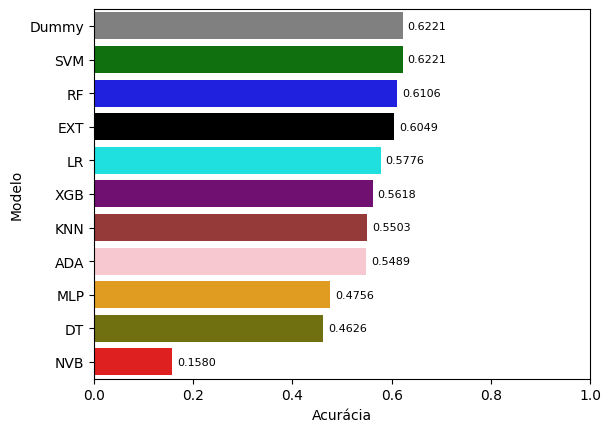

Modelo  Acurácia
0   Dummy  0.622126
2     SVM  0.622126
1      RF  0.610632
10    EXT  0.604885
8      LR  0.577586
4     XGB  0.561782
5     KNN  0.550287
6     ADA  0.548851
3     MLP  0.475575
9      DT  0.462644
7     NVB  0.158046

In [20]:
avalia_dif_modelos_cv(X_train1, y_train1, 5)

### Base 2

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       181
           1       0.62      1.00      0.77       433
           2       0.00      0.00      0.00        82

    accuracy                           0.62       696
   macro avg       0.21      0.33      0.26       696
weighted avg       0.39      0.62      0.48       696

---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.52      0.61       181
           1       0.71      0.92      0.80       433
           2       0.75      0.04      0.07        82

    accuracy                           0.71       696
   macro avg       0.73      0.49      0.49       696
weighted avg       0.72      0.71      0.66       696

---------------------------------------------
model_name:  SVC
Average Classification Report:
              precision    reca

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_15344\2775261965.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


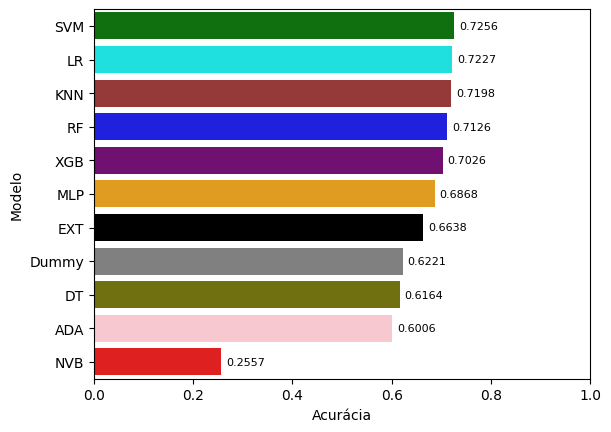

Modelo  Acurácia
2     SVM  0.725575
8      LR  0.722701
5     KNN  0.719828
1      RF  0.712644
4     XGB  0.702586
3     MLP  0.686782
10    EXT  0.663793
0   Dummy  0.622126
9      DT  0.616379
6     ADA  0.600575
7     NVB  0.255747

In [21]:
avalia_dif_modelos_cv(X_train2, y_train2, 5)

### Base 3

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       181
           1       0.62      1.00      0.77       433
           2       0.00      0.00      0.00        82

    accuracy                           0.62       696
   macro avg       0.21      0.33      0.26       696
weighted avg       0.39      0.62      0.48       696

---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.56      0.65       181
           1       0.73      0.91      0.81       433
           2       0.73      0.23      0.35        82

    accuracy                           0.74       696
   macro avg       0.74      0.57      0.60       696
weighted avg       0.74      0.74      0.71       696

-------------------

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_15344\2775261965.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


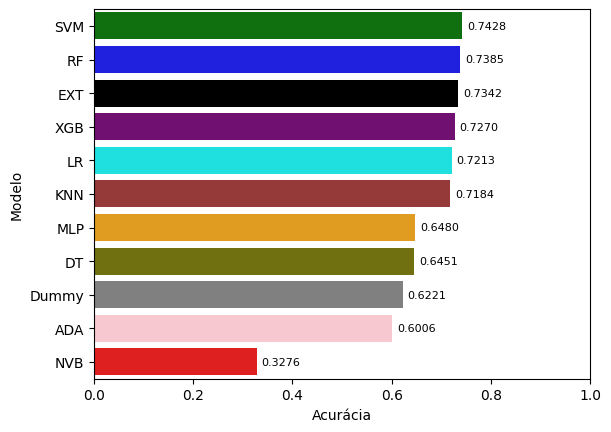

Modelo  Acurácia
2     SVM  0.742816
1      RF  0.738506
10    EXT  0.734195
4     XGB  0.727011
8      LR  0.721264
5     KNN  0.718391
3     MLP  0.647989
9      DT  0.645115
0   Dummy  0.622126
6     ADA  0.600575
7     NVB  0.327586

In [22]:
avalia_dif_modelos_cv(X_train3, y_train3, 5)

### Base 4

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       181
           1       0.62      1.00      0.77       433
           2       0.00      0.00      0.00        82

    accuracy                           0.62       696
   macro avg       0.21      0.33      0.26       696
weighted avg       0.39      0.62      0.48       696



---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.56      0.64       181
           1       0.74      0.89      0.81       433
           2       0.67      0.32      0.43        82

    accuracy                           0.74       696
   macro avg       0.72      0.59      0.63       696
weighted avg       0.73      0.74      0.72       696

---------------------------------------------
model_name:  SVC
Average Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.54      0.63       181
           1       0.72      0.92      0.81       433
           2       0.86      0.07      0.13        82

    accuracy                           0.72       696
   macro avg       0.77      0.51      0.52       696
weighted avg       0.74      0.72      0.68       696

-------------------------------

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_15344\2775261965.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


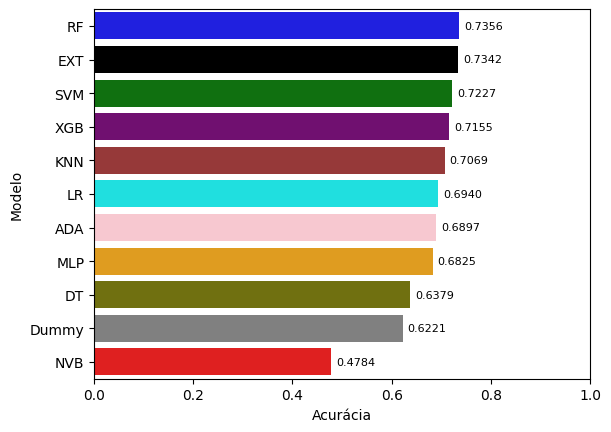

Modelo  Acurácia
1      RF  0.735632
10    EXT  0.734195
2     SVM  0.722701
4     XGB  0.715517
5     KNN  0.706897
8      LR  0.693966
6     ADA  0.689655
3     MLP  0.682471
9      DT  0.637931
0   Dummy  0.622126
7     NVB  0.478448

In [23]:
avalia_dif_modelos_cv(X_train4, y_train4, 5)

## Avaliando modelos com Under-Sampling

### Base 1

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.35      0.32        82
           1       0.31      0.18      0.23        82
           2       0.28      0.33      0.30        82

    accuracy                           0.29       246
   macro avg       0.29      0.29      0.28       246
weighted avg       0.29      0.29      0.28       246



---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.48      0.45        82
           1       0.36      0.34      0.35        82
           2       0.37      0.35      0.36        82

    accuracy                           0.39       246
   macro avg       0.39      0.39      0.39       246
weighted avg       0.39      0.39      0.39       246

---------------------------------------------
model_name:  SVC
Average Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.22      0.30        82
           1       0.34      0.60      0.43        82
           2       0.29      0.22      0.25        82

    accuracy                           0.35       246
   macro avg       0.37      0.35      0.33       246
weighted avg       0.37      0.35      0.33       246

-------------------------------

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_15344\2775261965.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


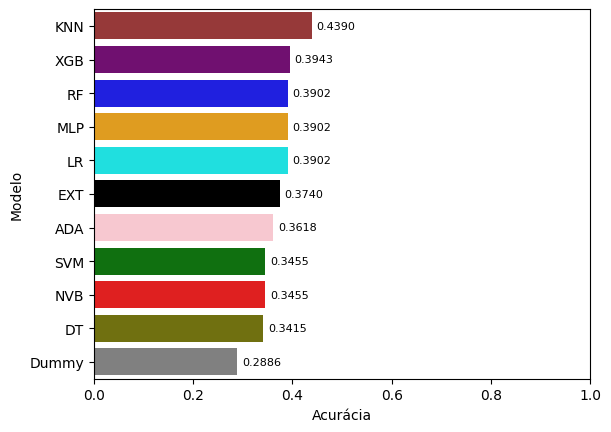

Modelo  Acurácia
5     KNN  0.439024
4     XGB  0.394309
1      RF  0.390244
3     MLP  0.390244
8      LR  0.390244
10    EXT  0.373984
6     ADA  0.361789
2     SVM  0.345528
7     NVB  0.345528
9      DT  0.341463
0   Dummy  0.288618

In [24]:
# Avaliando os modelos para cada dado com o treino
avalia_dif_modelos_cv(X_train1_re, y_train1_re, 5)

### Base 2

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.35      0.32        82
           1       0.31      0.18      0.23        82
           2       0.28      0.33      0.30        82

    accuracy                           0.29       246
   macro avg       0.29      0.29      0.28       246
weighted avg       0.29      0.29      0.28       246



---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.79      0.75        82
           1       0.57      0.44      0.50        82
           2       0.74      0.82      0.77        82

    accuracy                           0.68       246
   macro avg       0.67      0.68      0.67       246
weighted avg       0.67      0.68      0.67       246

---------------------------------------------
model_name:  SVC
Average Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.72      0.78        82
           1       0.63      0.62      0.63        82
           2       0.76      0.89      0.82        82

    accuracy                           0.74       246
   macro avg       0.75      0.74      0.74       246
weighted avg       0.75      0.74      0.74       246

-------------------------------

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_15344\2775261965.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


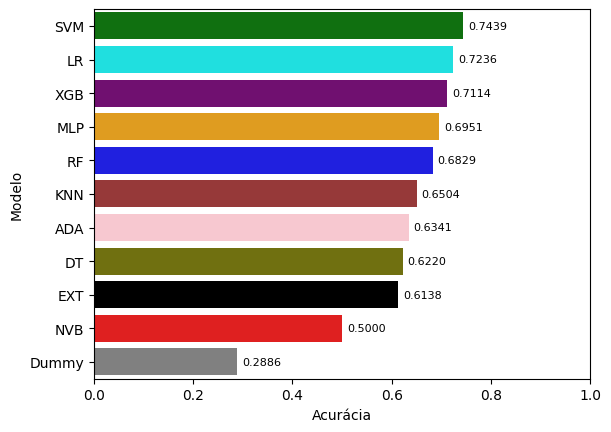

Modelo  Acurácia
2     SVM  0.743902
8      LR  0.723577
4     XGB  0.711382
3     MLP  0.695122
1      RF  0.682927
5     KNN  0.650407
6     ADA  0.634146
9      DT  0.621951
10    EXT  0.613821
7     NVB  0.500000
0   Dummy  0.288618

In [25]:
avalia_dif_modelos_cv(X_train2_re, y_train2_re, 5)

### Base 3

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.35      0.32        82
           1       0.31      0.18      0.23        82
           2       0.28      0.33      0.30        82

    accuracy                           0.29       246
   macro avg       0.29      0.29      0.28       246
weighted avg       0.29      0.29      0.28       246



---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76        82
           1       0.59      0.54      0.56        82
           2       0.76      0.83      0.79        82

    accuracy                           0.71       246
   macro avg       0.70      0.71      0.70       246
weighted avg       0.70      0.71      0.70       246

---------------------------------------------
model_name:  SVC
Average Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.70      0.76        82
           1       0.62      0.65      0.63        82
           2       0.76      0.87      0.81        82

    accuracy                           0.74       246
   macro avg       0.74      0.74      0.74       246
weighted avg       0.74      0.74      0.74       246

-------------------------------

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_15344\2775261965.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


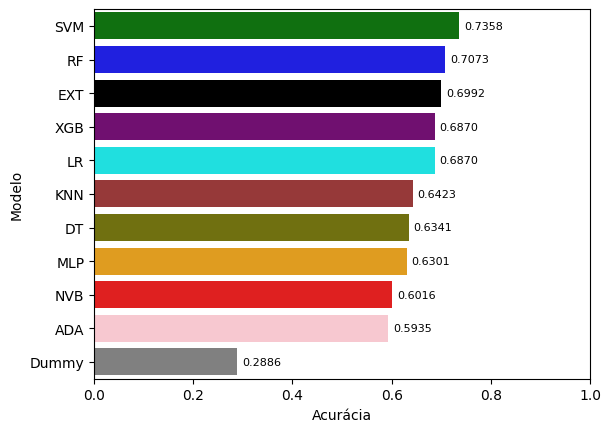

Modelo  Acurácia
2     SVM  0.735772
1      RF  0.707317
10    EXT  0.699187
4     XGB  0.686992
8      LR  0.686992
5     KNN  0.642276
9      DT  0.634146
3     MLP  0.630081
7     NVB  0.601626
6     ADA  0.593496
0   Dummy  0.288618

In [26]:
avalia_dif_modelos_cv(X_train3_re, y_train3_re, 5)

### Base 4

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.35      0.32        82
           1       0.31      0.18      0.23        82
           2       0.28      0.33      0.30        82

    accuracy                           0.29       246
   macro avg       0.29      0.29      0.28       246
weighted avg       0.29      0.29      0.28       246



---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.74      0.76        82
           1       0.60      0.61      0.61        82
           2       0.79      0.80      0.80        82

    accuracy                           0.72       246
   macro avg       0.72      0.72      0.72       246
weighted avg       0.72      0.72      0.72       246

---------------------------------------------
model_name:  SVC
Average Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.71      0.72        82
           1       0.59      0.55      0.57        82
           2       0.77      0.87      0.82        82

    accuracy                           0.71       246
   macro avg       0.70      0.71      0.70       246
weighted avg       0.70      0.71      0.70       246

-------------------------------

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_15344\2775261965.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


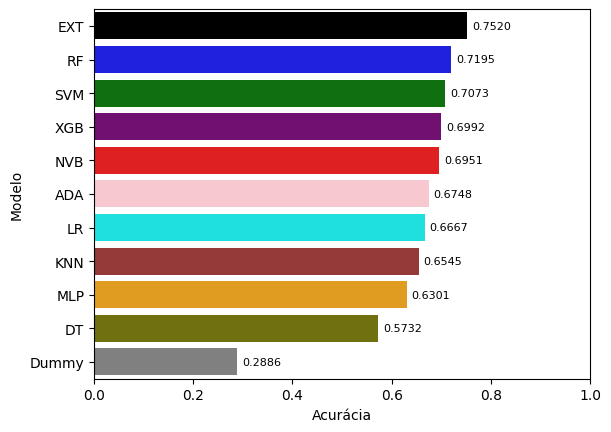

Modelo  Acurácia
10    EXT  0.752033
1      RF  0.719512
2     SVM  0.707317
4     XGB  0.699187
7     NVB  0.695122
6     ADA  0.674797
8      LR  0.666667
5     KNN  0.654472
3     MLP  0.630081
9      DT  0.573171
0   Dummy  0.288618

In [27]:
avalia_dif_modelos_cv(X_train4_re, y_train4_re, 5)

## Avaliando modelos sem Under-Sampling e com Normalização

### Base 1

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       181
           1       0.62      1.00      0.77       433
           2       0.00      0.00      0.00        82

    accuracy                           0.62       696
   macro avg       0.21      0.33      0.26       696
weighted avg       0.39      0.62      0.48       696

---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.07      0.11       181
           1       0.63      0.95      0.75       433
           2       0.00      0.00      0.00        82

    accuracy                           0.61       696
   macro avg       0.32      0.34      0.29       696
weighted avg       0.48      0.61      0.50       696

-------------------

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_15344\2775261965.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


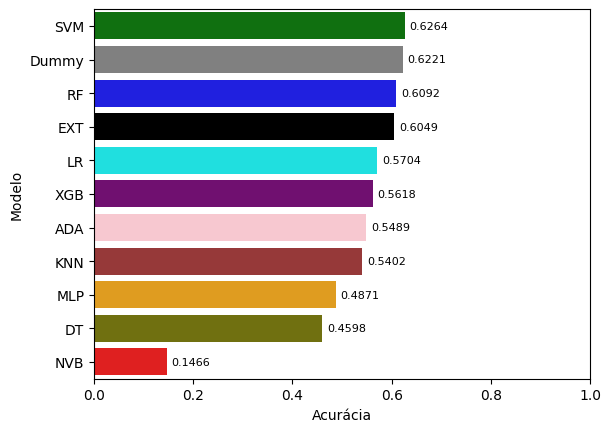

Modelo  Acurácia
2     SVM  0.626437
0   Dummy  0.622126
1      RF  0.609195
10    EXT  0.604885
8      LR  0.570402
4     XGB  0.561782
6     ADA  0.548851
5     KNN  0.540230
3     MLP  0.487069
9      DT  0.459770
7     NVB  0.146552

In [28]:
avalia_dif_modelos_cv(X_train1_norm, y_train1, 5)

### Base 2

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       181
           1       0.62      1.00      0.77       433
           2       0.00      0.00      0.00        82

    accuracy                           0.62       696
   macro avg       0.21      0.33      0.26       696
weighted avg       0.39      0.62      0.48       696

---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.51      0.60       181
           1       0.70      0.92      0.80       433
           2       0.67      0.02      0.05        82

    accuracy                           0.71       696
   macro avg       0.70      0.49      0.48       696
weighted avg       0.71      0.71      0.66       696

-------------------

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_15344\2775261965.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


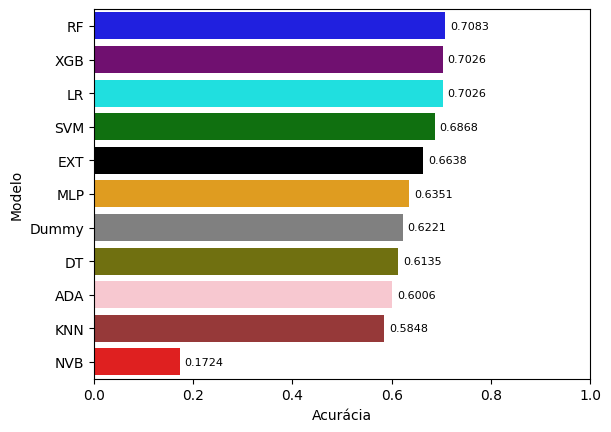

Modelo  Acurácia
1      RF  0.708333
4     XGB  0.702586
8      LR  0.702586
2     SVM  0.686782
10    EXT  0.663793
3     MLP  0.635057
0   Dummy  0.622126
9      DT  0.613506
6     ADA  0.600575
5     KNN  0.584770
7     NVB  0.172414

In [29]:
avalia_dif_modelos_cv(X_train2_norm, y_train2, 5)

### Base 3

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       181
           1       0.62      1.00      0.77       433
           2       0.00      0.00      0.00        82

    accuracy                           0.62       696
   macro avg       0.21      0.33      0.26       696
weighted avg       0.39      0.62      0.48       696



---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.57      0.65       181
           1       0.73      0.90      0.81       433
           2       0.70      0.23      0.35        82

    accuracy                           0.74       696
   macro avg       0.73      0.57      0.60       696
weighted avg       0.74      0.74      0.71       696

---------------------------------------------
model_name:  SVC
Average Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.49      0.59       181
           1       0.70      0.93      0.80       433
           2       0.60      0.04      0.07        82

    accuracy                           0.71       696
   macro avg       0.68      0.48      0.49       696
weighted avg       0.70      0.71      0.66       696

-------------------------------

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_15344\2775261965.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


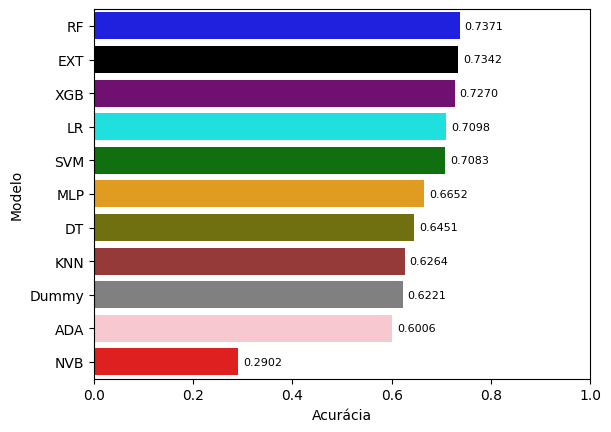

Modelo  Acurácia
1      RF  0.737069
10    EXT  0.734195
4     XGB  0.727011
8      LR  0.709770
2     SVM  0.708333
3     MLP  0.665230
9      DT  0.645115
5     KNN  0.626437
0   Dummy  0.622126
6     ADA  0.600575
7     NVB  0.290230

In [30]:
avalia_dif_modelos_cv(X_train3_norm, y_train3, 5)

### Base 4

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       181
           1       0.62      1.00      0.77       433
           2       0.00      0.00      0.00        82

    accuracy                           0.62       696
   macro avg       0.21      0.33      0.26       696
weighted avg       0.39      0.62      0.48       696



---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.57      0.65       181
           1       0.73      0.90      0.81       433
           2       0.70      0.23      0.35        82

    accuracy                           0.74       696
   macro avg       0.73      0.57      0.60       696
weighted avg       0.74      0.74      0.71       696

---------------------------------------------
model_name:  SVC
Average Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.49      0.59       181
           1       0.70      0.93      0.80       433
           2       0.60      0.04      0.07        82

    accuracy                           0.71       696
   macro avg       0.68      0.48      0.49       696
weighted avg       0.70      0.71      0.66       696

-------------------------------

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_15344\2775261965.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


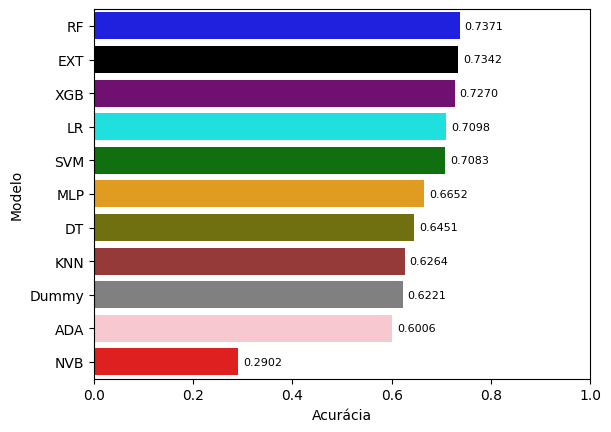

Modelo  Acurácia
1      RF  0.737069
10    EXT  0.734195
4     XGB  0.727011
8      LR  0.709770
2     SVM  0.708333
3     MLP  0.665230
9      DT  0.645115
5     KNN  0.626437
0   Dummy  0.622126
6     ADA  0.600575
7     NVB  0.290230

In [31]:
avalia_dif_modelos_cv(X_train3_norm, y_train3, 5)

## Tunning dos hiperparâmetros GridSearch

### Parametros para grid search

In [32]:
def get_param_grid(X,y):
    import math
    param_grids = [
        {
            'model': 'Random Forest',
            'params': {
                # Vetor linear inteiro, entre log2(numero_de_classes) e numero_de_features/2
                'max_depth': np.unique(np.linspace(math.log2(len(np.unique(y))), len(X.columns) // 2, 20, dtype=int)),
                # Vetor linear inteiro, de ln(numero de objetos no conjunto) -40 até ln(numero de objetos no conjunto) + 45
                'n_estimators': np.unique(np.maximum(np.linspace(math.log(len(X)) - 40, math.log(len(X)) + 45, 20, dtype=int),1)),
                # Vetor linear inteiro, numero features * 0.3 até numero features * 0.8
                'max_features': np.unique(np.linspace(int(len(X.columns) * 0.3), int(len(X.columns) * 0.8), 20, dtype=int)),
                'criterion': ['gini', 'entropy'],
                'bootstrap': [True, False]
            }
        },
        {
            #  C=2^−5,2^−3,…,2^15;γ=2^−15,2^−13,…,2^3
            'model': 'SVM',
            'params': {
                # 'C': np.linspace(2**-5, 2**15, 10),
                # 'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
                # 'gamma': np.linspace(2**-15, 2**3, 10),
                'C': [0.00001, 0.0001, 0.001,  0.01, 0.1, 1, 10, 100, 1000, 10000],
                'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
                'gamma': [10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 'scale', 1/len(X.columns)],
                'degree': np.linspace(2, 6, 6, dtype=int)
            }
        },
        {
            'model': 'MLP',
            'params': {
                'hidden_layer_sizes': [(neurons,) * layers for layers in range(1, 4) for neurons in range(len(X.columns) * 5, len(X.columns) * 10 + 1)],
                'learning_rate_init': np.linspace(0.0001, 1, 10),
                'momentum': np.linspace(0.1, 0.9, 10),
                'max_iter': np.linspace(400, 4000, 20, dtype=int)
            }
        },
        {
            'model': 'XGBoost',
            'params': {
                # Segue o mesmo padrão do Random Forest
                'max_depth': np.linspace(math.log2(len(np.unique(y))), len(X.columns) // 2, 20, dtype=int),
                'n_estimators': np.unique(np.maximum(np.linspace(math.log(len(X)) - 40, math.log(len(X)) + 45, 20, dtype=int),1)),
                'learning_rate': np.linspace(0.0001, 1, 10),
                'subsample': np.linspace(0.1, 1, 10),
                'gamma': np.linspace(0, 1, 10),
                'colsample_bytree': np.linspace(0.5, 1, 10)
            }
        },
        {
                'model': 'KNN',
                'params': {
                    'n_neighbors': np.linspace(1, 30, 15, dtype=int),
                    'weights': ['uniform', 'distance'],
                    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                    'p': [1, 2, 3, 4],
                    'leaf_size': np.linspace(1, 100, 20, dtype=int)
                }
        },
        {
            'model': 'ADA',
            'params': {
                'n_estimators': np.linspace(50, 500, 30, dtype=int),
                'learning_rate': np.linspace(0.001, 1, 30),
                'algorithm': ['SAMME', 'SAMME.R']
            }
        },
        {
            'model': 'NVB',
            'params': {
                'var_smoothing': np.linspace(1e-10, 1e1, 60)
            }
        },
        {
            'model': 'LR',
            'params': {
                'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                'C': np.linspace(0.001, 1, 15),
                'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                'max_iter': np.linspace(100, 2000, 15, dtype=int)
            }
        },
        {
            'model': 'DT',
            'params': {
                'criterion': ['gini', 'entropy'],
                'splitter': ['best', 'random'],
                'max_depth': np.unique(np.linspace(math.log2(len(np.unique(y))), len(X.columns) // 2, 20, dtype=int)),
                'min_samples_split': np.linspace(0.01, 1, 20),
                'min_samples_leaf': np.linspace(0.01, 0.5, 20)
            }
        },
        {
            'model': 'EXT',
            'params': {
                # Segue o mesmo padrão do Random Forest
                'max_depth': np.unique(np.linspace(math.log2(len(np.unique(y))), len(X.columns) // 2, 15, dtype=int)),
                'n_estimators': np.unique(np.maximum(np.linspace(math.log(len(X)) - 40, math.log(len(X)) + 45, 15, dtype=int),1)),
                'max_features': np.unique(np.linspace(int(len(X.columns) * 0.3), int(len(X.columns) * 0.8), 15, dtype=int)),
                'criterion': ['gini', 'entropy'],
                'bootstrap': [True, False]
            }
        }

    ]


        # Create a list of solver-penalty pairs that are compatible
    compatible_solver_penalty = [
        ('newton-cg', 'l2'),
        ('lbfgs', 'l2'),
        ('liblinear', 'l1'),
        ('liblinear', 'l2'),
        ('sag', 'l2'),
        ('saga', 'l1'),
        ('saga', 'l2'),
        ('saga', 'elasticnet'),
        ('newton-cg', 'none'),
        ('lbfgs', 'none'),
        ('sag', 'none'),
        ('saga', 'none')
    ]

    # Modify the 'LR' dictionary in your param_grid
    for grid in param_grids:
        if grid['model'] == 'LR':
            grid['params']['penalty'] = [penalty for penalty in grid['params']['penalty'] if ('saga', penalty) in compatible_solver_penalty]
            grid['params']['solver'] = [solver for solver in grid['params']['solver'] if (solver, 'elasticnet') in compatible_solver_penalty]
            if 'elasticnet' in grid['params']['penalty']:
                grid['params']['l1_ratio'] = np.linspace(0, 1, 10)
    return param_grids

#### A

In [33]:
#Definindo parametros:
#Definir os modelos e os grids de parâmetros
models = {
    'Random Forest': RandomForestClassifier(n_jobs=n_cpus, random_state=13),
    'SVM': SVC(random_state=13),
    'MLP': MLPClassifier(random_state=13),
    'XGBoost': XGBClassifier(n_jobs=n_cpus, random_state=13),
    'KNN': KNeighborsClassifier(n_jobs=n_cpus),
    'ADA': AdaBoostClassifier(random_state=13),
    'NVB': GaussianNB(),
    'LR': LogisticRegression(random_state=13, n_jobs=n_cpus, max_iter=1000),
    'DT': DecisionTreeClassifier(random_state=13),
    'EXT': ExtraTreesClassifier(random_state=13, n_jobs=n_cpus)
}

param_grids = [
    {
        'model': 'Random Forest',
        'params': {
            'n_estimators': [50, 100, 200, 300, 400, 500],
            'max_depth': [2, 5, 10, 15, 20 ],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2'],
            'n_jobs': [n_cpus]
        }
    },
    {
        #  C=2^−5,2^−3,…,2^15;γ=2^−15,2^−13,…,2^3
        # 'model': 'SVM',
        # 'params': {
        #     'C': [2**i for i in range(-5, 16, 2)],
        #     'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        #     'gamma': [2**i for i in range(-15, 4, 2)] + ['scale', 'auto'],
        #     'degree': np.linspace(2, 6, 4, dtype=int)
        # }

        'model': 'SVM',
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
            'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 'scale', 'auto']
        }
    },
    {
        'model': 'MLP',
        'params': {
            'hidden_layer_sizes': [(10,), (50,), (100,), (150,), (200,)],
            'activation': ['logistic', 'tanh', 'relu'],
            'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
            'learning_rate': ['constant', 'invscaling', 'adaptive']
        }
    },
    {
        'model': 'XGBoost',
        'params': {
            'n_estimators': [50, 100, 200, 300, 400, 500],
            'max_depth': [3, 5, 7, 9, 11, 13, 15, ],
            'learning_rate': [0.01, 0.1, 0.2, 0.3],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'n_jobs': [n_cpus]
        }
    }
    ,
    {
        'model': 'KNN',
        'params': {
            'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'leaf_size': [5,10, 20, 30, 40, 50],
            'p': [1, 2, 3, 4, 5, 6]
        }
    }
    ,
    {
        'model': 'ADA',
        'params': {
            'n_estimators': [50, 100, 200, 300, 400, 500],
            'learning_rate': [0.01, 0.1, 0.2, 0.3],
            'algorithm': ['SAMME', 'SAMME.R']
        }
    }
    ,
    {
        'model': 'NVB',
        'params': {
            'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05]
        }
    }
    ,
    {
        'model': 'LR',
        'params': {
            'penalty': ['l1', 'l2', 'elasticnet', 'none'],
            'C': [0.1, 1, 10, 100],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
            'max_iter': [50, 100, 200, 300, 400, 500],
            'n_jobs': [n_cpus]
        }
    }
    ,
    {
        'model': 'DT',
        'params': {
            'criterion': ['gini', 'entropy'],
            'splitter': ['best', 'random'],
            'max_depth': [None, 5, 10, 15, 20, ],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'sqrt', 'log2']
        }
    }
    ,
    {
        'model': 'EXT',
        'params': {
            'n_estimators': [50, 100, 200, 300, 400, 500],
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 5, 10, 15, 20, ],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'sqrt', 'log2'],
            'n_jobs': [n_cpus]
        }
    }
]

### Tunning dos modelos sem Random Under-Sampling

========================== Data  =================================

Tuning do modelo Random Forest iniciado...
Paramêtros sendo testados:
max_depth | [ 1  2  4  5  6  8  9 10 12 13 14 16 17 18 20 21 22 24 25 27]
n_estimators | [ 1  2  6 11 15 20 24 29 33 38 42 47 51]
max_features | [16 17 18 20 21 23 24 25 27 28 30 31 33 34 35 37 38 40 41 43]
criterion | ['gini', 'entropy']
bootstrap | [True, False]
Fitting 5 folds for each of 75 candidates, totalling 375 fits


Tempo de execução: 3.86s | Modelo: Random Forest | Acurácia: 0.6277027027027027
Parâmetros selecionados: {'n_estimators': 38, 'max_features': 23, 'max_depth': 1, 'criterion': 'gini', 'bootstrap': True}

Tuning do modelo SVM iniciado...
Paramêtros sendo testados:
C | [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
kernel | ['linear', 'rbf', 'poly', 'sigmoid']
gamma | [10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 'scale', 0.018518518518518517]
degree | [2 2 3 4 5 6]
Fitting 5 folds for each of 75 candidates, totalling 375 fits
Tempo de execução: 589.71s | Modelo: SVM | Acurácia: 0.633075933075933
Parâmetros selecionados: {'kernel': 'poly', 'gamma': 0.1, 'degree': 2, 'C': 0.01}

Tuning do modelo MLP iniciado...
Paramêtros sendo testados:
hidden_layer_sizes | [(270,), (271,), (272,), (273,), (274,), (275,), (276,), (277,), (278,), (279,), (280,), (281,), (282,), (283,), (284,), (285,), (286,), (287,), (288,), (289,), (290,), (291,), (292,), (293,), (294,), (295,), (296,), (297,), (29

c:\Programs\envs\BIC\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 60 is smaller than n_iter=75. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Tempo de execução: 12.63s | Modelo: LR | Acurácia: 0.6312741312741312
Parâmetros selecionados: {'solver': 'saga', 'penalty': 'elasticnet', 'max_iter': 914, 'l1_ratio': 0.4444444444444444, 'C': 0.07235714285714286}

Tuning do modelo DT iniciado...
Paramêtros sendo testados:
criterion | ['gini', 'entropy']
splitter | ['best', 'random']
max_depth | [ 1  2  4  5  6  8  9 10 12 13 14 16 17 18 20 21 22 24 25 27]
min_samples_split | [0.01       0.06210526 0.11421053 0.16631579 0.21842105 0.27052632
 0.32263158 0.37473684 0.42684211 0.47894737 0.53105263 0.58315789
 0.63526316 0.68736842 0.73947368 0.79157895 0.84368421 0.89578947
 0.94789474 1.        ]
min_samples_leaf | [0.01       0.03578947 0.06157895 0.08736842 0.11315789 0.13894737
 0.16473684 0.19052632 0.21631579 0.24210526 0.26789474 0.29368421
 0.31947368 0.34526316 0.37105263 0.39684211 0.42263158 0.44842105
 0.47421053 0.5       ]
Fitting 5 folds for each of 75 candidates, totalling 375 fits
Tempo de execução: 0.20s | Modelo: DT |

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_15344\3079024829.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


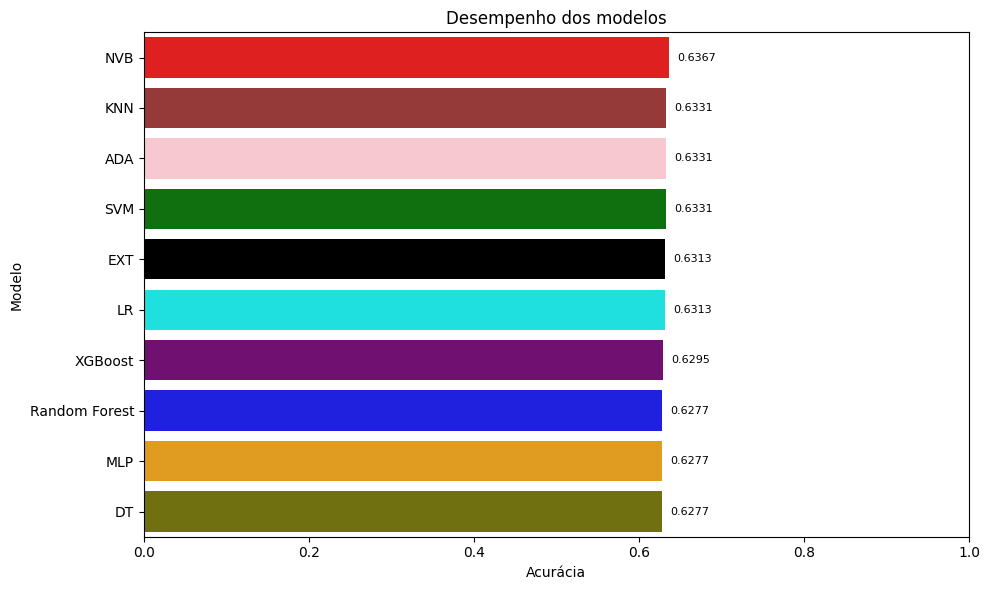



Melhor modelo: NVB | Acurácia: 0.6366795366795367

Tempo de execução total :1318.21s


C:\Users\Lucas José\AppData\Local\Temp\ipykernel_15344\215615391.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)


In [34]:
# Chamando função para cada uma das bases
print("========================== Data  =================================")
best_models1_Desb, best1_desb = perform_random_model_tuning(models, get_param_grid(X_train1, y_train1), "data1_desb", X_train1, y_train1)

========================== Data 2  =================================

Tuning do modelo Random Forest iniciado...
Paramêtros sendo testados:
max_depth | [ 1  2  4  5  6  8  9 10 12 13 14 16 17 18 20 21 22 24 25 27]
n_estimators | [ 1  2  6 11 15 20 24 29 33 38 42 47 51]
max_features | [16 17 18 20 21 23 24 26 27 29 30 32 33 35 36 38 39 41 42 44]
criterion | ['gini', 'entropy']
bootstrap | [True, False]
Fitting 5 folds for each of 75 candidates, totalling 375 fits


Tempo de execução: 2.81s | Modelo: Random Forest | Acurácia: 0.7571589446589446
Parâmetros selecionados: {'n_estimators': 42, 'max_features': 30, 'max_depth': 20, 'criterion': 'entropy', 'bootstrap': True}

Tuning do modelo SVM iniciado...
Paramêtros sendo testados:
C | [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
kernel | ['linear', 'rbf', 'poly', 'sigmoid']
gamma | [10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 'scale', 0.01818181818181818]
degree | [2 2 3 4 5 6]
Fitting 5 folds for each of 75 candidates, totalling 375 fits
Tempo de execução: 3012.74s | Modelo: SVM | Acurácia: 0.7625804375804376
Parâmetros selecionados: {'kernel': 'rbf', 'gamma': 'scale', 'degree': 2, 'C': 1000}

Tuning do modelo MLP iniciado...
Paramêtros sendo testados:
hidden_layer_sizes | [(275,), (276,), (277,), (278,), (279,), (280,), (281,), (282,), (283,), (284,), (285,), (286,), (287,), (288,), (289,), (290,), (291,), (292,), (293,), (294,), (295,), (296,), (297,), (298,), (299,), (300,), (301,), (30

c:\Programs\envs\BIC\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 60 is smaller than n_iter=75. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Tempo de execução: 13.83s | Modelo: LR | Acurácia: 0.7410392535392536
Parâmetros selecionados: {'solver': 'saga', 'penalty': 'elasticnet', 'max_iter': 235, 'l1_ratio': 0.5555555555555556, 'C': 0.2864285714285714}

Tuning do modelo DT iniciado...
Paramêtros sendo testados:
criterion | ['gini', 'entropy']
splitter | ['best', 'random']
max_depth | [ 1  2  4  5  6  8  9 10 12 13 14 16 17 18 20 21 22 24 25 27]
min_samples_split | [0.01       0.06210526 0.11421053 0.16631579 0.21842105 0.27052632
 0.32263158 0.37473684 0.42684211 0.47894737 0.53105263 0.58315789
 0.63526316 0.68736842 0.73947368 0.79157895 0.84368421 0.89578947
 0.94789474 1.        ]
min_samples_leaf | [0.01       0.03578947 0.06157895 0.08736842 0.11315789 0.13894737
 0.16473684 0.19052632 0.21631579 0.24210526 0.26789474 0.29368421
 0.31947368 0.34526316 0.37105263 0.39684211 0.42263158 0.44842105
 0.47421053 0.5       ]
Fitting 5 folds for each of 75 candidates, totalling 375 fits
Tempo de execução: 0.19s | Modelo: DT | 

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_15344\3079024829.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


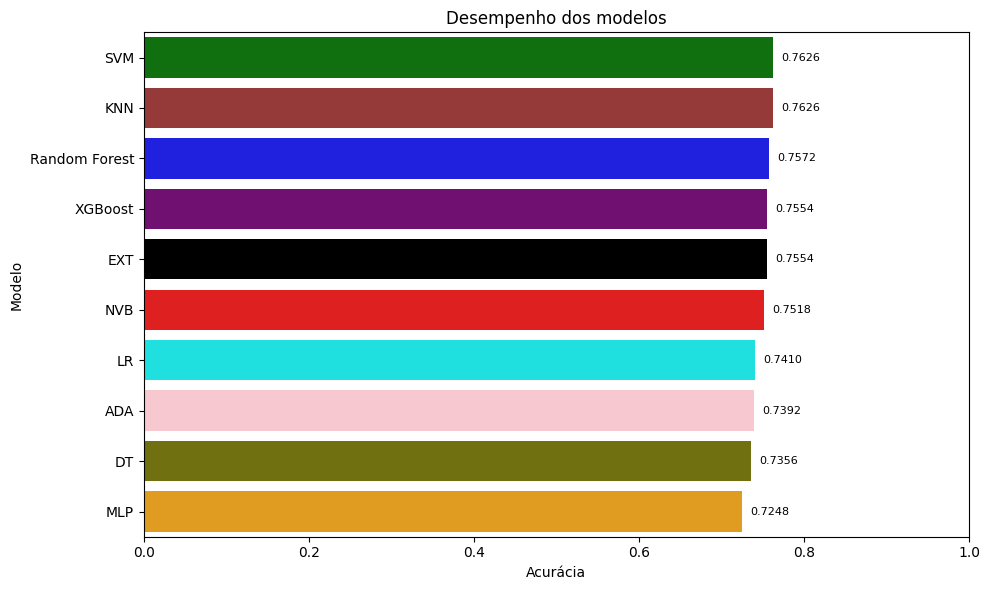



Melhor modelo: SVM | Acurácia: 0.7625804375804376

Tempo de execução total :3441.41s


C:\Users\Lucas José\AppData\Local\Temp\ipykernel_15344\215615391.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)


In [35]:
print("========================== Data 2  =================================")
best_models2_Desb, best2_desb = perform_random_model_tuning(models, get_param_grid(X_train2, y_train2), "data2_desb", X_train2, y_train2, X_test2, y_test2)

========================== Data 3  =================================

Tuning do modelo Random Forest iniciado...
Paramêtros sendo testados:
max_depth | [ 1  3  4  5  7  8 10 11 13 14 16 17 18 20 21 23 24 26 27 29]
n_estimators | [ 1  2  6 11 15 20 24 29 33 38 42 47 51]
max_features | [17 18 20 21 23 24 26 28 29 31 32 34 35 37 39 40 42 43 45 47]
criterion | ['gini', 'entropy']
bootstrap | [True, False]
Fitting 5 folds for each of 75 candidates, totalling 375 fits


Tempo de execução: 2.93s | Modelo: Random Forest | Acurácia: 0.7661518661518661
Parâmetros selecionados: {'n_estimators': 38, 'max_features': 31, 'max_depth': 23, 'criterion': 'gini', 'bootstrap': True}

Tuning do modelo SVM iniciado...
Paramêtros sendo testados:
C | [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
kernel | ['linear', 'rbf', 'poly', 'sigmoid']
gamma | [10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 'scale', 0.01694915254237288]
degree | [2 2 3 4 5 6]
Fitting 5 folds for each of 75 candidates, totalling 375 fits
Tempo de execução: 1693.03s | Modelo: SVM | Acurácia: 0.7661840411840413
Parâmetros selecionados: {'kernel': 'linear', 'gamma': 10, 'degree': 2, 'C': 0.001}

Tuning do modelo MLP iniciado...
Paramêtros sendo testados:
hidden_layer_sizes | [(295,), (296,), (297,), (298,), (299,), (300,), (301,), (302,), (303,), (304,), (305,), (306,), (307,), (308,), (309,), (310,), (311,), (312,), (313,), (314,), (315,), (316,), (317,), (318,), (319,), (320,), (321,), (322,),

c:\Programs\envs\BIC\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 60 is smaller than n_iter=75. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Tempo de execução: 15.44s | Modelo: LR | Acurácia: 0.7392696267696268
Parâmetros selecionados: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 1728, 'l1_ratio': 1.0, 'C': 0.07235714285714286}

Tuning do modelo DT iniciado...
Paramêtros sendo testados:
criterion | ['gini', 'entropy']
splitter | ['best', 'random']
max_depth | [ 1  3  4  5  7  8 10 11 13 14 16 17 18 20 21 23 24 26 27 29]
min_samples_split | [0.01       0.06210526 0.11421053 0.16631579 0.21842105 0.27052632
 0.32263158 0.37473684 0.42684211 0.47894737 0.53105263 0.58315789
 0.63526316 0.68736842 0.73947368 0.79157895 0.84368421 0.89578947
 0.94789474 1.        ]
min_samples_leaf | [0.01       0.03578947 0.06157895 0.08736842 0.11315789 0.13894737
 0.16473684 0.19052632 0.21631579 0.24210526 0.26789474 0.29368421
 0.31947368 0.34526316 0.37105263 0.39684211 0.42263158 0.44842105
 0.47421053 0.5       ]
Fitting 5 folds for each of 75 candidates, totalling 375 fits
Tempo de execução: 0.21s | Modelo: DT | Acurácia: 0.730164092

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_15344\3079024829.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


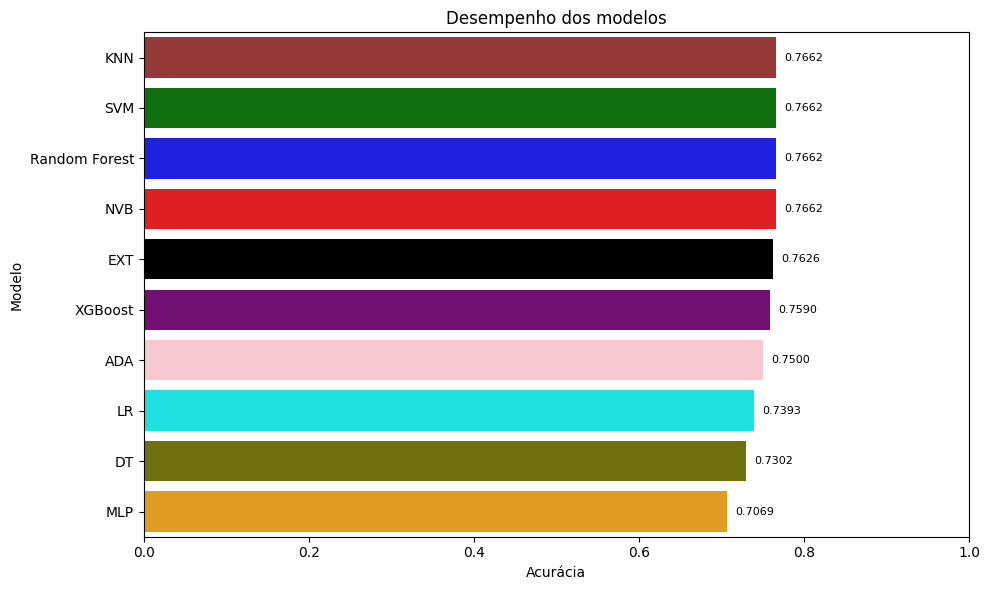



Melhor modelo: KNN | Acurácia: 0.7662162162162162

Tempo de execução total :2472.45s


C:\Users\Lucas José\AppData\Local\Temp\ipykernel_15344\215615391.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)


In [36]:
print("========================== Data 3  =================================")
best_models3_Desb, best3_desb = perform_random_model_tuning(models, get_param_grid(X_train3, y_train3), "data3_desb", X_train3, y_train3)

========================== Data 4  =================================

Tuning do modelo Random Forest iniciado...
Paramêtros sendo testados:
max_depth | [ 1  3  6  8 10 13 15 17 20 22 24 27 29 31 34 36 38 41 43 46]
n_estimators | [ 1  2  6 11 15 20 24 29 33 38 42 47 51]
max_features | [27 29 31 34 36 39 41 43 46 48 51 53 56 58 60 63 65 68 70 73]
criterion | ['gini', 'entropy']
bootstrap | [True, False]
Fitting 5 folds for each of 75 candidates, totalling 375 fits


Tempo de execução: 3.68s | Modelo: Random Forest | Acurácia: 0.7607786357786358
Parâmetros selecionados: {'n_estimators': 20, 'max_features': 70, 'max_depth': 3, 'criterion': 'gini', 'bootstrap': True}

Tuning do modelo SVM iniciado...
Paramêtros sendo testados:
C | [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
kernel | ['linear', 'rbf', 'poly', 'sigmoid']
gamma | [10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 'scale', 0.010869565217391304]
degree | [2 2 3 4 5 6]
Fitting 5 folds for each of 75 candidates, totalling 375 fits
Tempo de execução: 1563.27s | Modelo: SVM | Acurácia: 0.7392374517374517
Parâmetros selecionados: {'kernel': 'linear', 'gamma': 10, 'degree': 2, 'C': 0.001}

Tuning do modelo MLP iniciado...
Paramêtros sendo testados:
hidden_layer_sizes | [(460,), (461,), (462,), (463,), (464,), (465,), (466,), (467,), (468,), (469,), (470,), (471,), (472,), (473,), (474,), (475,), (476,), (477,), (478,), (479,), (480,), (481,), (482,), (483,), (484,), (485,), (486,), (487,),

c:\Programs\envs\BIC\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 60 is smaller than n_iter=75. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Tempo de execução: 21.49s | Modelo: LR | Acurácia: 0.7410070785070785
Parâmetros selecionados: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 1728, 'l1_ratio': 1.0, 'C': 0.07235714285714286}

Tuning do modelo DT iniciado...
Paramêtros sendo testados:
criterion | ['gini', 'entropy']
splitter | ['best', 'random']
max_depth | [ 1  3  6  8 10 13 15 17 20 22 24 27 29 31 34 36 38 41 43 46]
min_samples_split | [0.01       0.06210526 0.11421053 0.16631579 0.21842105 0.27052632
 0.32263158 0.37473684 0.42684211 0.47894737 0.53105263 0.58315789
 0.63526316 0.68736842 0.73947368 0.79157895 0.84368421 0.89578947
 0.94789474 1.        ]
min_samples_leaf | [0.01       0.03578947 0.06157895 0.08736842 0.11315789 0.13894737
 0.16473684 0.19052632 0.21631579 0.24210526 0.26789474 0.29368421
 0.31947368 0.34526316 0.37105263 0.39684211 0.42263158 0.44842105
 0.47421053 0.5       ]
Fitting 5 folds for each of 75 candidates, totalling 375 fits
Tempo de execução: 0.24s | Modelo: DT | Acurácia: 0.708606821

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_15344\3079024829.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


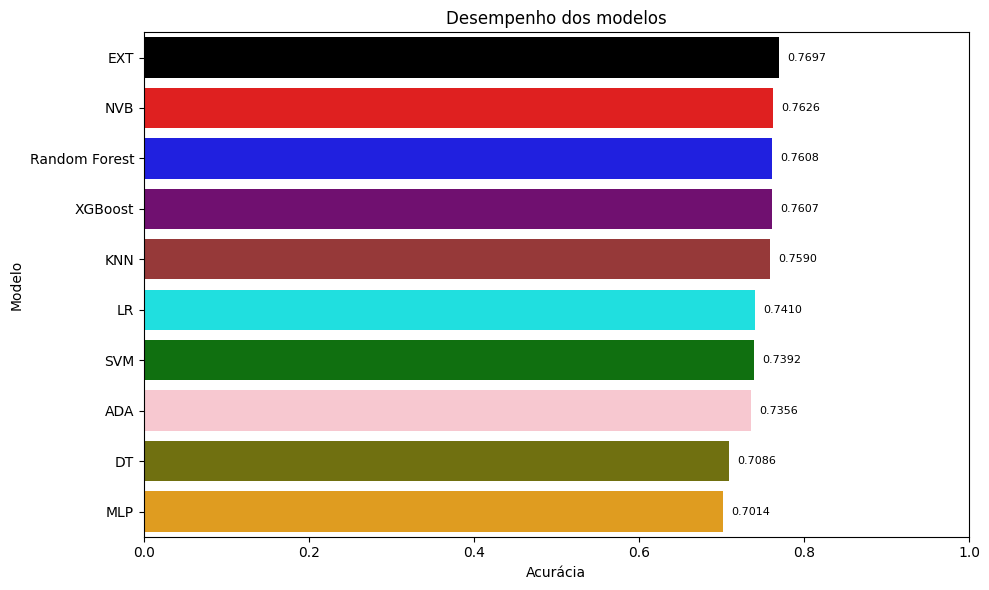



Melhor modelo: EXT | Acurácia: 0.7696750321750322

Tempo de execução total :2853.24s


C:\Users\Lucas José\AppData\Local\Temp\ipykernel_15344\215615391.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)


In [37]:
print("========================== Data 4  =================================")
best_models4_Desb, best4_desb = perform_random_model_tuning(models, get_param_grid(X_train4,y_train4), "data4_desb", X_train4, y_train4)

In [38]:
# Abrindo modelo salvo
best_model1_Desb = pickle.load(open("data1_desb_best_model.pkl", "rb"))
print("Modelo 1:")
print(best_model1_Desb.get_params())

best_model2_Desb = pickle.load(open("data2_desb_best_model.pkl", "rb"))
print("Modelo 2:")
print(best_model2_Desb.get_params())

best_model3_Desb = pickle.load(open("data3_desb_best_model.pkl", "rb"))
print("Modelo 3:")
print(best_model3_Desb.get_params())

best_model4_Desb = pickle.load(open("data4_desb_best_model.pkl", "rb"))
print("Modelo 4:")
print(best_model4_Desb.get_params())



Modelo 1:
{'priors': None, 'var_smoothing': 1.3559322034762713}
Modelo 2:
{'C': 1000, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 13, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Modelo 3:
{'algorithm': 'kd_tree', 'leaf_size': 100, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 16, 'n_neighbors': 15, 'p': 1, 'weights': 'distance'}
Modelo 4:
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 36, 'max_features': 36, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 16, 'oob_score': False, 'random_state': 13, 'verbose': 0, 'warm_start': False}


### Tunning dos modelos com Random Under-Sampling

========================== Data 1  =================================

Tuning do modelo Random Forest iniciado...
Paramêtros sendo testados:
max_depth | [ 1  2  4  5  6  8  9 10 12 13 14 16 17 18 20 21 22 24 25 27]
n_estimators | [ 1  5 10 14 19 23 28 32 37 41 46 50]
max_features | [16 17 18 20 21 23 24 25 27 28 30 31 33 34 35 37 38 40 41 43]
criterion | ['gini', 'entropy']
bootstrap | [True, False]
Fitting 5 folds for each of 75 candidates, totalling 375 fits


Tempo de execução: 2.38s | Modelo: Random Forest | Acurácia: 0.4798717948717949
Parâmetros selecionados: {'n_estimators': 19, 'max_features': 27, 'max_depth': 24, 'criterion': 'entropy', 'bootstrap': True}

Tuning do modelo SVM iniciado...
Paramêtros sendo testados:
C | [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
kernel | ['linear', 'rbf', 'poly', 'sigmoid']
gamma | [10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 'scale', 0.018518518518518517]
degree | [2 2 3 4 5 6]
Fitting 5 folds for each of 75 candidates, totalling 375 fits
Tempo de execução: 187.50s | Modelo: SVM | Acurácia: 0.43448717948717946
Parâmetros selecionados: {'kernel': 'rbf', 'gamma': 0.01, 'degree': 5, 'C': 10}

Tuning do modelo MLP iniciado...
Paramêtros sendo testados:
hidden_layer_sizes | [(270,), (271,), (272,), (273,), (274,), (275,), (276,), (277,), (278,), (279,), (280,), (281,), (282,), (283,), (284,), (285,), (286,), (287,), (288,), (289,), (290,), (291,), (292,), (293,), (294,), (295,), (296,), (297,),

c:\Programs\envs\BIC\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 60 is smaller than n_iter=75. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Tempo de execução: 0.34s | Modelo: NVB | Acurácia: 0.3983333333333333
Parâmetros selecionados: {'var_smoothing': 0.16949152552203392}

Tuning do modelo LR iniciado...
Paramêtros sendo testados:
penalty | ['l1', 'l2', 'elasticnet', 'none']
C | [0.001      0.07235714 0.14371429 0.21507143 0.28642857 0.35778571
 0.42914286 0.5005     0.57185714 0.64321429 0.71457143 0.78592857
 0.85728571 0.92864286 1.        ]
solver | ['saga']
max_iter | [ 100  235  371  507  642  778  914 1050 1185 1321 1457 1592 1728 1864
 2000]
l1_ratio | [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
Fitting 5 folds for each of 75 candidates, totalling 375 fits


c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Tempo de execução: 4.83s | Modelo: LR | Acurácia: 0.4088461538461539
Parâmetros selecionados: {'solver': 'saga', 'penalty': 'elasticnet', 'max_iter': 914, 'l1_ratio': 0.4444444444444444, 'C': 0.07235714285714286}

Tuning do modelo DT iniciado...
Paramêtros sendo testados:
criterion | ['gini', 'entropy']
splitter | ['best', 'random']
max_depth | [ 1  2  4  5  6  8  9 10 12 13 14 16 17 18 20 21 22 24 25 27]
min_samples_split | [0.01       0.06210526 0.11421053 0.16631579 0.21842105 0.27052632
 0.32263158 0.37473684 0.42684211 0.47894737 0.53105263 0.58315789
 0.63526316 0.68736842 0.73947368 0.79157895 0.84368421 0.89578947
 0.94789474 1.        ]
min_samples_leaf | [0.01       0.03578947 0.06157895 0.08736842 0.11315789 0.13894737
 0.16473684 0.19052632 0.21631579 0.24210526 0.26789474 0.29368421
 0.31947368 0.34526316 0.37105263 0.39684211 0.42263158 0.44842105
 0.47421053 0.5       ]
Fitting 5 folds for each of 75 candidates, totalling 375 fits
Tempo de execução: 0.33s | Modelo: DT | 

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_15344\3079024829.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


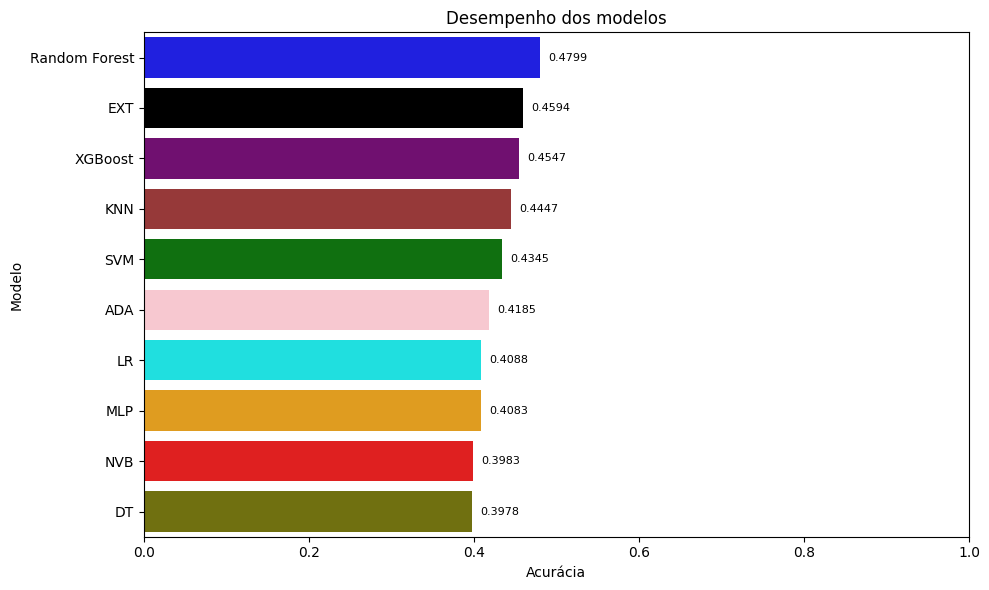



Melhor modelo: Random Forest | Acurácia: 0.4798717948717949

Tempo de execução total :329.05s


C:\Users\Lucas José\AppData\Local\Temp\ipykernel_15344\215615391.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)


In [39]:
# Chamando função para cada uma das bases
print("========================== Data 1  =================================")
best_models1, best1 = perform_random_model_tuning(models, get_param_grid(X_train1_re, y_train1_re), "data1", X_train1_re, y_train1_re)

========================== Data 2  =================================

Tuning do modelo Random Forest iniciado...
Paramêtros sendo testados:
max_depth | [ 1  3  4  5  7  8 10 11 13 14 16 17 18 20 21 23 24 26 27 29]
n_estimators | [ 1  5 10 14 19 23 28 32 37 41 46 50]
max_features | [17 18 20 21 23 24 26 28 29 31 32 34 35 37 39 40 42 43 45 47]
criterion | ['gini', 'entropy']
bootstrap | [True, False]
Fitting 5 folds for each of 75 candidates, totalling 375 fits


Tempo de execução: 2.20s | Modelo: Random Forest | Acurácia: 0.745
Parâmetros selecionados: {'n_estimators': 10, 'max_features': 45, 'max_depth': 3, 'criterion': 'entropy', 'bootstrap': True}

Tuning do modelo SVM iniciado...
Paramêtros sendo testados:
C | [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
kernel | ['linear', 'rbf', 'poly', 'sigmoid']
gamma | [10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 'scale', 0.01694915254237288]
degree | [2 2 3 4 5 6]
Fitting 5 folds for each of 75 candidates, totalling 375 fits
Tempo de execução: 1.68s | Modelo: SVM | Acurácia: 0.7247435897435898
Parâmetros selecionados: {'kernel': 'rbf', 'gamma': 1e-05, 'degree': 2, 'C': 10000}

Tuning do modelo MLP iniciado...
Paramêtros sendo testados:
hidden_layer_sizes | [(295,), (296,), (297,), (298,), (299,), (300,), (301,), (302,), (303,), (304,), (305,), (306,), (307,), (308,), (309,), (310,), (311,), (312,), (313,), (314,), (315,), (316,), (317,), (318,), (319,), (320,), (321,), (322,), (323,), (324,

c:\Programs\envs\BIC\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 60 is smaller than n_iter=75. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Tempo de execução: 0.32s | Modelo: NVB | Acurácia: 0.7344871794871795
Parâmetros selecionados: {'var_smoothing': 0.16949152552203392}

Tuning do modelo LR iniciado...
Paramêtros sendo testados:
penalty | ['l1', 'l2', 'elasticnet', 'none']
C | [0.001      0.07235714 0.14371429 0.21507143 0.28642857 0.35778571
 0.42914286 0.5005     0.57185714 0.64321429 0.71457143 0.78592857
 0.85728571 0.92864286 1.        ]
solver | ['saga']
max_iter | [ 100  235  371  507  642  778  914 1050 1185 1321 1457 1592 1728 1864
 2000]
l1_ratio | [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
Fitting 5 folds for each of 75 candidates, totalling 375 fits


c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Tempo de execução: 5.30s | Modelo: LR | Acurácia: 0.683974358974359
Parâmetros selecionados: {'solver': 'saga', 'penalty': 'none', 'max_iter': 235, 'l1_ratio': 0.1111111111111111, 'C': 0.1437142857142857}

Tuning do modelo DT iniciado...
Paramêtros sendo testados:
criterion | ['gini', 'entropy']
splitter | ['best', 'random']
max_depth | [ 1  3  4  5  7  8 10 11 13 14 16 17 18 20 21 23 24 26 27 29]
min_samples_split | [0.01       0.06210526 0.11421053 0.16631579 0.21842105 0.27052632
 0.32263158 0.37473684 0.42684211 0.47894737 0.53105263 0.58315789
 0.63526316 0.68736842 0.73947368 0.79157895 0.84368421 0.89578947
 0.94789474 1.        ]
min_samples_leaf | [0.01       0.03578947 0.06157895 0.08736842 0.11315789 0.13894737
 0.16473684 0.19052632 0.21631579 0.24210526 0.26789474 0.29368421
 0.31947368 0.34526316 0.37105263 0.39684211 0.42263158 0.44842105
 0.47421053 0.5       ]
Fitting 5 folds for each of 75 candidates, totalling 375 fits
Tempo de execução: 0.34s | Modelo: DT | Acurácia

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_15344\3079024829.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


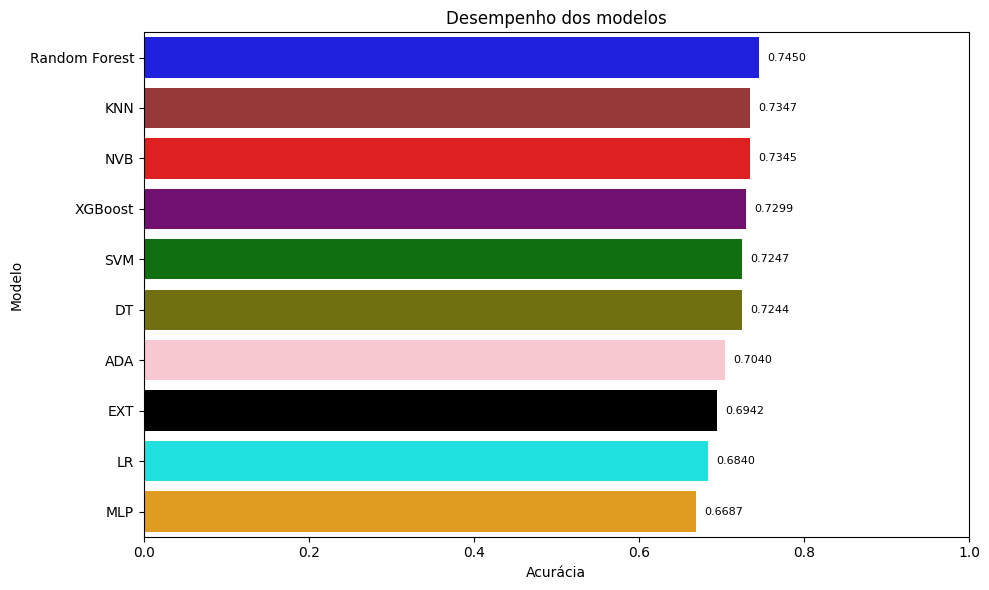



Melhor modelo: Random Forest | Acurácia: 0.745

Tempo de execução total :262.30s


C:\Users\Lucas José\AppData\Local\Temp\ipykernel_15344\215615391.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)


In [40]:
print("========================== Data 2  =================================")
best_models2, best2 = perform_random_model_tuning(models, get_param_grid(X_train3_re, y_train3_re), "data2", X_train2_re, y_train2_re)

========================== Data 3  =================================

Tuning do modelo Random Forest iniciado...
Paramêtros sendo testados:
max_depth | [ 1  3  4  5  7  8 10 11 13 14 16 17 18 20 21 23 24 26 27 29]
n_estimators | [ 1  5 10 14 19 23 28 32 37 41 46 50]
max_features | [17 18 20 21 23 24 26 28 29 31 32 34 35 37 39 40 42 43 45 47]
criterion | ['gini', 'entropy']
bootstrap | [True, False]
Fitting 5 folds for each of 75 candidates, totalling 375 fits


Tempo de execução: 2.27s | Modelo: Random Forest | Acurácia: 0.7297435897435898
Parâmetros selecionados: {'n_estimators': 50, 'max_features': 32, 'max_depth': 4, 'criterion': 'gini', 'bootstrap': False}

Tuning do modelo SVM iniciado...
Paramêtros sendo testados:
C | [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
kernel | ['linear', 'rbf', 'poly', 'sigmoid']
gamma | [10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 'scale', 0.01694915254237288]
degree | [2 2 3 4 5 6]
Fitting 5 folds for each of 75 candidates, totalling 375 fits
Tempo de execução: 0.50s | Modelo: SVM | Acurácia: 0.714102564102564
Parâmetros selecionados: {'kernel': 'linear', 'gamma': 10, 'degree': 2, 'C': 0.001}

Tuning do modelo MLP iniciado...
Paramêtros sendo testados:
hidden_layer_sizes | [(295,), (296,), (297,), (298,), (299,), (300,), (301,), (302,), (303,), (304,), (305,), (306,), (307,), (308,), (309,), (310,), (311,), (312,), (313,), (314,), (315,), (316,), (317,), (318,), (319,), (320,), (321,), (322,), (32

c:\Programs\envs\BIC\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 60 is smaller than n_iter=75. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Tempo de execução: 0.33s | Modelo: NVB | Acurácia: 0.7548717948717949
Parâmetros selecionados: {'var_smoothing': 0.6779661017881357}

Tuning do modelo LR iniciado...
Paramêtros sendo testados:
penalty | ['l1', 'l2', 'elasticnet', 'none']
C | [0.001      0.07235714 0.14371429 0.21507143 0.28642857 0.35778571
 0.42914286 0.5005     0.57185714 0.64321429 0.71457143 0.78592857
 0.85728571 0.92864286 1.        ]
solver | ['saga']
max_iter | [ 100  235  371  507  642  778  914 1050 1185 1321 1457 1592 1728 1864
 2000]
l1_ratio | [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
Fitting 5 folds for each of 75 candidates, totalling 375 fits


c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Tempo de execução: 5.63s | Modelo: LR | Acurácia: 0.6843589743589744
Parâmetros selecionados: {'solver': 'saga', 'penalty': 'l2', 'max_iter': 1185, 'l1_ratio': 0.2222222222222222, 'C': 0.001}

Tuning do modelo DT iniciado...
Paramêtros sendo testados:
criterion | ['gini', 'entropy']
splitter | ['best', 'random']
max_depth | [ 1  3  4  5  7  8 10 11 13 14 16 17 18 20 21 23 24 26 27 29]
min_samples_split | [0.01       0.06210526 0.11421053 0.16631579 0.21842105 0.27052632
 0.32263158 0.37473684 0.42684211 0.47894737 0.53105263 0.58315789
 0.63526316 0.68736842 0.73947368 0.79157895 0.84368421 0.89578947
 0.94789474 1.        ]
min_samples_leaf | [0.01       0.03578947 0.06157895 0.08736842 0.11315789 0.13894737
 0.16473684 0.19052632 0.21631579 0.24210526 0.26789474 0.29368421
 0.31947368 0.34526316 0.37105263 0.39684211 0.42263158 0.44842105
 0.47421053 0.5       ]
Fitting 5 folds for each of 75 candidates, totalling 375 fits
Tempo de execução: 0.34s | Modelo: DT | Acurácia: 0.694358974

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_15344\3079024829.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


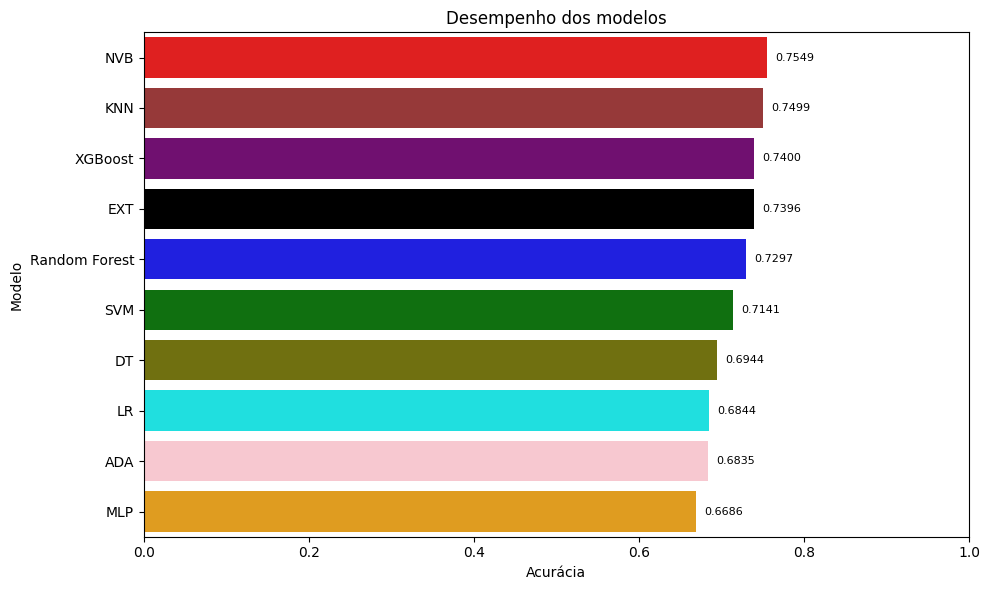



Melhor modelo: NVB | Acurácia: 0.7548717948717949

Tempo de execução total :181.50s


C:\Users\Lucas José\AppData\Local\Temp\ipykernel_15344\215615391.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)


In [41]:
print("========================== Data 3  =================================")
best_models3, best3 = perform_random_model_tuning(models, get_param_grid(X_train3_re, y_train3_re), "data3", X_train3_re, y_train3_re)

========================== Data 4  =================================

Tuning do modelo Random Forest iniciado...
Paramêtros sendo testados:
max_depth | [ 1  3  6  8 10 13 15 17 20 22 24 27 29 31 34 36 38 41 43 46]
n_estimators | [ 1  5 10 14 19 23 28 32 37 41 46 50]
max_features | [27 29 31 34 36 39 41 43 46 48 51 53 56 58 60 63 65 68 70 73]
criterion | ['gini', 'entropy']
bootstrap | [True, False]
Fitting 5 folds for each of 75 candidates, totalling 375 fits


Tempo de execução: 2.61s | Modelo: Random Forest | Acurácia: 0.7448717948717949
Parâmetros selecionados: {'n_estimators': 46, 'max_features': 58, 'max_depth': 41, 'criterion': 'entropy', 'bootstrap': True}

Tuning do modelo SVM iniciado...
Paramêtros sendo testados:
C | [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
kernel | ['linear', 'rbf', 'poly', 'sigmoid']
gamma | [10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 'scale', 0.010869565217391304]
degree | [2 2 3 4 5 6]
Fitting 5 folds for each of 75 candidates, totalling 375 fits
Tempo de execução: 0.54s | Modelo: SVM | Acurácia: 0.7294871794871793
Parâmetros selecionados: {'kernel': 'linear', 'gamma': 10, 'degree': 2, 'C': 0.001}

Tuning do modelo MLP iniciado...
Paramêtros sendo testados:
hidden_layer_sizes | [(460,), (461,), (462,), (463,), (464,), (465,), (466,), (467,), (468,), (469,), (470,), (471,), (472,), (473,), (474,), (475,), (476,), (477,), (478,), (479,), (480,), (481,), (482,), (483,), (484,), (485,), (486,), (487,)

c:\Programs\envs\BIC\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 60 is smaller than n_iter=75. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Tempo de execução: 0.45s | Modelo: NVB | Acurácia: 0.7452564102564103
Parâmetros selecionados: {'var_smoothing': 1.8644067797423731}

Tuning do modelo LR iniciado...
Paramêtros sendo testados:
penalty | ['l1', 'l2', 'elasticnet', 'none']
C | [0.001      0.07235714 0.14371429 0.21507143 0.28642857 0.35778571
 0.42914286 0.5005     0.57185714 0.64321429 0.71457143 0.78592857
 0.85728571 0.92864286 1.        ]
solver | ['saga']
max_iter | [ 100  235  371  507  642  778  914 1050 1185 1321 1457 1592 1728 1864
 2000]
l1_ratio | [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
Fitting 5 folds for each of 75 candidates, totalling 375 fits


c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Tempo de execução: 7.64s | Modelo: LR | Acurácia: 0.7142307692307692
Parâmetros selecionados: {'solver': 'saga', 'penalty': 'l2', 'max_iter': 1185, 'l1_ratio': 0.2222222222222222, 'C': 0.001}

Tuning do modelo DT iniciado...
Paramêtros sendo testados:
criterion | ['gini', 'entropy']
splitter | ['best', 'random']
max_depth | [ 1  3  6  8 10 13 15 17 20 22 24 27 29 31 34 36 38 41 43 46]
min_samples_split | [0.01       0.06210526 0.11421053 0.16631579 0.21842105 0.27052632
 0.32263158 0.37473684 0.42684211 0.47894737 0.53105263 0.58315789
 0.63526316 0.68736842 0.73947368 0.79157895 0.84368421 0.89578947
 0.94789474 1.        ]
min_samples_leaf | [0.01       0.03578947 0.06157895 0.08736842 0.11315789 0.13894737
 0.16473684 0.19052632 0.21631579 0.24210526 0.26789474 0.29368421
 0.31947368 0.34526316 0.37105263 0.39684211 0.42263158 0.44842105
 0.47421053 0.5       ]
Fitting 5 folds for each of 75 candidates, totalling 375 fits
Tempo de execução: 0.47s | Modelo: DT | Acurácia: 0.648076923

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_15344\3079024829.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


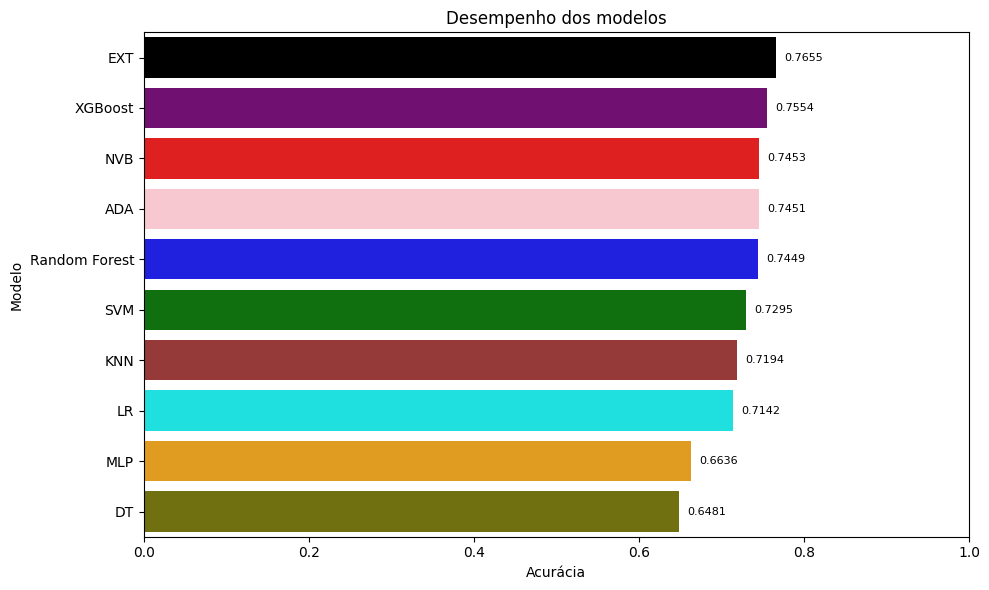



Melhor modelo: EXT | Acurácia: 0.7655128205128205

Tempo de execução total :210.16s


C:\Users\Lucas José\AppData\Local\Temp\ipykernel_15344\215615391.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)


In [42]:
print("========================== Data 4  =================================")
best_models4, best4 = perform_random_model_tuning(models, get_param_grid(X_train4_re, y_train4_re), "data4", X_train4_re, y_train4_re)

### Tunning dos modelos sem Random Under-Sampling e com Normalização

========================== Data 1  =================================

Tuning do modelo Random Forest iniciado...
Paramêtros sendo testados:
max_depth | [ 1  2  4  5  6  8  9 10 12 13 14 16 17 18 20 21 22 24 25 27]
n_estimators | [ 1  5 10 14 19 23 28 32 37 41 46 50]
max_features | [16 17 18 20 21 23 24 25 27 28 30 31 33 34 35 37 38 40 41 43]
criterion | ['gini', 'entropy']
bootstrap | [True, False]
Fitting 5 folds for each of 75 candidates, totalling 375 fits


Tempo de execução: 2.27s | Modelo: Random Forest | Acurácia: 0.4798717948717949
Parâmetros selecionados: {'n_estimators': 19, 'max_features': 27, 'max_depth': 24, 'criterion': 'entropy', 'bootstrap': True}

Tuning do modelo SVM iniciado...
Paramêtros sendo testados:
C | [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
kernel | ['linear', 'rbf', 'poly', 'sigmoid']
gamma | [10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 'scale', 0.018518518518518517]
degree | [2 2 3 4 5 6]
Fitting 5 folds for each of 75 candidates, totalling 375 fits
Tempo de execução: 187.60s | Modelo: SVM | Acurácia: 0.43448717948717946
Parâmetros selecionados: {'kernel': 'rbf', 'gamma': 0.01, 'degree': 5, 'C': 10}

Tuning do modelo MLP iniciado...
Paramêtros sendo testados:
hidden_layer_sizes | [(270,), (271,), (272,), (273,), (274,), (275,), (276,), (277,), (278,), (279,), (280,), (281,), (282,), (283,), (284,), (285,), (286,), (287,), (288,), (289,), (290,), (291,), (292,), (293,), (294,), (295,), (296,), (297,),

c:\Programs\envs\BIC\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 60 is smaller than n_iter=75. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Tempo de execução: 0.32s | Modelo: NVB | Acurácia: 0.3983333333333333
Parâmetros selecionados: {'var_smoothing': 0.16949152552203392}

Tuning do modelo LR iniciado...
Paramêtros sendo testados:
penalty | ['l1', 'l2', 'elasticnet', 'none']
C | [0.001      0.07235714 0.14371429 0.21507143 0.28642857 0.35778571
 0.42914286 0.5005     0.57185714 0.64321429 0.71457143 0.78592857
 0.85728571 0.92864286 1.        ]
solver | ['saga']
max_iter | [ 100  235  371  507  642  778  914 1050 1185 1321 1457 1592 1728 1864
 2000]
l1_ratio | [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
Fitting 5 folds for each of 75 candidates, totalling 375 fits


c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Tempo de execução: 4.83s | Modelo: LR | Acurácia: 0.4088461538461539
Parâmetros selecionados: {'solver': 'saga', 'penalty': 'elasticnet', 'max_iter': 914, 'l1_ratio': 0.4444444444444444, 'C': 0.07235714285714286}

Tuning do modelo DT iniciado...
Paramêtros sendo testados:
criterion | ['gini', 'entropy']
splitter | ['best', 'random']
max_depth | [ 1  2  4  5  6  8  9 10 12 13 14 16 17 18 20 21 22 24 25 27]
min_samples_split | [0.01       0.06210526 0.11421053 0.16631579 0.21842105 0.27052632
 0.32263158 0.37473684 0.42684211 0.47894737 0.53105263 0.58315789
 0.63526316 0.68736842 0.73947368 0.79157895 0.84368421 0.89578947
 0.94789474 1.        ]
min_samples_leaf | [0.01       0.03578947 0.06157895 0.08736842 0.11315789 0.13894737
 0.16473684 0.19052632 0.21631579 0.24210526 0.26789474 0.29368421
 0.31947368 0.34526316 0.37105263 0.39684211 0.42263158 0.44842105
 0.47421053 0.5       ]
Fitting 5 folds for each of 75 candidates, totalling 375 fits
Tempo de execução: 0.33s | Modelo: DT | 

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_15344\3079024829.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


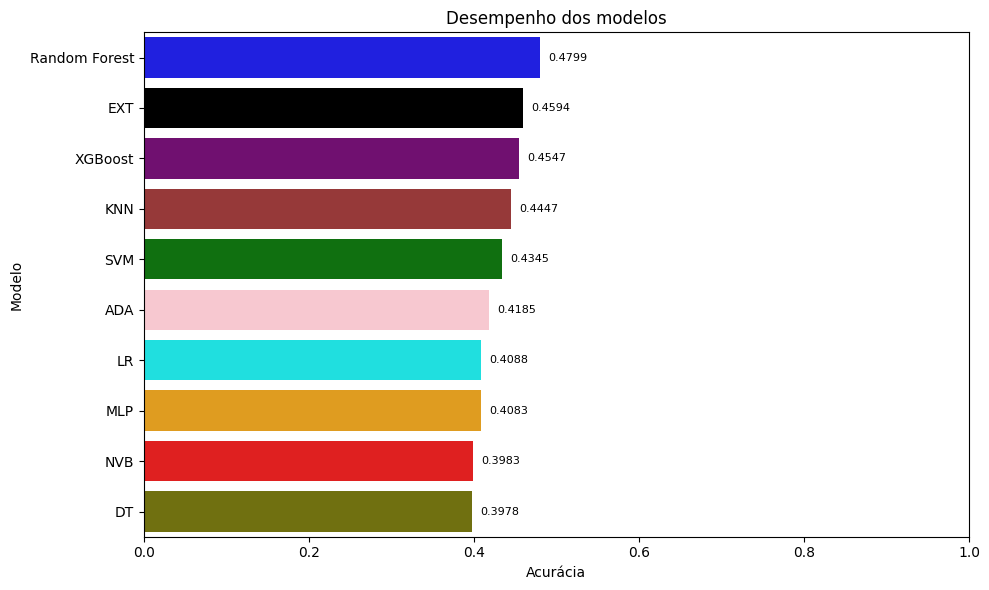



Melhor modelo: Random Forest | Acurácia: 0.4798717948717949

Tempo de execução total :327.43s


C:\Users\Lucas José\AppData\Local\Temp\ipykernel_15344\215615391.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)


In [43]:
print("========================== Data 1  =================================")
best_models1_norm, best1_norm = perform_random_model_tuning(models, get_param_grid(X_train1_re, y_train1_re), "data1_norm", X_train1_re, y_train1_re)

========================== Data 2  =================================

Tuning do modelo Random Forest iniciado...
Paramêtros sendo testados:
max_depth | [ 1  2  4  5  6  8  9 10 12 13 14 16 17 18 20 21 22 24 25 27]
n_estimators | [ 1  5 10 14 19 23 28 32 37 41 46 50]
max_features | [16 17 18 20 21 23 24 26 27 29 30 32 33 35 36 38 39 41 42 44]
criterion | ['gini', 'entropy']
bootstrap | [True, False]
Fitting 5 folds for each of 75 candidates, totalling 375 fits


Tempo de execução: 2.23s | Modelo: Random Forest | Acurácia: 0.7298717948717949
Parâmetros selecionados: {'n_estimators': 46, 'max_features': 33, 'max_depth': 4, 'criterion': 'entropy', 'bootstrap': True}

Tuning do modelo SVM iniciado...
Paramêtros sendo testados:
C | [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
kernel | ['linear', 'rbf', 'poly', 'sigmoid']
gamma | [10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 'scale', 0.01818181818181818]
degree | [2 2 3 4 5 6]
Fitting 5 folds for each of 75 candidates, totalling 375 fits
Tempo de execução: 1.70s | Modelo: SVM | Acurácia: 0.7247435897435898
Parâmetros selecionados: {'kernel': 'rbf', 'gamma': 1e-05, 'degree': 2, 'C': 10000}

Tuning do modelo MLP iniciado...
Paramêtros sendo testados:
hidden_layer_sizes | [(275,), (276,), (277,), (278,), (279,), (280,), (281,), (282,), (283,), (284,), (285,), (286,), (287,), (288,), (289,), (290,), (291,), (292,), (293,), (294,), (295,), (296,), (297,), (298,), (299,), (300,), (301,), (302,), 

c:\Programs\envs\BIC\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 60 is smaller than n_iter=75. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Tempo de execução: 0.33s | Modelo: NVB | Acurácia: 0.7344871794871795
Parâmetros selecionados: {'var_smoothing': 0.16949152552203392}

Tuning do modelo LR iniciado...
Paramêtros sendo testados:
penalty | ['l1', 'l2', 'elasticnet', 'none']
C | [0.001      0.07235714 0.14371429 0.21507143 0.28642857 0.35778571
 0.42914286 0.5005     0.57185714 0.64321429 0.71457143 0.78592857
 0.85728571 0.92864286 1.        ]
solver | ['saga']
max_iter | [ 100  235  371  507  642  778  914 1050 1185 1321 1457 1592 1728 1864
 2000]
l1_ratio | [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
Fitting 5 folds for each of 75 candidates, totalling 375 fits


c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Tempo de execução: 5.32s | Modelo: LR | Acurácia: 0.683974358974359
Parâmetros selecionados: {'solver': 'saga', 'penalty': 'none', 'max_iter': 235, 'l1_ratio': 0.1111111111111111, 'C': 0.1437142857142857}

Tuning do modelo DT iniciado...
Paramêtros sendo testados:
criterion | ['gini', 'entropy']
splitter | ['best', 'random']
max_depth | [ 1  2  4  5  6  8  9 10 12 13 14 16 17 18 20 21 22 24 25 27]
min_samples_split | [0.01       0.06210526 0.11421053 0.16631579 0.21842105 0.27052632
 0.32263158 0.37473684 0.42684211 0.47894737 0.53105263 0.58315789
 0.63526316 0.68736842 0.73947368 0.79157895 0.84368421 0.89578947
 0.94789474 1.        ]
min_samples_leaf | [0.01       0.03578947 0.06157895 0.08736842 0.11315789 0.13894737
 0.16473684 0.19052632 0.21631579 0.24210526 0.26789474 0.29368421
 0.31947368 0.34526316 0.37105263 0.39684211 0.42263158 0.44842105
 0.47421053 0.5       ]
Fitting 5 folds for each of 75 candidates, totalling 375 fits
Tempo de execução: 0.33s | Modelo: DT | Acurácia

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_15344\3079024829.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


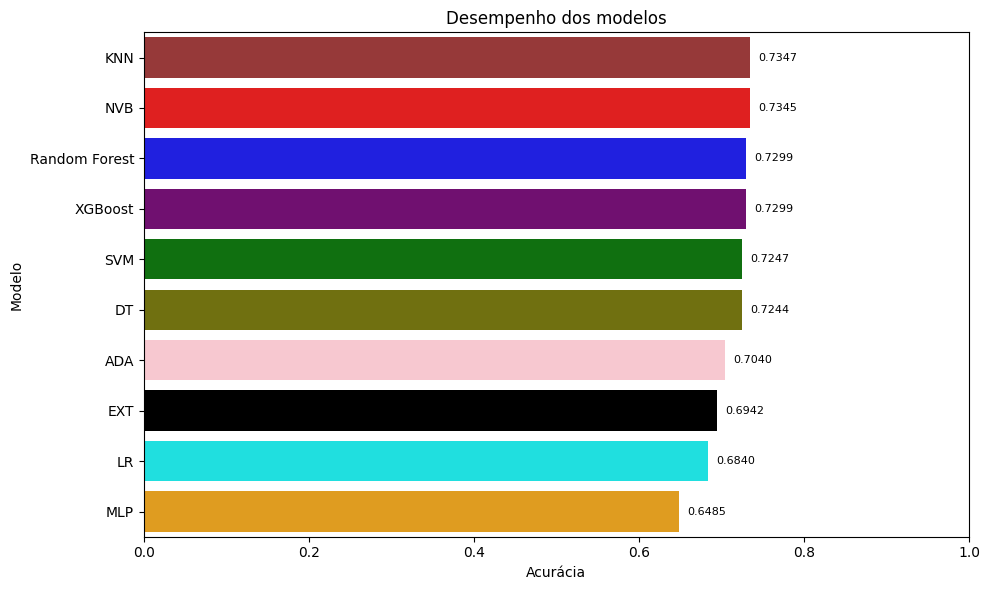



Melhor modelo: KNN | Acurácia: 0.7347435897435897

Tempo de execução total :197.45s


C:\Users\Lucas José\AppData\Local\Temp\ipykernel_15344\215615391.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)


In [44]:
print("========================== Data 2  =================================")
best_models2_norm, best2_norm = perform_random_model_tuning(models, get_param_grid(X_train2_re, y_train2_re), "data2_norm", X_train2_re, y_train2_re)

========================== Data 3  =================================

Tuning do modelo Random Forest iniciado...
Paramêtros sendo testados:
max_depth | [ 1  3  4  5  7  8 10 11 13 14 16 17 18 20 21 23 24 26 27 29]
n_estimators | [ 1  5 10 14 19 23 28 32 37 41 46 50]
max_features | [17 18 20 21 23 24 26 28 29 31 32 34 35 37 39 40 42 43 45 47]
criterion | ['gini', 'entropy']
bootstrap | [True, False]
Fitting 5 folds for each of 75 candidates, totalling 375 fits


Tempo de execução: 2.23s | Modelo: Random Forest | Acurácia: 0.7297435897435898
Parâmetros selecionados: {'n_estimators': 50, 'max_features': 32, 'max_depth': 4, 'criterion': 'gini', 'bootstrap': False}

Tuning do modelo SVM iniciado...
Paramêtros sendo testados:
C | [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
kernel | ['linear', 'rbf', 'poly', 'sigmoid']
gamma | [10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 'scale', 0.01694915254237288]
degree | [2 2 3 4 5 6]
Fitting 5 folds for each of 75 candidates, totalling 375 fits
Tempo de execução: 0.52s | Modelo: SVM | Acurácia: 0.714102564102564
Parâmetros selecionados: {'kernel': 'linear', 'gamma': 10, 'degree': 2, 'C': 0.001}

Tuning do modelo MLP iniciado...
Paramêtros sendo testados:
hidden_layer_sizes | [(295,), (296,), (297,), (298,), (299,), (300,), (301,), (302,), (303,), (304,), (305,), (306,), (307,), (308,), (309,), (310,), (311,), (312,), (313,), (314,), (315,), (316,), (317,), (318,), (319,), (320,), (321,), (322,), (32

c:\Programs\envs\BIC\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 60 is smaller than n_iter=75. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Tempo de execução: 0.33s | Modelo: NVB | Acurácia: 0.7548717948717949
Parâmetros selecionados: {'var_smoothing': 0.6779661017881357}

Tuning do modelo LR iniciado...
Paramêtros sendo testados:
penalty | ['l1', 'l2', 'elasticnet', 'none']
C | [0.001      0.07235714 0.14371429 0.21507143 0.28642857 0.35778571
 0.42914286 0.5005     0.57185714 0.64321429 0.71457143 0.78592857
 0.85728571 0.92864286 1.        ]
solver | ['saga']
max_iter | [ 100  235  371  507  642  778  914 1050 1185 1321 1457 1592 1728 1864
 2000]
l1_ratio | [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
Fitting 5 folds for each of 75 candidates, totalling 375 fits


c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Tempo de execução: 5.62s | Modelo: LR | Acurácia: 0.6843589743589744
Parâmetros selecionados: {'solver': 'saga', 'penalty': 'l2', 'max_iter': 1185, 'l1_ratio': 0.2222222222222222, 'C': 0.001}

Tuning do modelo DT iniciado...
Paramêtros sendo testados:
criterion | ['gini', 'entropy']
splitter | ['best', 'random']
max_depth | [ 1  3  4  5  7  8 10 11 13 14 16 17 18 20 21 23 24 26 27 29]
min_samples_split | [0.01       0.06210526 0.11421053 0.16631579 0.21842105 0.27052632
 0.32263158 0.37473684 0.42684211 0.47894737 0.53105263 0.58315789
 0.63526316 0.68736842 0.73947368 0.79157895 0.84368421 0.89578947
 0.94789474 1.        ]
min_samples_leaf | [0.01       0.03578947 0.06157895 0.08736842 0.11315789 0.13894737
 0.16473684 0.19052632 0.21631579 0.24210526 0.26789474 0.29368421
 0.31947368 0.34526316 0.37105263 0.39684211 0.42263158 0.44842105
 0.47421053 0.5       ]
Fitting 5 folds for each of 75 candidates, totalling 375 fits
Tempo de execução: 0.38s | Modelo: DT | Acurácia: 0.694358974

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_15344\3079024829.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


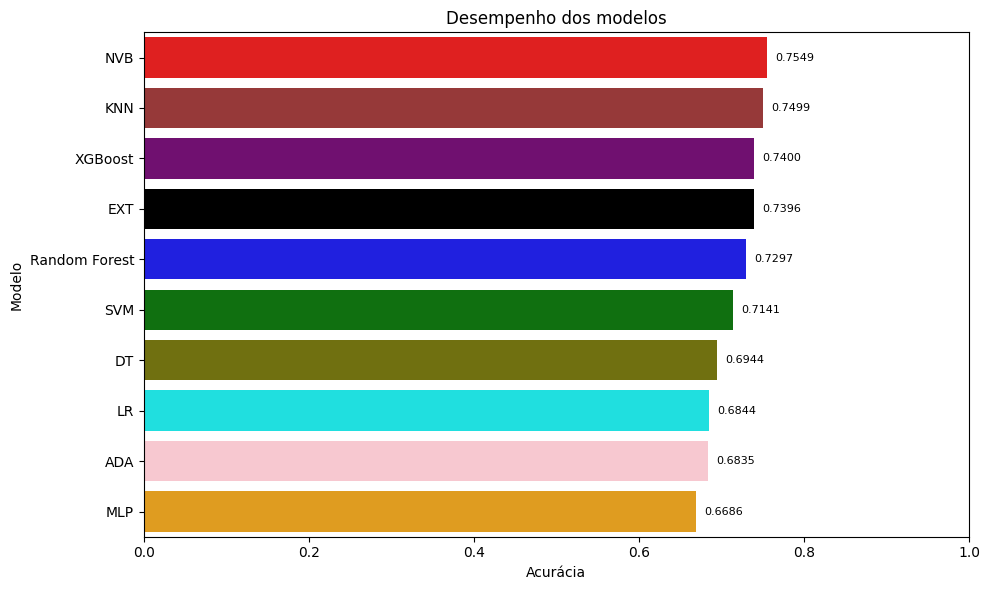



Melhor modelo: NVB | Acurácia: 0.7548717948717949

Tempo de execução total :181.17s


C:\Users\Lucas José\AppData\Local\Temp\ipykernel_15344\215615391.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)


In [45]:
print("========================== Data 3  =================================")
best_models3_norm, best3_norm = perform_random_model_tuning(models, get_param_grid(X_train3_re, y_train3_re), "data3_norm", X_train3_re, y_train3_re)

========================== Data 4  =================================

Tuning do modelo Random Forest iniciado...
Paramêtros sendo testados:
max_depth | [ 1  3  6  8 10 13 15 17 20 22 24 27 29 31 34 36 38 41 43 46]
n_estimators | [ 1  2  6 11 15 20 24 29 33 38 42 47 51]
max_features | [27 29 31 34 36 39 41 43 46 48 51 53 56 58 60 63 65 68 70 73]
criterion | ['gini', 'entropy']
bootstrap | [True, False]
Fitting 5 folds for each of 75 candidates, totalling 375 fits


Tempo de execução: 3.62s | Modelo: Random Forest | Acurácia: 0.7589768339768339
Parâmetros selecionados: {'n_estimators': 20, 'max_features': 70, 'max_depth': 3, 'criterion': 'gini', 'bootstrap': True}

Tuning do modelo SVM iniciado...
Paramêtros sendo testados:
C | [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
kernel | ['linear', 'rbf', 'poly', 'sigmoid']
gamma | [10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 'scale', 0.010869565217391304]
degree | [2 2 3 4 5 6]
Fitting 5 folds for each of 75 candidates, totalling 375 fits
Tempo de execução: 1437.58s | Modelo: SVM | Acurácia: 0.7445785070785071
Parâmetros selecionados: {'kernel': 'linear', 'gamma': 0.010869565217391304, 'degree': 2, 'C': 0.01}

Tuning do modelo MLP iniciado...
Paramêtros sendo testados:
hidden_layer_sizes | [(460,), (461,), (462,), (463,), (464,), (465,), (466,), (467,), (468,), (469,), (470,), (471,), (472,), (473,), (474,), (475,), (476,), (477,), (478,), (479,), (480,), (481,), (482,), (483,), (484,), (485,)

c:\Programs\envs\BIC\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 60 is smaller than n_iter=75. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Programs\envs\BIC\Lib\site-packages\sklearn\linear_model\_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Tempo de execução: 12.65s | Modelo: LR | Acurácia: 0.7463963963963964
Parâmetros selecionados: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 235, 'l1_ratio': 0.4444444444444444, 'C': 0.07235714285714286}

Tuning do modelo DT iniciado...
Paramêtros sendo testados:
criterion | ['gini', 'entropy']
splitter | ['best', 'random']
max_depth | [ 1  3  6  8 10 13 15 17 20 22 24 27 29 31 34 36 38 41 43 46]
min_samples_split | [0.01       0.06210526 0.11421053 0.16631579 0.21842105 0.27052632
 0.32263158 0.37473684 0.42684211 0.47894737 0.53105263 0.58315789
 0.63526316 0.68736842 0.73947368 0.79157895 0.84368421 0.89578947
 0.94789474 1.        ]
min_samples_leaf | [0.01       0.03578947 0.06157895 0.08736842 0.11315789 0.13894737
 0.16473684 0.19052632 0.21631579 0.24210526 0.26789474 0.29368421
 0.31947368 0.34526316 0.37105263 0.39684211 0.42263158 0.44842105
 0.47421053 0.5       ]
Fitting 5 folds for each of 75 candidates, totalling 375 fits
Tempo de execução: 0.21s | Modelo: DT | Acuráci

C:\Users\Lucas José\AppData\Local\Temp\ipykernel_15344\3079024829.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])


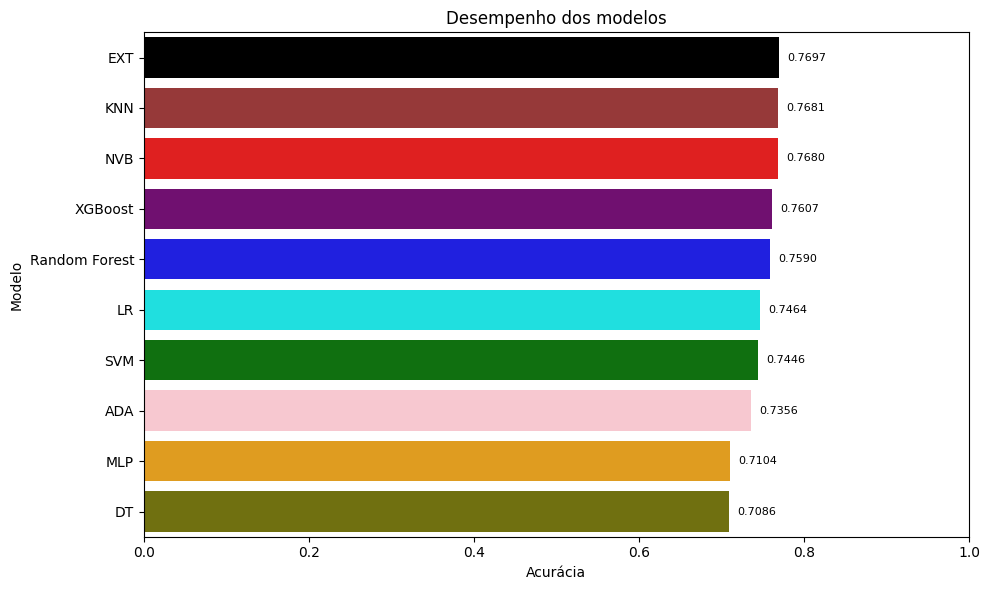



Melhor modelo: EXT | Acurácia: 0.7696750321750322

Tempo de execução total :2226.30s


C:\Users\Lucas José\AppData\Local\Temp\ipykernel_15344\215615391.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)


In [46]:
print("========================== Data 4  =================================")
best_models4_norm, best4_norm = perform_random_model_tuning(models, get_param_grid(X_train4_norm, y_train4), "data4_norm", X_train4_norm, y_train4)

## Avaliando os modelos com os melhores parâmetros

In [47]:
#Abrindo modleos 

### Selecionando o melhor modelo de cada base

#### Sem Random Under-Sampling

In [48]:
modelo1_desb = best1_desb
modelo1_desb

GaussianNB(var_smoothing=1.3559322034762713)

In [49]:
modelo2_desb = best2_desb
modelo2_desb

SVC(C=1000, degree=2, random_state=13)

In [50]:
modelo3_desb = best3_desb
modelo3_desb

KNeighborsClassifier(algorithm='kd_tree', leaf_size=100, n_jobs=16,
                     n_neighbors=15, p=1, weights='distance')

In [51]:
modelo4_desb = best4_desb
modelo4_desb

ExtraTreesClassifier(criterion='entropy', max_depth=36, max_features=36,
                     n_estimators=33, n_jobs=16, random_state=13)

#### Com Random Under-Sampling

In [52]:
modelo1 = best1
modelo1

RandomForestClassifier(criterion='entropy', max_depth=24, max_features=27,
                       n_estimators=19, n_jobs=16, random_state=13)

In [53]:
modelo2 = best2
modelo2

RandomForestClassifier(criterion='entropy', max_depth=3, max_features=45,
                       n_estimators=10, n_jobs=16, random_state=13)

In [54]:
modelo3 = best3
modelo3

GaussianNB(var_smoothing=0.6779661017881357)

In [55]:
modelo4 = best4
modelo4

ExtraTreesClassifier(bootstrap=True, criterion='entropy', max_depth=20,
                     max_features=30, n_estimators=38, n_jobs=16,
                     random_state=13)

#### Sem Random Under-Sampling e com Normalização

In [56]:
modelo1_norm = best1_norm
modelo1_norm

RandomForestClassifier(criterion='entropy', max_depth=24, max_features=27,
                       n_estimators=19, n_jobs=16, random_state=13)

In [57]:
modelo2_norm = best2_norm
modelo2_norm

KNeighborsClassifier(leaf_size=1, n_jobs=16, n_neighbors=19, weights='distance')

In [58]:
modelo3_norm = best3_norm
modelo3_norm

GaussianNB(var_smoothing=0.6779661017881357)

In [59]:
modelo4_norm = best4_norm
modelo4_norm

ExtraTreesClassifier(criterion='entropy', max_depth=36, max_features=36,
                     n_estimators=33, n_jobs=16, random_state=13)

### Salvando os modelos 

In [60]:
with open('modelo1_desb.pkl', 'wb') as f:
   pickle.dump(modelo1_desb, f)
with open('modelo2_desb.pkl', 'wb') as f:
   pickle.dump(modelo2_desb, f)
with open('modelo3_desb.pkl', 'wb') as f:
   pickle.dump(modelo3_desb, f)
with open('modelo4_desb.pkl', 'wb') as f:
   pickle.dump(modelo4_desb, f)

with open('modelo1.pkl', 'wb') as f:
   pickle.dump(modelo1, f)
with open('modelo2.pkl', 'wb') as f:
   pickle.dump(modelo2, f)
with open('modelo3.pkl', 'wb') as f:
   pickle.dump(modelo3, f)
with open('modelo4.pkl', 'wb') as f:
   pickle.dump(modelo4, f)

with open('modelo1_norm.pkl', 'wb') as f:
   pickle.dump(modelo1_norm, f)
with open('modelo2_norm.pkl', 'wb') as f:
   pickle.dump(modelo2_norm, f)
with open('modelo3_norm.pkl', 'wb') as f:
   pickle.dump(modelo3_norm, f)
with open('modelo4_norm.pkl', 'wb') as f:
   pickle.dump(modelo4_norm, f)


### [Abrir modelos pickle]

In [61]:
# # Importando modelos pickl
with open('modelo1_desb.pkl', 'rb') as file:
    modelo1_desb = pickle.load(file)
    print(f'Modelo1_desb = \n{modelo1_desb}')
with open('modelo2_desb.pkl', 'rb') as file:
    modelo2_desb = pickle.load(file)
    print(f'Modelo2_desb = \n{modelo2_desb}')
with open('modelo3_desb.pkl', 'rb') as file:
    modelo3_desb = pickle.load(file)
    print(f'Modelo3_desb = \n{modelo3_desb}')
with open('modelo4_desb.pkl', 'rb') as file:
    modelo4_desb = pickle.load(file)
    print(f'Modelo4_desb = \n{modelo4_desb}')

with open('modelo1.pkl', 'rb') as file:
    modelo1 = pickle.load(file)
    print(f'Modelo1 = \n{modelo1}')
with open('modelo2.pkl', 'rb') as file:
    modelo2 = pickle.load(file)
    print(f'Modelo2 = \n{modelo2}')
with open('modelo3.pkl', 'rb') as file:
    modelo3 = pickle.load(file)
    print(f'Modelo3 = \n{modelo3}')
with open('modelo4.pkl', 'rb') as file:
    modelo4 = pickle.load(file)
    print(f'Modelo4 = \n{modelo4}')

with open('modelo1_norm.pkl', 'rb') as file:
    modelo1_norm = pickle.load(file)
    print(f'Modelo1_norm = \n{modelo1_norm}')
with open('modelo2_norm.pkl', 'rb') as file:
    modelo2_norm = pickle.load(file)
    print(f'Modelo2_norm = \n{modelo2_norm}')
with open('modelo3_norm.pkl', 'rb') as file:
    modelo3_norm = pickle.load(file)
    print(f'Modelo3_norm = \n{modelo3_norm}')
with open('modelo4_norm.pkl', 'rb') as file:
    modelo4_norm = pickle.load(file)
    print(f'Modelo4_norm = \n{modelo4_norm}')



Modelo1_desb = 
GaussianNB(var_smoothing=1.3559322034762713)
Modelo2_desb = 
SVC(C=1000, degree=2, random_state=13)
Modelo3_desb = 
KNeighborsClassifier(algorithm='kd_tree', leaf_size=100, n_jobs=16,
                     n_neighbors=15, p=1, weights='distance')
Modelo4_desb = 
ExtraTreesClassifier(criterion='entropy', max_depth=36, max_features=36,
                     n_estimators=33, n_jobs=16, random_state=13)
Modelo1 = 
RandomForestClassifier(criterion='entropy', max_depth=24, max_features=27,
                       n_estimators=19, n_jobs=16, random_state=13)
Modelo2 = 
RandomForestClassifier(criterion='entropy', max_depth=3, max_features=45,
                       n_estimators=10, n_jobs=16, random_state=13)
Modelo3 = 
GaussianNB(var_smoothing=0.6779661017881357)
Modelo4 = 
ExtraTreesClassifier(bootstrap=True, criterion='entropy', max_depth=20,
                     max_features=30, n_estimators=38, n_jobs=16,
                     random_state=13)
Modelo1_norm = 
RandomForestClass

## Feature Selection

In [62]:
updt_maxfeature(modelo1_desb)
updt_maxfeature(modelo2_desb)
updt_maxfeature(modelo3_desb)
updt_maxfeature(modelo4_desb)

updt_maxfeature(modelo1)
updt_maxfeature(modelo2)
updt_maxfeature(modelo3)
updt_maxfeature(modelo4)

updt_maxfeature(modelo1_norm)
updt_maxfeature(modelo2_norm)
updt_maxfeature(modelo3_norm)
updt_maxfeature(modelo4_norm)

### Aplicando SBFS e SFFS

#### Feature Selection nas bases sem Random Under-Sampling

##### Base 1

========================== Data 1  =================================
SBFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  51 out of  54 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  54 out of  54 | elapsed:    0.0s finished

[2024-01-05 04:05:19] Features: 53/1 -- score: 0.627852004110997[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  49 out of  53 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  53 out of  53 | elapsed:    0.0s finished

[2024-01-05 04:05:19] Features: 52/1 -- score: 0.627852004110997[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  48 out of  52 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  52 out of  52 | elapsed:    0.0s finish

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.9s finished

[2024-01-05 04:05:23] Features: 50/1 -- score: 0.627852004110997[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=16)]: Done  45 out of  50 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.9s finished

[2024-01-05 04:05:25] Features: 49/1 -- score: 0.627852004110997[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.2s
[Parallel(n_jobs=16)]: Done  43 out of  49 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  49 out of  49 | elapsed:    1.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers

SFFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  51 out of  54 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  54 out of  54 | elapsed:    0.0s finished

[2024-01-05 04:06:05] Features: 1/54 -- score: 0.627852004110997[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  49 out of  53 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  53 out of  53 | elapsed:    0.0s finished

[2024-01-05 04:06:05] Features: 2/54 -- score: 0.627852004110997[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  48 out of  52 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  52 out of  52 | elapsed:    0.0s finish

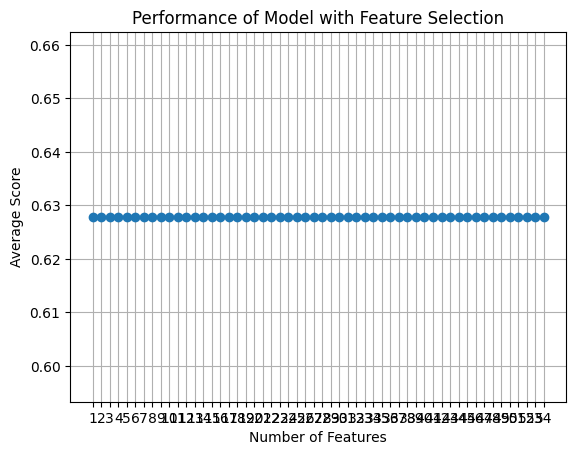

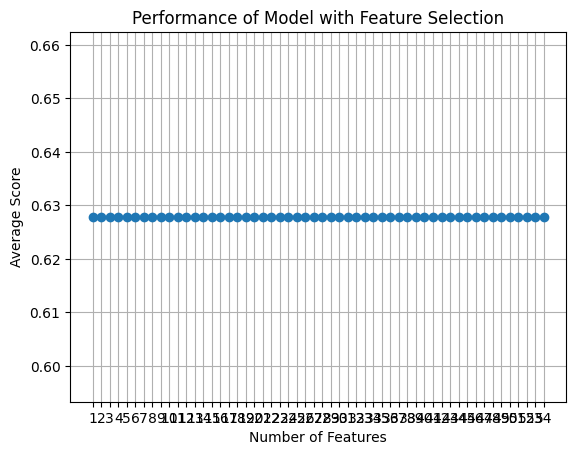

In [63]:
print("========================== Data 1  =================================")
print("SBFS")
slt_sbfs_features1_desb, score1_sbfs_desb = perform_feature_selection(X_train1, y_train1, modelo1_desb, "data1_desb", 'SBFS', 5)
print("SFFS")
slt_sffs_features1_desb, score1_sffs_desb = perform_feature_selection(X_train1, y_train1, modelo1_desb, "data1_desb", 'SFFS', 5)

In [64]:
# Imprimindo as features selecionadas e a melhor acurácia
print("Features selecionadas SBFS:")
print(slt_sbfs_features1_desb)
print(f"Acurácia: {score1_sbfs_desb}")
print("Features selecionadas SFFS:")
print(slt_sffs_features1_desb)
print(f"Acurácia: {score1_sffs_desb}")

Features selecionadas SBFS:
('B', 'C', 'F', 'H', 'L', 'M', 'N', 'O', 'U', 'AC', 'AD', 'AE', 'AN', 'AO', 'AP', 'AR', 'AS', 'AT', 'AU', 'AV', 'AW', 'AX', 'AY', 'AZ', 'BD', 'BO', 'BP', 'D_1.0', 'D_2.0', 'D_3.0', 'D_4.0', 'D_5.0', 'E_1.0', 'E_2.0', 'E_3.0', 'E_4.0', 'I_1.0', 'I_2.0', 'I_3.0', 'I_4.0', 'J_1.0', 'J_2.0', 'J_3.0', 'J_4.0', 'J_5.0', 'AA_1.0', 'AA_2.0', 'AA_3.0', 'AA_4.0', 'AB_0.0', 'AB_1.0', 'AB_2.0', 'AB_3.0', 'AB_4.0')
Acurácia: 0.627852004110997
Features selecionadas SFFS:
('C',)
Acurácia: 0.627852004110997


##### Base 2

========================== Data 2  =================================
SBFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  52 out of  55 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  55 out of  55 | elapsed:    0.6s finished

[2024-01-05 04:06:52] Features: 54/1 -- score: 0.7442959917780063[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  51 out of  54 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  54 out of  54 | elapsed:    0.5s finished

[2024-01-05 04:06:53] Features: 53/1 -- score: 0.7486022610483043[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  49 out of  53 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  53 out of  53 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent worker

SFFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  52 out of  55 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  55 out of  55 | elapsed:    4.6s finished

[2024-01-05 04:09:39] Features: 1/55 -- score: 0.7543576567317574[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  51 out of  54 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  54 out of  54 | elapsed:    0.8s finished

[2024-01-05 04:09:40] Features: 2/55 -- score: 0.7500000000000001[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  49 out of  53 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  53 out of  53 | elapsed:    0.7s fini

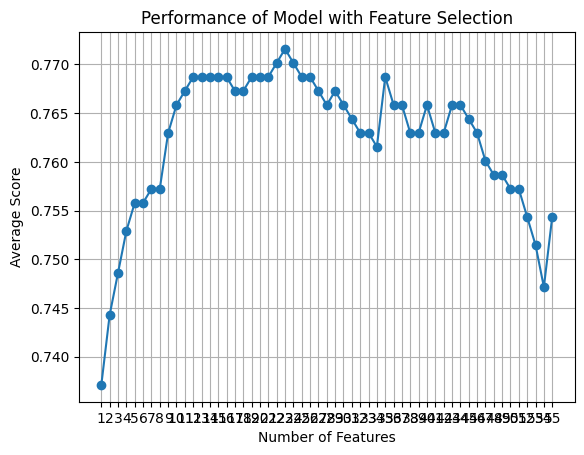

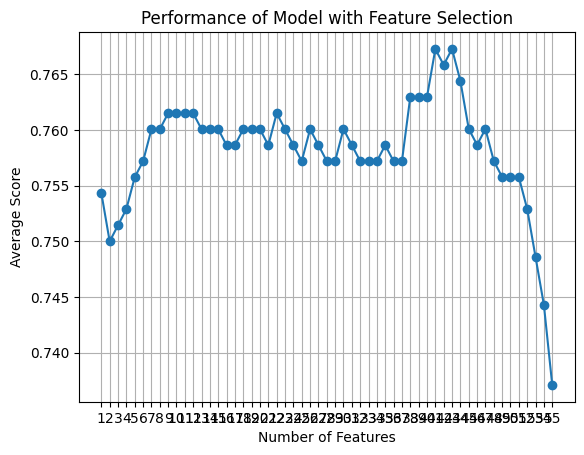

In [65]:
print("========================== Data 2  =================================")
print("SBFS")
slt_sbfs_features2_desb, score2_sbfs_desb = perform_feature_selection(X_train2, y_train2, modelo2_desb, "data2_desb", 'SBFS', 5)
print("SFFS")
slt_sffs_features2_desb, score2_sffs_desb = perform_feature_selection(X_train2, y_train2, modelo2_desb, "data2_desb", 'SFFS', 5)

In [66]:
print("Features selecionadas SBFS:")
print(slt_sbfs_features2_desb)
print(f"Acurácia: {score2_sbfs_desb}")
print("Features selecionadas SFFS:")
print(slt_sffs_features2_desb)
print(f"Acurácia: {score2_sffs_desb}")

Features selecionadas SBFS:
('B', 'C', 'F', 'H', 'M', 'N', 'U', 'AD', 'AE', 'AN', 'AO', 'AP', 'AT', 'AU', 'AV', 'AW', 'AX', 'AY', 'AZ', 'BO', 'BP', 'D_1.0', 'D_2.0', 'D_3.0', 'E_3.0', 'I_3.0', 'I_4.0', 'J_1.0', 'J_4.0', 'AA_1.0', 'AA_4.0', 'AB_3.0', '171')
Acurácia: 0.7715827338129496
Features selecionadas SFFS:
('B', 'F', 'H', 'L', 'M', 'N', 'O', 'AC', 'AD', 'AN', 'AO', 'AR', 'AS', 'AT', 'AU', 'AW', 'AX', 'BD', 'BO', 'D_1.0', 'D_4.0', 'D_5.0', 'E_1.0', 'E_2.0', 'E_3.0', 'E_4.0', 'I_1.0', 'I_2.0', 'I_3.0', 'I_4.0', 'J_1.0', 'J_2.0', 'J_3.0', 'J_4.0', 'J_5.0', 'AA_2.0', 'AA_4.0', 'AB_0.0', 'AB_1.0', 'AB_2.0', 'AB_3.0', 'AB_4.0', '171')
Acurácia: 0.7672970195272354


##### Base 3

========================== Data 3  =================================
SBFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done  59 out of  59 | elapsed:    0.4s finished

[2024-01-05 04:13:08] Features: 58/1 -- score: 0.7558067831449127[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  58 out of  58 | elapsed:    0.4s finished

[2024-01-05 04:13:08] Features: 57/1 -- score: 0.7601233299075025[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  55 out of  57 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  57 out of  57 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.9s finished

[2024-01-05 04:13:10] Features: 56/1 -- score: 0.7601233299075025[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Paralle

SFFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  59 out of  59 | elapsed:    0.3s finished

[2024-01-05 04:15:48] Features: 1/59 -- score: 0.7255087358684481[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  58 out of  58 | elapsed:    0.3s finished

[2024-01-05 04:15:48] Features: 2/59 -- score: 0.7327029804727647[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  55 out of  57 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  57 out of  57 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.9s finished

[2024-01-05

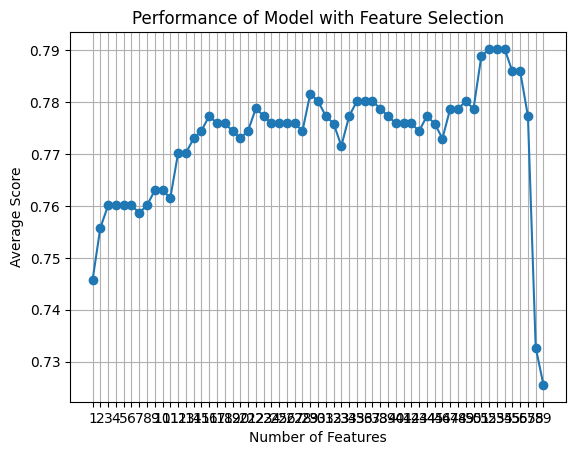

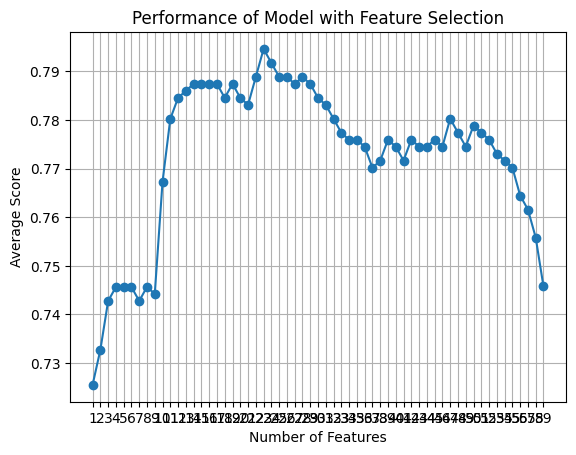

In [67]:
print("========================== Data 3  =================================")
print("SBFS")
slt_sbfs_features3_desb, score3_sbfs_desb = perform_feature_selection(X_train3, y_train3, modelo3_desb, "data3_desb", 'SBFS', 5)
print("SFFS")
slt_sffs_features3_desb, score3_sffs_desb = perform_feature_selection(X_train3, y_train3, modelo3_desb, "data3_desb", 'SFFS', 5)

In [96]:
print("Features selecionadas SBFS:")
print(slt_sbfs_features3_desb)
print(f"Acurácia: {score3_sbfs_desb}")
print("Features selecionadas SFFS:")
print(slt_sffs_features3_desb)
print(f"Acurácia: {score3_sffs_desb}")

Features selecionadas SBFS:
('AW', 'D_5.0', 'E_3.0', 'J_1.0', 'AB_3.0', '43', '44', '51')
Acurácia: 0.7902980472764647
Features selecionadas SFFS:
('F', 'AE', 'AN', 'AV', 'AX', 'AZ', 'D_5.0', 'E_1.0', 'E_2.0', 'E_3.0', 'E_4.0', 'I_2.0', 'J_1.0', 'J_2.0', 'J_3.0', 'J_4.0', 'J_5.0', 'AB_0.0', 'AB_3.0', 'AB_4.0', '43', '44', '51')
Acurácia: 0.7945837615621788


##### Base 4

========================== Data 4  =================================
SBFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done  92 out of  92 | elapsed:    5.4s finished

[2024-01-05 04:19:18] Features: 91/1 -- score: 0.755775950668037[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done  91 out of  91 | elapsed:    5.2s finished

[2024-01-05 04:19:23] Features: 90/1 -- score: 0.7528365878725591[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done  90 out of  90 | elapsed:    5.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.2s finished

[2024-01-05 04:19:30] Features: 90/1 -- score: 0.7572147995889004[Parallel(n_jobs=16)]: Using

SFFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  92 out of  92 | elapsed:    2.4s finished

[2024-01-05 04:36:33] Features: 1/92 -- score: 0.7169064748201439[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  91 out of  91 | elapsed:    2.5s finished

[2024-01-05 04:36:36] Features: 2/92 -- score: 0.7399486125385406[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  90 out of  90 | elapsed:    2.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.1s finished

[2024-01-05 04:36:40] Features: 3/92 -- score: 0.745693730729702[Parallel(n_jobs=16)]: Using

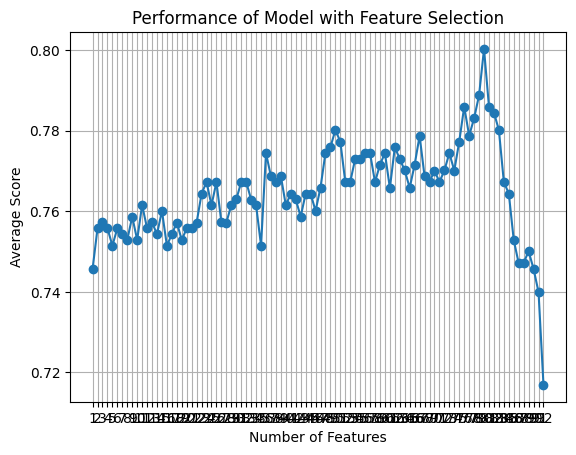

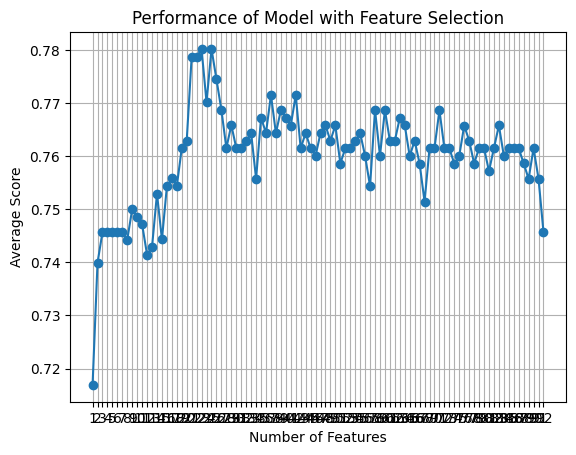

In [69]:
print("========================== Data 4  =================================")
print("SBFS")
slt_sbfs_features4_desb, score4_sbfs_desb = perform_feature_selection(X_train4, y_train4, modelo4_desb, "data4_desb", 'SBFS', 5)
print("SFFS")
slt_sffs_features4_desb, score4_sffs_desb = perform_feature_selection(X_train4, y_train4, modelo4_desb, "data4_desb", 'SFFS', 5)

In [70]:
print("Features selecionadas SBFS:")
print(slt_sbfs_features4_desb)
print(f"Acurácia: {score4_sbfs_desb}")
print("Features selecionadas SFFS:")
print(slt_sffs_features4_desb)
print(f"Acurácia: {score4_sffs_desb}")

Features selecionadas SBFS:
('B', 'O', 'AN', 'AA_1.0', '4', '4.1', '4.2', '6', '5.9', '4.6', '5.10', '5.11', '5.14')
Acurácia: 0.8002877697841727
Features selecionadas SFFS:
('B', 'C', 'H', 'M', 'AN', 'AT', 'D_3.0', 'D_4.0', 'D_5.0', 'E_3.0', 'I_2.0', 'I_3.0', 'I_4.0', 'J_2.0', 'J_3.0', 'J_4.0', 'AB_0.0', 'AB_4.0', '4', '6', '4.3', '4.6', '5.11', '5.12', '4.11')
Acurácia: 0.7802466598150051


#### Feature Selection nas bases com Random Under-Sampling

##### Base 1

========================== Data 1  =================================
SBFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  51 out of  54 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  54 out of  54 | elapsed:    1.4s finished

[2024-01-05 04:53:23] Features: 53/1 -- score: 0.4306938775510204[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  49 out of  53 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  53 out of  53 | elapsed:    1.4s finished

[2024-01-05 04:53:25] Features: 52/1 -- score: 0.4391836734693878[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  48 out of  52 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  52 out of  52 | elapsed:    1.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent worker

SFFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  51 out of  54 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  54 out of  54 | elapsed:    1.2s finished

[2024-01-05 04:58:01] Features: 1/54 -- score: 0.3904489795918368[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  49 out of  53 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  53 out of  53 | elapsed:    1.2s finished

[2024-01-05 04:58:02] Features: 2/54 -- score: 0.4759183673469388[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  48 out of  52 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  52 out of  52 | elapsed:    1.2s fini

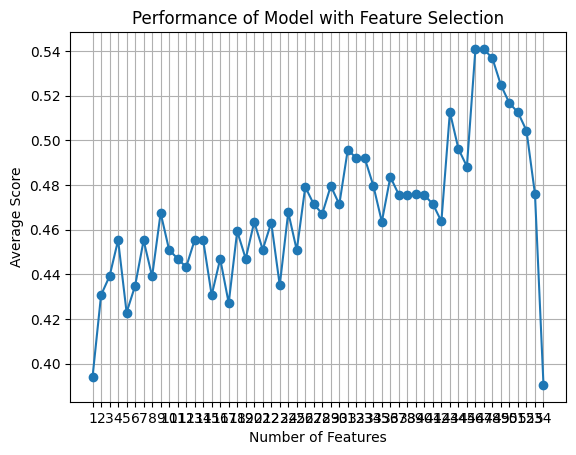

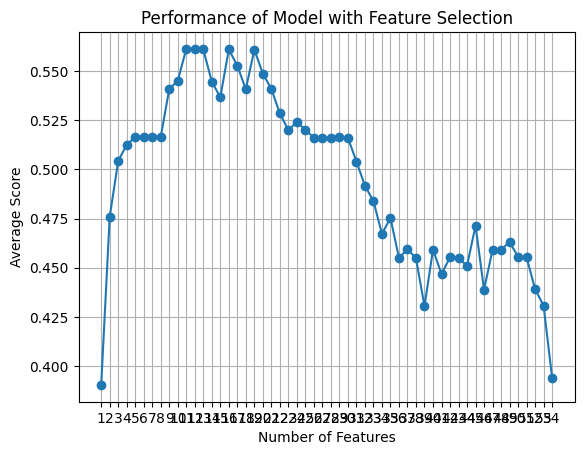

In [71]:
# Chamando a função de feature selection para cada um dos "modelos*"
print("========================== Data 1  =================================")
print("SBFS")
slt_sbfs_features1, score1_sbfs = perform_feature_selection(X_train1_re, y_train1_re, modelo1, "data1", 'SBFS', 5)
print("SFFS")
slt_sffs_features1, score1_sffs = perform_feature_selection(X_train1_re, y_train1_re, modelo1, "data1", 'SFFS', 5)

In [72]:
print("Features selecionadas SBFS:")
print(slt_sbfs_features1)
print(f"Acurácia: {score1_sbfs}")
print("Features selecionadas SFFS:")
print(slt_sffs_features1)
print(f"Acurácia: {score1_sffs}")

Features selecionadas SBFS:
('C', 'F', 'U', 'AU', 'BD', 'D_5.0', 'E_4.0', 'J_4.0', 'AA_1.0')
Acurácia: 0.5408979591836734
Features selecionadas SFFS:
('F', 'M', 'U', 'AR', 'AY', 'AZ', 'BD', 'D_4.0', 'E_4.0', 'J_3.0', 'AB_1.0')
Acurácia: 0.5612244897959184


##### Base 2

========================== Data 2  =================================
SBFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  52 out of  55 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  55 out of  55 | elapsed:    0.9s finished

[2024-01-05 05:02:17] Features: 54/1 -- score: 0.7199183673469387[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  51 out of  54 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  54 out of  54 | elapsed:    0.9s finished

[2024-01-05 05:02:18] Features: 53/1 -- score: 0.724[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  49 out of  53 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  53 out of  53 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(

SFFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  52 out of  55 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  55 out of  55 | elapsed:    0.8s finished

[2024-01-05 05:05:43] Features: 1/55 -- score: 0.7199183673469387[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  51 out of  54 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  54 out of  54 | elapsed:    0.9s finished

[2024-01-05 05:05:44] Features: 2/55 -- score: 0.732[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  49 out of  53 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  53 out of  53 | elapsed:    0.8s finished
[Paralle

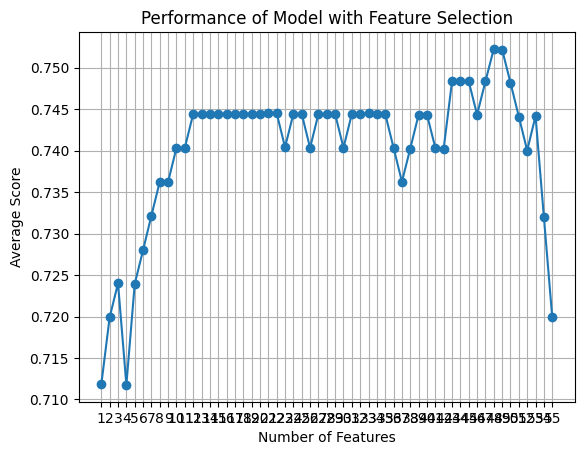

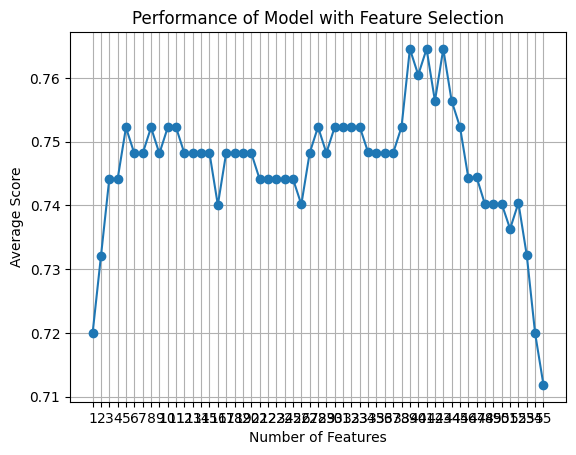

In [73]:
print("========================== Data 2  =================================")
print("SBFS")
slt_sbfs_features2, score2_sbfs = perform_feature_selection(X_train2_re, y_train2_re, modelo2, "data2", 'SBFS', 5)
print("SFFS")
slt_sffs_features2, score2_sffs = perform_feature_selection(X_train2_re, y_train2_re, modelo2,"data2", 'SFFS', 5)

In [74]:
print("Features selecionadas SBFS:")
print(slt_sbfs_features2)
print(f"Acurácia: {score2_sbfs}")
print("Features selecionadas SFFS:")
print(slt_sffs_features2)
print(f"Acurácia: {score2_sffs}")

Features selecionadas SBFS:
('C', 'U', 'AC', 'AD', 'AV', 'D_4.0', 'E_2.0', '171')
Acurácia: 0.7522448979591836
Features selecionadas SFFS:
('B', 'N', 'U', 'AD', 'AE', 'AN', 'AO', 'AP', 'AR', 'AS', 'AT', 'AU', 'AV', 'AX', 'AY', 'AZ', 'BD', 'BO', 'BP', 'D_1.0', 'D_2.0', 'D_4.0', 'D_5.0', 'E_1.0', 'E_2.0', 'E_3.0', 'I_2.0', 'I_3.0', 'I_4.0', 'J_1.0', 'J_3.0', 'J_4.0', 'AA_1.0', 'AA_2.0', 'AA_4.0', 'AB_0.0', 'AB_2.0', 'AB_3.0', '171')
Acurácia: 0.7645714285714286


##### Base 3

========================== Data 3  =================================
SBFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  59 out of  59 | elapsed:    0.0s finished

[2024-01-05 05:08:25] Features: 58/1 -- score: 0.748326530612245[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  58 out of  58 | elapsed:    0.0s finished

[2024-01-05 05:08:25] Features: 57/1 -- score: 0.748326530612245[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  55 out of  57 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  57 out of  57 | elapsed:    0.0s finished


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.9s finished

[2024-01-05 05:08:26] Features: 56/1 -- score: 0.748326530612245[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=16)]: Done  54 out of  56 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  56 out of  56 | elapsed:    1.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.8s finished

[2024-01-05 05:08:28] Features: 55/1 -- score: 0.748326530612245[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=16)]: Done  52 out of  55 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  55 out of  55 | elapsed:    1.2s finishe

SFFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  59 out of  59 | elapsed:    0.0s finished

[2024-01-05 05:09:14] Features: 1/59 -- score: 0.7153469387755103[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  58 out of  58 | elapsed:    0.0s finished

[2024-01-05 05:09:14] Features: 2/59 -- score: 0.7278367346938776[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  55 out of  57 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  57 out of  57 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.8s finished

[2024-01-05

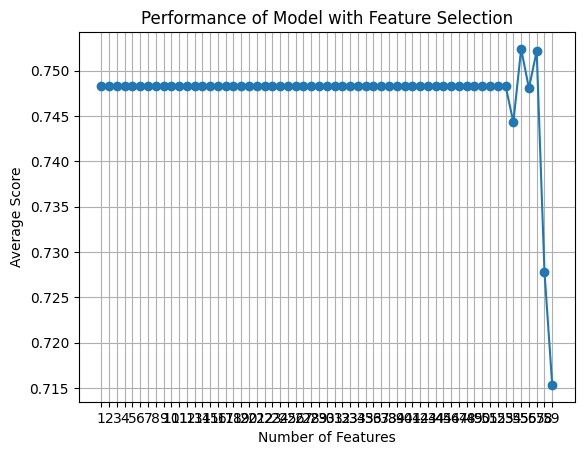

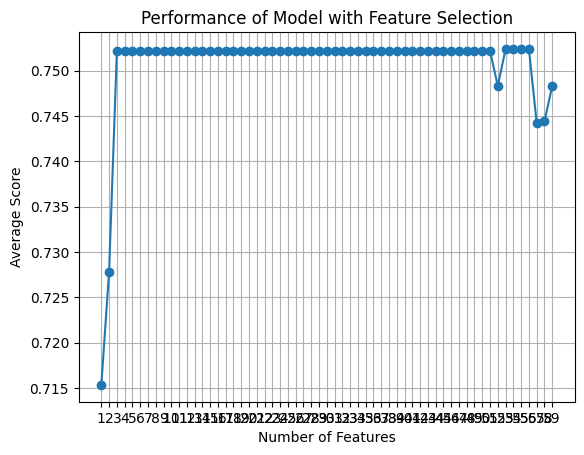

In [75]:
print("========================== Data 3  =================================")
print("SBFS")
slt_sbfs_features3, score3_sbfs = perform_feature_selection(X_train3_re, y_train3_re, modelo3, "data3", 'SBFS', 5)
print("SFFS")
slt_sffs_features3, score3_sffs = perform_feature_selection(X_train3_re, y_train3_re, modelo3, "data3", 'SFFS', 5)

In [76]:
print("Features selecionadas SBFS:")
print(slt_sbfs_features3)
print(f"Acurácia: {score3_sbfs}")
print("Features selecionadas SFFS:")
print(slt_sffs_features3)
print(f"Acurácia: {score3_sffs}")

Features selecionadas SBFS:
('C', 'AP', '24', '44', '51')
Acurácia: 0.7524081632653061
Features selecionadas SFFS:
('B', 'C', 'F', 'H', 'N', 'O', 'U', 'AC', 'AD', 'AE', 'AN', 'AP', 'AR', 'AS', 'AT', 'AU', 'AV', 'AW', 'AX', 'AY', 'AZ', 'BD', 'BP', 'D_1.0', 'D_2.0', 'D_3.0', 'D_4.0', 'D_5.0', 'E_1.0', 'E_2.0', 'E_3.0', 'E_4.0', 'I_1.0', 'I_2.0', 'I_3.0', 'I_4.0', 'J_1.0', 'J_2.0', 'J_3.0', 'J_4.0', 'J_5.0', 'AA_1.0', 'AA_2.0', 'AA_3.0', 'AA_4.0', 'AB_0.0', 'AB_1.0', 'AB_2.0', 'AB_3.0', 'AB_4.0', '24', '44', '51')
Acurácia: 0.7524081632653061


##### Base 4

========================== Data 4  =================================
SBFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  92 out of  92 | elapsed:    3.8s finished

[2024-01-05 05:10:04] Features: 91/1 -- score: 0.7565714285714286[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  91 out of  91 | elapsed:    3.6s finished

[2024-01-05 05:10:08] Features: 90/1 -- score: 0.76865306122449[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  90 out of  90 | elapsed:    3.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.2s finished

[2024-01-05 05:10:13] Features: 89/1 -- score: 0.7645714285714286[Parallel(n_jobs=16)]: Using 

SFFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  92 out of  92 | elapsed:    3.0s finished

[2024-01-05 05:23:07] Features: 1/92 -- score: 0.6706938775510204[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  91 out of  91 | elapsed:    3.0s finished

[2024-01-05 05:23:10] Features: 2/92 -- score: 0.7071020408163265[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  90 out of  90 | elapsed:    3.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.2s finished

[2024-01-05 05:23:14] Features: 3/92 -- score: 0.7155918367346938[Parallel(n_jobs=16)]: Usin

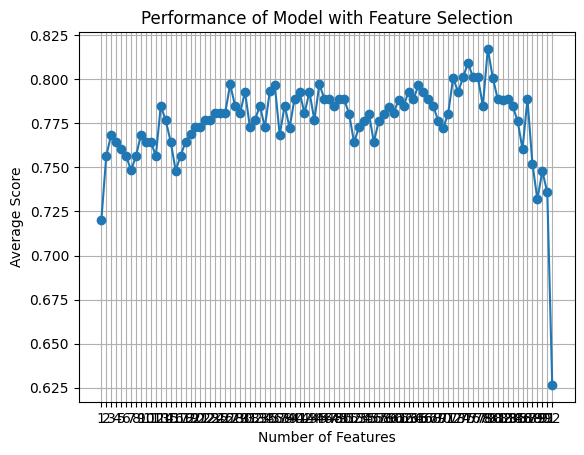

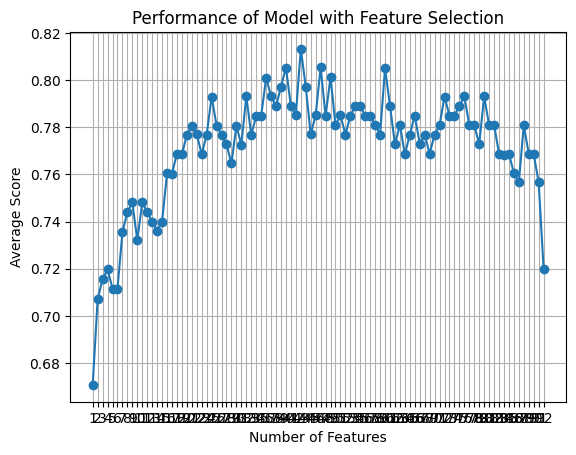

In [77]:
print("========================== Data 4  =================================")
print("SBFS")
slt_sbfs_features4, score4_sbfs = perform_feature_selection(X_train4_re, y_train4_re, modelo4,"data4", 'SBFS', 5)
print("SFFS")
slt_sffs_features4, score4_sffs = perform_feature_selection(X_train4_re, y_train4_re, modelo4, "data4", 'SFFS', 5)

In [78]:
print("Features selecionadas SBFS:")
print(slt_sbfs_features4)
print(f"Acurácia: {score4_sbfs}")
print("Features selecionadas SFFS:")
print(slt_sffs_features4)
print(f"Acurácia: {score4_sffs}")

Features selecionadas SBFS:
('C', 'H', 'O', 'AU', '4', '4.2', '4.3', '3.1', '5.7', '4.7', '2', '3.2', '5.10', '4.14')
Acurácia: 0.8172244897959183
Features selecionadas SFFS:
('H', 'L', 'N', 'O', 'U', 'AC', 'AR', 'AS', 'AU', 'AX', 'BD', 'BO', 'BP', 'D_1.0', 'D_5.0', 'E_1.0', 'E_3.0', 'E_4.0', 'J_3.0', 'J_4.0', 'J_5.0', 'AA_2.0', 'AB_0.0', 'AB_1.0', 'AB_3.0', 'AB_4.0', '4', '4.1', '4.2', '4.3', '4.4', '5.3', '3.1', '6.1', '4.7', '2', '3.2', '5.10', '5.12', '4.11', '4.13', '4.14', '6.5')
Acurácia: 0.8132244897959184


#### Feature Selection nas bases sem Random Under-Sampling e com Normalização

##### Base 1

========================== Data 1  =================================
SBFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  51 out of  54 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  54 out of  54 | elapsed:    2.0s finished

[2024-01-05 05:36:45] Features: 53/1 -- score: 0.5977286742034943[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  49 out of  53 | elapsed:    1.9s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  53 out of  53 | elapsed:    2.0s finished

[2024-01-05 05:36:47] Features: 52/1 -- score: 0.5948612538540596[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  48 out of  52 | elapsed:    1.8s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  52 out of  52 | elapsed:    1.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent worker

SFFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  51 out of  54 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  54 out of  54 | elapsed:    1.2s finished

[2024-01-05 05:42:22] Features: 1/54 -- score: 0.6264439876670094[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  49 out of  53 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  53 out of  53 | elapsed:    1.2s finished

[2024-01-05 05:42:23] Features: 2/54 -- score: 0.6278828365878726[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  48 out of  52 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  52 out of  52 | elapsed:    1.2s fini

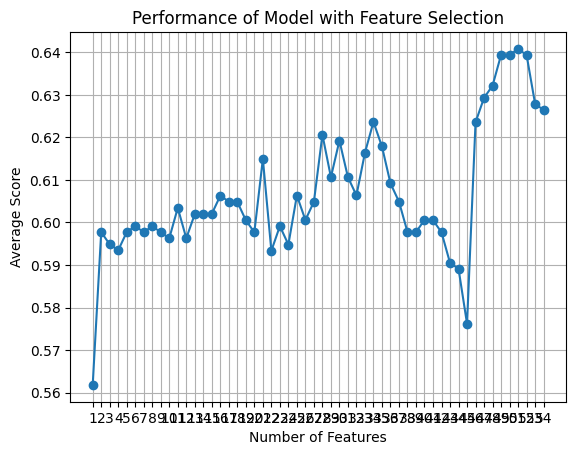

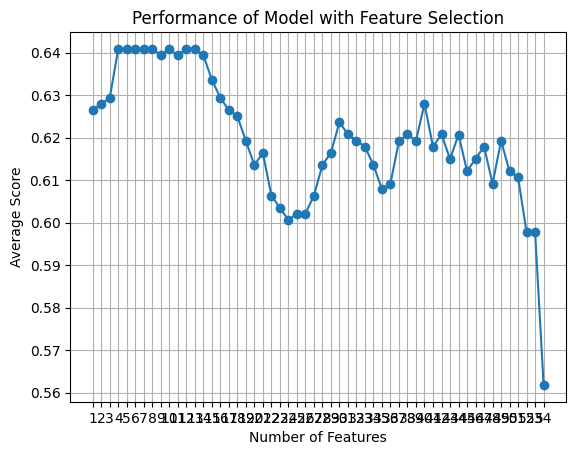

In [79]:
print("========================== Data 1  =================================")
print("SBFS")
slt_sbfs_features1_norm, score1_sbfs_norm = perform_feature_selection(X_train1_norm, y_train1, modelo1_norm, "data1_norm", 'SBFS', 5)
print("SFFS")
slt_sffs_features1_norm, score1_sffs_norm = perform_feature_selection(X_train1_norm, y_train1, modelo1_norm, "data1_norm", 'SFFS', 5)

In [80]:
print("Features selecionadas SBFS:")
print(slt_sbfs_features1_norm)
print(f"Acurácia: {score1_sbfs_norm}")
print("Features selecionadas SFFS:")
print(slt_sffs_features1_norm)
print(f"Acurácia: {score1_sffs_norm}")

Features selecionadas SBFS:
('U', 'AY', 'BP', 'J_3.0')
Acurácia: 0.6408016443987667
Features selecionadas SFFS:
('U', 'AZ', 'BP', 'D_4.0', 'E_2.0', 'E_4.0', 'I_3.0', 'J_3.0', 'J_4.0', 'J_5.0', 'AA_2.0', 'AB_0.0')
Acurácia: 0.6408427543679343


##### Base 2

========================== Data 2  =================================
SBFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done  52 out of  55 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  55 out of  55 | elapsed:    0.1s finished

[2024-01-05 05:47:43] Features: 54/1 -- score: 0.6508427543679343[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  51 out of  54 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  54 out of  54 | elapsed:    0.0s finished

[2024-01-05 05:47:43] Features: 53/1 -- score: 0.6537307297019528[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  49 out of  53 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  53 out of  53 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.0

SFFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  52 out of  55 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  55 out of  55 | elapsed:    0.3s finished

[2024-01-05 05:49:56] Features: 1/55 -- score: 0.7111613566289826[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  51 out of  54 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  54 out of  54 | elapsed:    0.3s finished

[2024-01-05 05:49:57] Features: 2/55 -- score: 0.7284378211716341[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  49 out of  53 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  53 out of  53 | elapsed:    0.3s fini

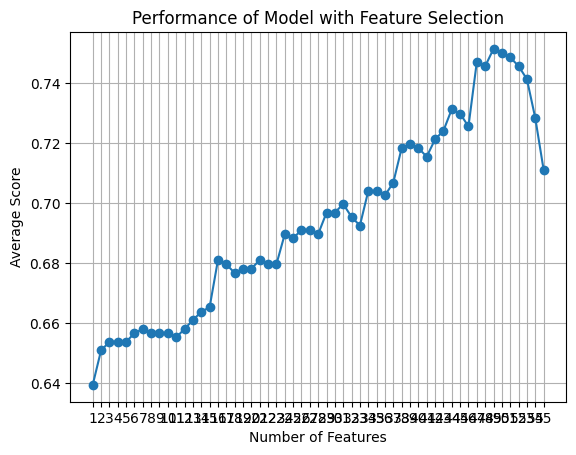

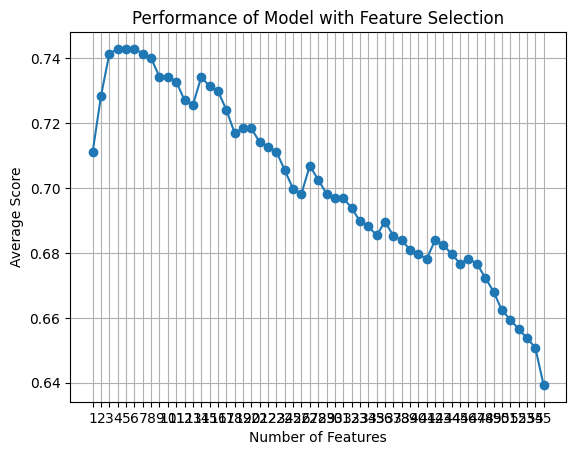

In [81]:
print("========================== Data 2  =================================")
print("SBFS")
slt_sbfs_features2_norm, score2_sbfs_norm = perform_feature_selection(X_train2_norm, y_train2, modelo2_norm, "data2_norm", 'SBFS', 5)
print("SFFS")
slt_sffs_features2_norm, score2_sffs_norm = perform_feature_selection(X_train2_norm, y_train2, modelo2_norm,"data2_norm", 'SFFS', 5)

In [82]:
print("Features selecionadas SBFS:")
print(slt_sbfs_features2_norm)
print(f"Acurácia: {score2_sbfs_norm}")
print("Features selecionadas SFFS:")
print(slt_sffs_features2_norm)

Features selecionadas SBFS:
('C', 'L', 'AO', 'AW', 'I_3.0', 'J_3.0', '171')
Acurácia: 0.7514696813977391
Features selecionadas SFFS:
('E_4.0', 'I_3.0', 'AB_3.0', '171')


##### Base 3

========================== Data 3  =================================
SBFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  59 out of  59 | elapsed:    0.0s finished

[2024-01-05 05:51:47] Features: 58/1 -- score: 0.6565775950668037[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  58 out of  58 | elapsed:    0.0s finished

[2024-01-05 05:51:47] Features: 57/1 -- score: 0.6724049331963001[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  55 out of  57 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  57 out of  57 | elapsed:    0.0s finished


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.9s finished

[2024-01-05 05:51:48] Features: 56/1 -- score: 0.6925590955806783[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=16)]: Done  54 out of  56 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  56 out of  56 | elapsed:    1.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.8s finished

[2024-01-05 05:51:50] Features: 55/1 -- score: 0.7026002055498458[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=16)]: Done  52 out of  55 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  55 out of  55 | elapsed:    1.2s finis

SFFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  59 out of  59 | elapsed:    0.0s finished

[2024-01-05 05:53:10] Features: 1/59 -- score: 0.7083247687564235[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  58 out of  58 | elapsed:    0.0s finished

[2024-01-05 05:53:10] Features: 2/59 -- score: 0.7528982528263104[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  55 out of  57 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  57 out of  57 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.8s finished

[2024-01-05

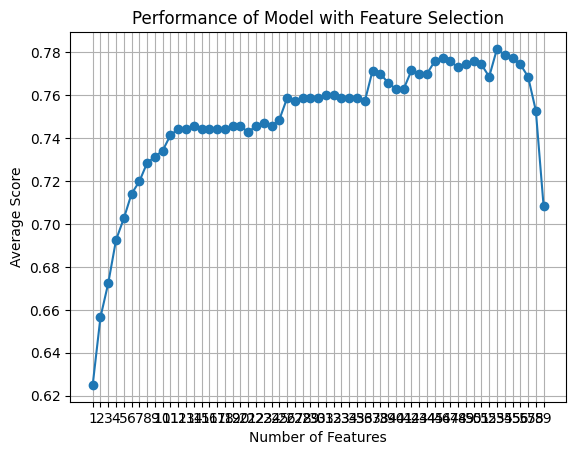

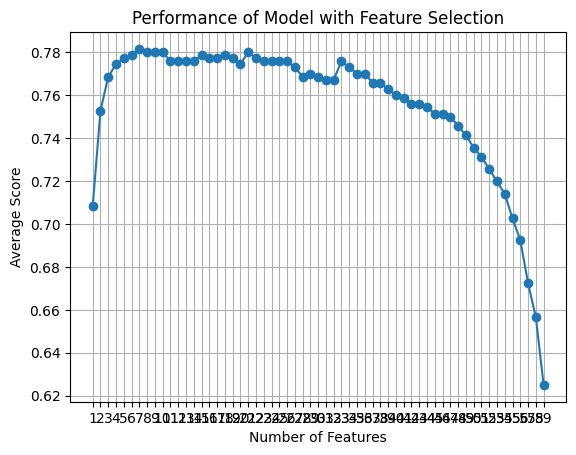

In [83]:
print("========================== Data 3  =================================")
print("SBFS")
slt_sbfs_features3_norm, score3_sbfs_norm = perform_feature_selection(X_train3_norm, y_train3, modelo3_norm, "data3_norm", 'SBFS', 5)
print("SFFS")
slt_sffs_features3_norm, score3_sffs_norm = perform_feature_selection(X_train3_norm, y_train3, modelo3_norm, "data3_norm", 'SFFS', 5)

In [84]:
print("Features selecionadas SBFS:")
print(slt_sbfs_features3_norm)
print(f"Acurácia: {score3_sbfs_norm}")
print("Features selecionadas SFFS:")
print(slt_sffs_features3_norm)
print(f"Acurácia: {score3_sffs_norm}")

Features selecionadas SBFS:
('B', 'AP', 'AT', 'D_1.0', '24', '44', '51')
Acurácia: 0.7816649537512849
Features selecionadas SFFS:
('B', 'AP', 'AT', 'D_1.0', '24', '44', '51')
Acurácia: 0.7816649537512849


##### Base 4

========================== Data 4  =================================
SBFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=16)]: Done  59 out of  59 | elapsed:    3.6s finished

[2024-01-05 05:54:47] Features: 58/1 -- score: 0.7558067831449127[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  58 out of  58 | elapsed:    3.3s finished

[2024-01-05 05:54:50] Features: 57/1 -- score: 0.7485817060637204[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done  55 out of  57 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  57 out of  57 | elapsed:    3.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.2s finished

[2024-01-05

SFFS


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  59 out of  59 | elapsed:    1.6s finished

[2024-01-05 06:02:07] Features: 1/59 -- score: 0.7283761562178828[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  58 out of  58 | elapsed:    1.7s finished

[2024-01-05 06:02:09] Features: 2/59 -- score: 0.7341521068859198[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  55 out of  57 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  57 out of  57 | elapsed:    1.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.2s finished

[2024-01-05

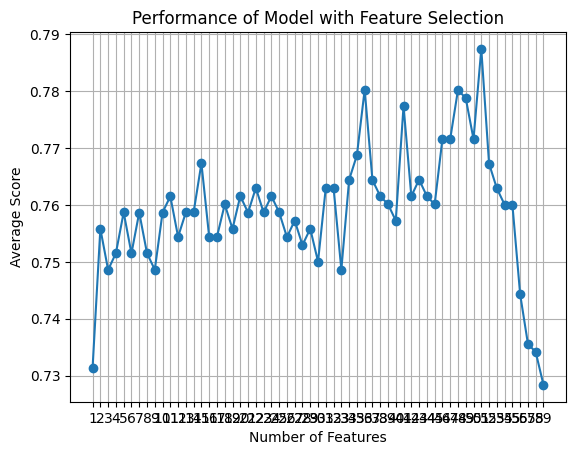

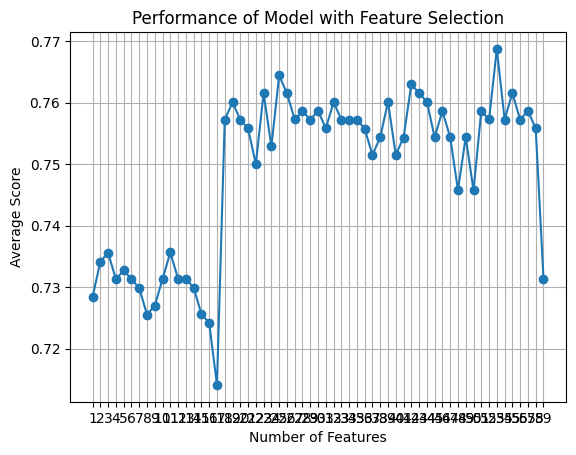

In [85]:
print("========================== Data 4  =================================")
print("SBFS")
slt_sbfs_features4_norm, score4_sbfs_norm = perform_feature_selection(X_train3_norm, y_train4, modelo4_norm,"data4_norm", 'SBFS', 5)
print("SFFS")
slt_sffs_features4_norm, score4_sffs_norm = perform_feature_selection(X_train3_norm, y_train4, modelo4_norm, "data4_norm", 'SFFS', 5)

In [86]:
print("Features selecionadas SBFS:")
print(slt_sbfs_features4_norm)
print(f"Acurácia: {score4_sbfs_norm}")
print("Features selecionadas SFFS:")
print(slt_sffs_features4_norm)
print(f"Acurácia: {score4_sffs_norm}")

Features selecionadas SBFS:
('O', 'U', 'AP', 'AU', 'I_1.0', 'AA_3.0', '44', '51', '9.1')
Acurácia: 0.7873895169578622
Features selecionadas SFFS:
('B', 'C', 'F', 'H', 'L', 'N', 'U', 'AD', 'AE', 'AN', 'AO', 'AP', 'AR', 'AT', 'AU', 'AV', 'AW', 'AX', 'AY', 'AZ', 'BD', 'BO', 'BP', 'D_2.0', 'D_3.0', 'D_4.0', 'D_5.0', 'E_1.0', 'E_2.0', 'E_3.0', 'E_4.0', 'I_1.0', 'I_2.0', 'I_3.0', 'I_4.0', 'J_1.0', 'J_2.0', 'J_3.0', 'J_4.0', 'J_5.0', 'AA_1.0', 'AA_2.0', 'AA_4.0', 'AB_0.0', 'AB_1.0', 'AB_2.0', 'AB_3.0', 'AB_4.0', '43', '24', '44', '51', '9.1')
Acurácia: 0.7687358684480987


### Salvando as features selecionadas

#### Sem Random Under-Sampling

In [87]:
# Criando um arquivo txt com a feature selecionadas
with open(f"results/SBFS_data1_desb.txt", "w") as f:
    f.write(str(slt_sbfs_features1_desb))
with open(f"results/SFFS_data1_desb.txt", "w") as f:
    f.write(str(slt_sffs_features1_desb))
with open(f"results/SBFS_data2_desb.txt", "w") as f:
    f.write(str(slt_sbfs_features2_desb))
with open(f"results/SFFS_data2_desb.txt", "w") as f:
    f.write(str(slt_sffs_features2_desb))
with open(f"results/SBFS_data3_desb.txt", "w") as f:
    f.write(str(slt_sbfs_features3_desb))
with open(f"results/SFFS_data3_desb.txt", "w") as f:
    f.write(str(slt_sffs_features3_desb))
with open(f"results/SBFS_data4_desb.txt", "w") as f:
    f.write(str(slt_sbfs_features4_desb))
with open(f"results/SFFS_data4_desb.txt", "w") as f:
    f.write(str(slt_sffs_features4_desb))

#### Com Random Under-Sampling

In [88]:
# Criando um arquivo txt com a feature selecionadas
with open(f"results/SBFS_data1.txt", "w") as f:
    f.write(str(slt_sbfs_features1))
with open(f"results/SFFS_data1.txt", "w") as f:
    f.write(str(slt_sffs_features1))
with open(f"results/SBFS_data2.txt", "w") as f:
    f.write(str(slt_sbfs_features2))
with open(f"results/SFFS_data2.txt", "w") as f:
    f.write(str(slt_sffs_features2))
with open(f"results/SBFS_data3.txt", "w") as f:
    f.write(str(slt_sbfs_features3))
with open(f"results/SFFS_data3.txt", "w") as f:
    f.write(str(slt_sffs_features3))
with open(f"results/SBFS_data4.txt", "w") as f:
    f.write(str(slt_sbfs_features4))
with open(f"results/SFFS_data4.txt", "w") as f:
    f.write(str(slt_sffs_features4))

#### Sem Random Under-Sampling e com Normalização

In [89]:
with open(f"results/SBFS_data1_norm.txt", "w") as f:
    f.write(str(slt_sbfs_features1_norm))
with open(f"results/SFFS_data1_norm.txt", "w") as f:
    f.write(str(slt_sffs_features1_norm))
with open(f"results/SBFS_data2_norm.txt", "w") as f:
    f.write(str(slt_sbfs_features2_norm))
with open(f"results/SFFS_data2_norm.txt", "w") as f:
    f.write(str(slt_sffs_features2_norm))
with open(f"results/SBFS_data3_norm.txt", "w") as f:
    f.write(str(slt_sbfs_features3_norm))
with open(f"results/SFFS_data3_norm.txt", "w") as f:
    f.write(str(slt_sffs_features3_norm))
with open(f"results/SBFS_data4_norm.txt", "w") as f:
    f.write(str(slt_sbfs_features4_norm))
with open(f"results/SFFS_data4_norm.txt", "w") as f:
    f.write(str(slt_sffs_features4_norm))

### [Abrir features selecionadas]

In [90]:
# Lendo os arquivos txt com as features selecionadas
slt_sbfs_features1 = ler_arquivo_txt('results/SBFS_data1.txt')[0]
slt_sffs_features1 = ler_arquivo_txt('results/SFFS_data1.txt')[0]
slt_sbfs_features2 = ler_arquivo_txt('results/SBFS_data2.txt')[0]
slt_sffs_features2 = ler_arquivo_txt('results/SFFS_data2.txt')[0]
slt_sbfs_features3 = ler_arquivo_txt('results/SBFS_data3.txt')[0]
slt_sffs_features3 = ler_arquivo_txt('results/SFFS_data3.txt')[0]
slt_sbfs_features4 = ler_arquivo_txt('results/SBFS_data4.txt')[0]
slt_sffs_features4 = ler_arquivo_txt('results/SFFS_data4.txt')[0]

## Avaliando os modelos tunnados com as features selecionadas

Nessa etapa, os modelos são avalidos com as features selecionadas pelo SBFS e SFFS. 
O teste é feito com a base de teste, que não foi usada para treinar o modelo.

Esse é o resultado final do trabalho.

In [91]:
# Função para pegar as features selecionadas do csv. Essa função retorna uma lista com as features selecionadas.
def get_features_selected(file):
    df = pd.read_csv(file)
    # Seleciona a linha da coluna avg_score que possui o maior valor
    df = df.loc[df['avg_score'] == df['avg_score'].max()]
    
    # Agora pega as features na coluna feature_idx
    features = df['feature_idx'].values[0]
    
    # Transforma a string em lista
    features = features.replace(' ', '').replace('(', '').replace(')', '').split(',')

    # Remov os elementos vazios
    features = [i for i in features if i != '']
    
    # Transforma os elementos da lista em inteiros
    features = [int(i) for i in features]
    
    return features

def get_confusion_matrix(model, X_treino, y_treino, X_teste, y_teste, encoder):
    from sklearn.metrics import confusion_matrix
    model.fit(X_treino, y_treino)
    y_pred = model.predict(X_teste)
    #Plot da matriz de confusão

    # Reverse encoding
    y_teste = encoder.inverse_transform(y_teste)
    y_pred = encoder.inverse_transform(y_pred)

    # Plot da matriz de confusão com o seaborn
    plt.figure(figsize=(6, 4))
    sns.set(font_scale=1.4)
    sns.heatmap(confusion_matrix(y_teste, y_pred), annot=True, annot_kws={"size": 10}, fmt='g')
    plt.show()
    
    print(classification_report(y_teste, y_pred, zero_division=0))

    return confusion_matrix(y_teste, y_pred)

### Sem Random Under-Sampling

#### Base 1

In [97]:
b1_desb_features

[1]

========================== SBFS  =================================
Features selecionadas pelo SBFS: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
Matriz de confusão


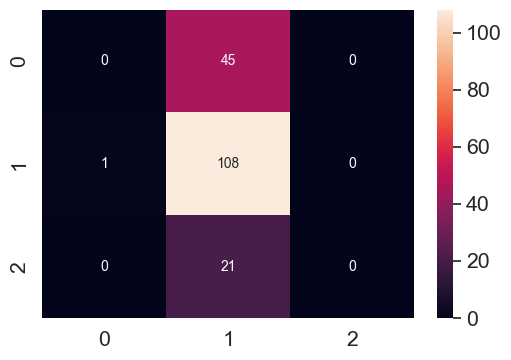

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        45
         2.0       0.62      0.99      0.76       109
         3.0       0.00      0.00      0.00        21

    accuracy                           0.62       175
   macro avg       0.21      0.33      0.25       175
weighted avg       0.39      0.62      0.48       175



In [98]:
# Matrix de confusão e acurácia
print("========================== SBFS  =================================")
b1_desb_features = get_features_selected('results/SBFS_data1_desb.csv')
print(f'Features selecionadas pelo SBFS: {b1_desb_features}')
print("Matriz de confusão")
confusion_matrix1_desb = get_confusion_matrix(modelo1_desb, X_train1.iloc[:,b1_desb_features], y_train1, X_test1.iloc[:,b1_desb_features], y_test1, labelEncoder)

========================== SFFS  =================================
Features selecionadas pelo SFFS: [1]
Matriz de confusão


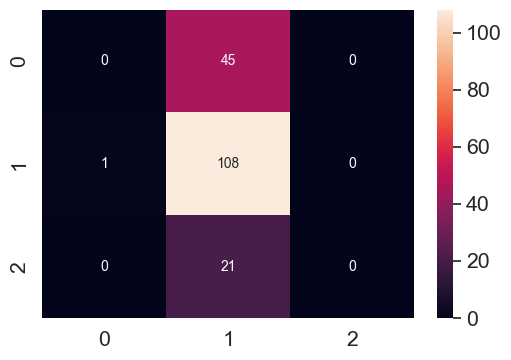

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        45
         2.0       0.62      0.99      0.76       109
         3.0       0.00      0.00      0.00        21

    accuracy                           0.62       175
   macro avg       0.21      0.33      0.25       175
weighted avg       0.39      0.62      0.48       175



In [99]:
# Matrix de confusão e acurácia
print("========================== SFFS  =================================")
b1_desb_features = get_features_selected('results/SFFS_data1_desb.csv')
print(f'Features selecionadas pelo SFFS: {b1_desb_features}')
print("Matriz de confusão")
confusion_matrix1_desb = get_confusion_matrix(modelo1_desb, X_train1.iloc[:,b1_desb_features], y_train1, X_test1.iloc[:,b1_desb_features], y_test1, labelEncoder)

#### Base 2

========================== SBFS  =================================
Features selecionadas pelo SBFS: [0, 1, 2, 3, 5, 6, 8, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 34, 38, 39, 40, 43, 45, 48, 52, 54]
Matriz de confusão


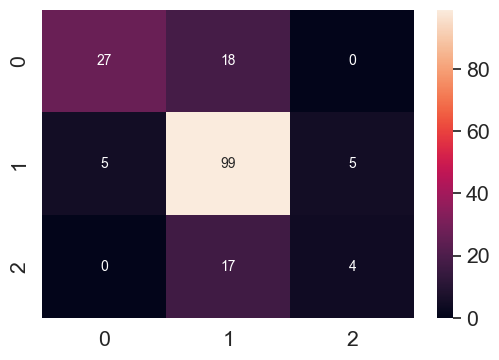

              precision    recall  f1-score   support

         1.0       0.84      0.60      0.70        45
         2.0       0.74      0.91      0.81       109
         3.0       0.44      0.19      0.27        21

    accuracy                           0.74       175
   macro avg       0.68      0.57      0.59       175
weighted avg       0.73      0.74      0.72       175



In [100]:
print("========================== SBFS  =================================")
b2_desb_features = get_features_selected('results/SBFS_data2_desb.csv')
print(f'Features selecionadas pelo SBFS: {b2_desb_features}')
print("Matriz de confusão")
confusion_matrix2_desb = get_confusion_matrix(modelo2_desb, X_train2.iloc[:,b2_desb_features], y_train2, X_test2.iloc[:,b2_desb_features], y_test2, labelEncoder)

========================== SFFS  =================================
Features selecionadas pelo SFFS: [0, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 15, 16, 17, 18, 20, 21, 24, 25, 27, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 48, 49, 50, 51, 52, 53, 54]
Matriz de confusão


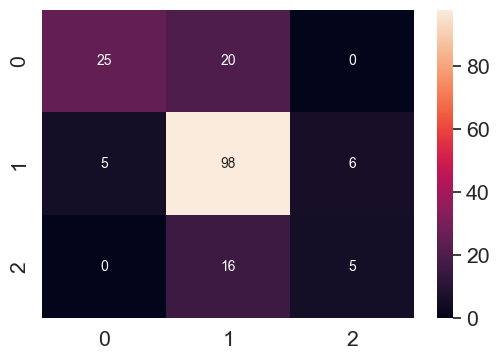

              precision    recall  f1-score   support

         1.0       0.83      0.56      0.67        45
         2.0       0.73      0.90      0.81       109
         3.0       0.45      0.24      0.31        21

    accuracy                           0.73       175
   macro avg       0.67      0.56      0.60       175
weighted avg       0.72      0.73      0.71       175



In [101]:
print("========================== SFFS  =================================")
b2_desb_features = get_features_selected('results/SFFS_data2_desb.csv')
print(f'Features selecionadas pelo SFFS: {b2_desb_features}')
print("Matriz de confusão")
confusion_matrix2_desb = get_confusion_matrix(modelo2_desb, X_train2.iloc[:,b2_desb_features], y_train2, X_test2.iloc[:,b2_desb_features], y_test2, labelEncoder)

#### Base 3

========================== SBFS  =================================
Features selecionadas pelo SBFS: [20, 31, 34, 40, 52, 54, 56, 57]
Matriz de confusão


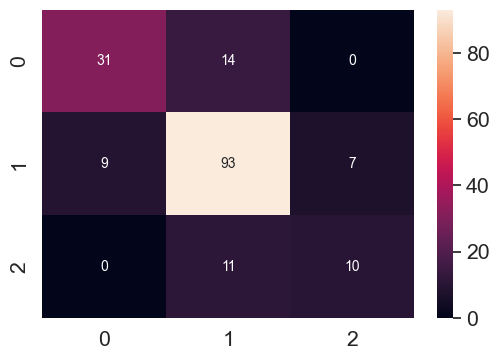

              precision    recall  f1-score   support

         1.0       0.78      0.69      0.73        45
         2.0       0.79      0.85      0.82       109
         3.0       0.59      0.48      0.53        21

    accuracy                           0.77       175
   macro avg       0.72      0.67      0.69       175
weighted avg       0.76      0.77      0.76       175



In [102]:
print("========================== SBFS  =================================")
b3_desb_features = get_features_selected('results/SBFS_data3_desb.csv')
print(f'Features selecionadas pelo SBFS: {b3_desb_features}')
print("Matriz de confusão")
confusion_matrix3_desb = get_confusion_matrix(modelo3_desb, X_train3.iloc[:, b3_desb_features], y_train3, X_test3.iloc[:, b3_desb_features], y_test3, labelEncoder)


========================== SFFS  =================================
Features selecionadas pelo SFFS: [2, 11, 12, 19, 21, 23, 31, 32, 33, 34, 35, 37, 40, 41, 42, 43, 44, 49, 52, 53, 54, 56, 57]
Matriz de confusão


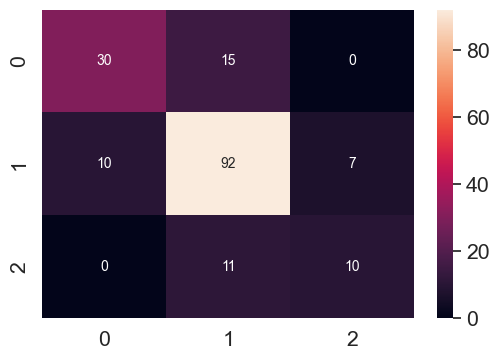

              precision    recall  f1-score   support

         1.0       0.75      0.67      0.71        45
         2.0       0.78      0.84      0.81       109
         3.0       0.59      0.48      0.53        21

    accuracy                           0.75       175
   macro avg       0.71      0.66      0.68       175
weighted avg       0.75      0.75      0.75       175



In [103]:
print("========================== SFFS  =================================")
b3_desb_features = get_features_selected('results/SFFS_data3_desb.csv')
print(f'Features selecionadas pelo SFFS: {b3_desb_features}')
print("Matriz de confusão")
confusion_matrix3_desb = get_confusion_matrix(modelo3_desb, X_train3.iloc[:, b3_desb_features], y_train3, X_test3.iloc[:, b3_desb_features], y_test3, labelEncoder)

#### Base 4

========================== SBFS  =================================
Features selecionadas pelo SBFS: [0, 7, 12, 45, 54, 55, 56, 57, 72, 73, 78, 80, 90]
Matriz de confusão


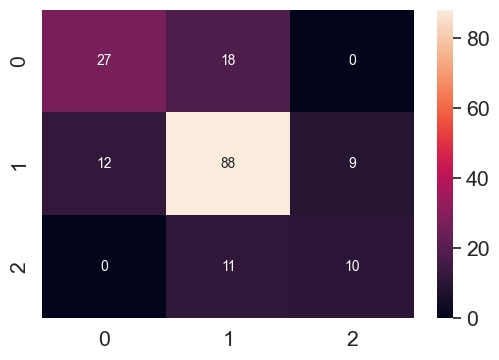

              precision    recall  f1-score   support

         1.0       0.69      0.60      0.64        45
         2.0       0.75      0.81      0.78       109
         3.0       0.53      0.48      0.50        21

    accuracy                           0.71       175
   macro avg       0.66      0.63      0.64       175
weighted avg       0.71      0.71      0.71       175



In [104]:
print("========================== SBFS  =================================")
b4_desb_features = get_features_selected('results/SBFS_data4_desb.csv')
print(f'Features selecionadas pelo SBFS: {b4_desb_features}')
print("Matriz de confusão")
confusion_matrix4_desb = get_confusion_matrix(modelo4_desb, X_train4.iloc[:, b4_desb_features], y_train4, X_test4.iloc[:, b4_desb_features], y_test4, labelEncoder)

========================== SFFS  =================================
Features selecionadas pelo SFFS: [0, 1, 3, 5, 12, 17, 29, 30, 31, 34, 37, 38, 39, 41, 42, 43, 49, 53, 54, 57, 58, 73, 80, 81, 85]
Matriz de confusão


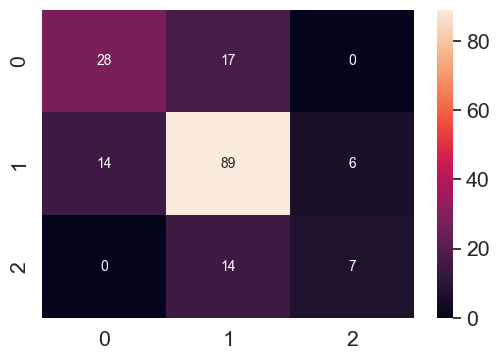

              precision    recall  f1-score   support

         1.0       0.67      0.62      0.64        45
         2.0       0.74      0.82      0.78       109
         3.0       0.54      0.33      0.41        21

    accuracy                           0.71       175
   macro avg       0.65      0.59      0.61       175
weighted avg       0.70      0.71      0.70       175



In [105]:
print("========================== SFFS  =================================")
b4_desb_features = get_features_selected('results/SFFS_data4_desb.csv')
print(f'Features selecionadas pelo SFFS: {b4_desb_features}')
print("Matriz de confusão")
confusion_matrix4_desb = get_confusion_matrix(modelo4_desb, X_train4.iloc[:, b4_desb_features], y_train4, X_test4.iloc[:, b4_desb_features], y_test4, labelEncoder)

### Com Random Under-Sampling

#### Base 1

========================== SBFS  =================================
Features selecionadas pelo SBFS: [1, 2, 8, 18, 24, 31, 35, 43, 45]
Matriz de confusão


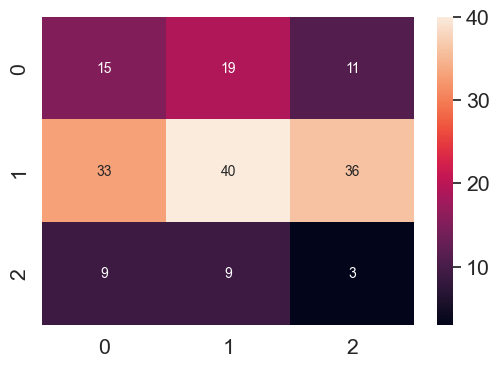

              precision    recall  f1-score   support

         1.0       0.26      0.33      0.29        45
         2.0       0.59      0.37      0.45       109
         3.0       0.06      0.14      0.08        21

    accuracy                           0.33       175
   macro avg       0.30      0.28      0.28       175
weighted avg       0.44      0.33      0.37       175



In [106]:
print("========================== SBFS  =================================")
b1_features = get_features_selected('results/SBFS_data1.csv')
print(f'Features selecionadas pelo SBFS: {b1_features}')
print("Matriz de confusão")
confusion_matrix1 = get_confusion_matrix(modelo1, X_train1_re.iloc[:, b1_features], y_train1_re, X_test1.iloc[:, b1_features], y_test1, labelEncoder)

========================== SFFS  =================================
Features selecionadas pelo SFFS: [2, 5, 8, 15, 22, 23, 24, 30, 35, 42, 50]
Matriz de confusão


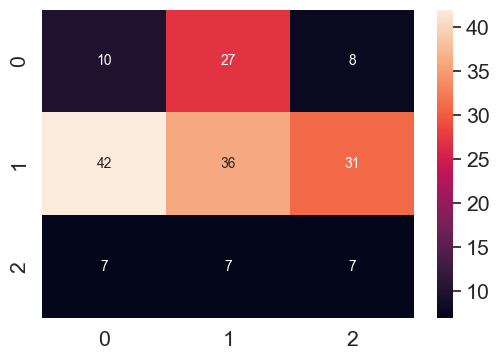

              precision    recall  f1-score   support

         1.0       0.17      0.22      0.19        45
         2.0       0.51      0.33      0.40       109
         3.0       0.15      0.33      0.21        21

    accuracy                           0.30       175
   macro avg       0.28      0.30      0.27       175
weighted avg       0.38      0.30      0.33       175



In [107]:
print("========================== SFFS  =================================")
b1_features = get_features_selected('results/SFFS_data1.csv')
print(f'Features selecionadas pelo SFFS: {b1_features}')
print("Matriz de confusão")
confusion_matrix1 = get_confusion_matrix(modelo1, X_train1_re.iloc[:, b1_features], y_train1_re, X_test1.iloc[:, b1_features], y_test1, labelEncoder)

#### Base 2

========================== SBFS  =================================
Features selecionadas pelo SBFS: [1, 8, 9, 10, 19, 30, 33, 54]
Matriz de confusão


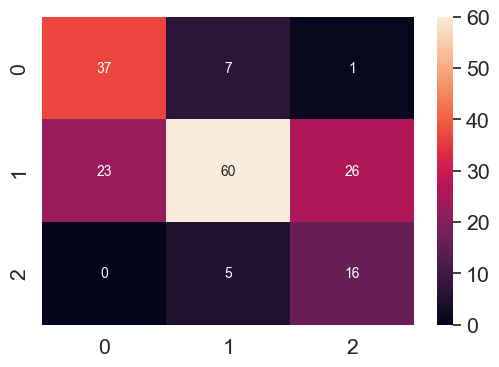

              precision    recall  f1-score   support

         1.0       0.62      0.82      0.70        45
         2.0       0.83      0.55      0.66       109
         3.0       0.37      0.76      0.50        21

    accuracy                           0.65       175
   macro avg       0.61      0.71      0.62       175
weighted avg       0.72      0.65      0.65       175



In [108]:
print("========================== SBFS  =================================")
b2_features = get_features_selected('results/SBFS_data2.csv')
print(f'Features selecionadas pelo SBFS: {b2_features}')
print("Matriz de confusão")
confusion_matrix2 = get_confusion_matrix(modelo2, X_train2_re.iloc[:, b2_features], y_train2_re, X_test2.iloc[:, b2_features], y_test2, labelEncoder)

========================== SFFS  =================================
Features selecionadas pelo SFFS: [0, 6, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 37, 38, 39, 40, 42, 43, 45, 46, 48, 49, 51, 52, 54]
Matriz de confusão


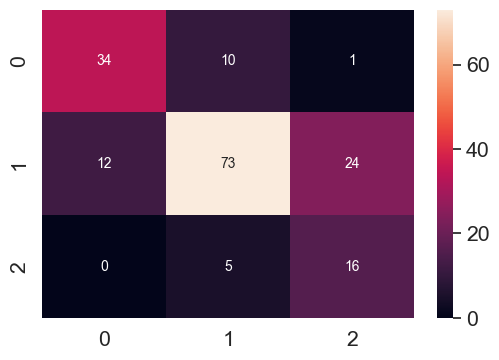

              precision    recall  f1-score   support

         1.0       0.74      0.76      0.75        45
         2.0       0.83      0.67      0.74       109
         3.0       0.39      0.76      0.52        21

    accuracy                           0.70       175
   macro avg       0.65      0.73      0.67       175
weighted avg       0.75      0.70      0.72       175



In [109]:
print("========================== SFFS  =================================")
b2_features = get_features_selected('results/SFFS_data2.csv')
print(f'Features selecionadas pelo SFFS: {b2_features}')
print("Matriz de confusão")
confusion_matrix2 = get_confusion_matrix(modelo2, X_train2_re.iloc[:, b2_features], y_train2_re, X_test2.iloc[:, b2_features], y_test2, labelEncoder)

#### Base 3

========================== SBFS  =================================
Features selecionadas pelo SBFS: [1, 14, 55, 56, 57]
Matriz de confusão


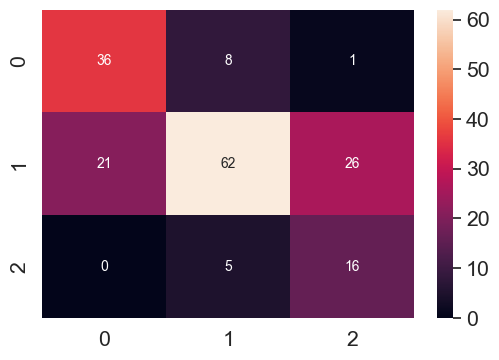

              precision    recall  f1-score   support

         1.0       0.63      0.80      0.71        45
         2.0       0.83      0.57      0.67       109
         3.0       0.37      0.76      0.50        21

    accuracy                           0.65       175
   macro avg       0.61      0.71      0.63       175
weighted avg       0.72      0.65      0.66       175



In [110]:
print("========================== SBFS  =================================")
b3_features = get_features_selected('results/SBFS_data3.csv')
print(f'Features selecionadas pelo SBFS: {b3_features}')
print("Matriz de confusão")
confusion_matrix3 = get_confusion_matrix(modelo3, X_train3_re.iloc[:, b3_features], y_train3_re, X_test3.iloc[:, b3_features], y_test3, labelEncoder)

========================== SFFS  =================================
Features selecionadas pelo SFFS: [0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57]
Matriz de confusão


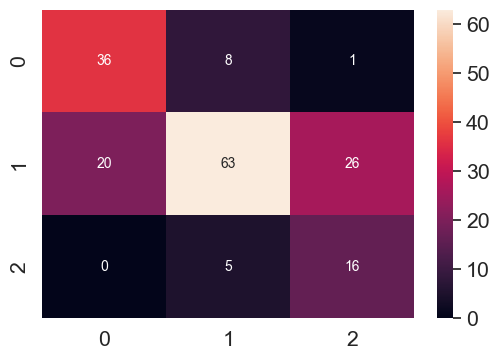

              precision    recall  f1-score   support

         1.0       0.64      0.80      0.71        45
         2.0       0.83      0.58      0.68       109
         3.0       0.37      0.76      0.50        21

    accuracy                           0.66       175
   macro avg       0.61      0.71      0.63       175
weighted avg       0.73      0.66      0.67       175



In [111]:
print("========================== SFFS  =================================")
b3_features = get_features_selected('results/SFFS_data3.csv')
print(f'Features selecionadas pelo SFFS: {b3_features}')
print("Matriz de confusão")
confusion_matrix3 = get_confusion_matrix(modelo3, X_train3_re.iloc[:, b3_features], y_train3_re, X_test3.iloc[:, b3_features], y_test3, labelEncoder)

#### Base 4

========================== SBFS  =================================
Features selecionadas pelo SBFS: [1, 3, 7, 18, 54, 56, 58, 63, 68, 75, 76, 77, 78, 89]
Matriz de confusão


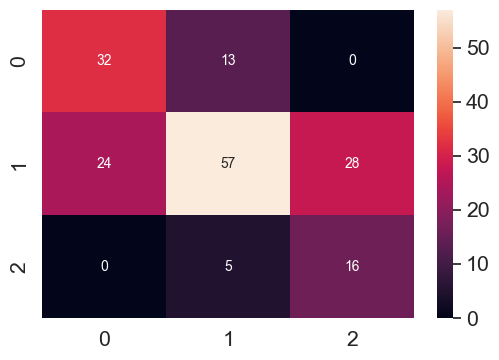

              precision    recall  f1-score   support

         1.0       0.57      0.71      0.63        45
         2.0       0.76      0.52      0.62       109
         3.0       0.36      0.76      0.49        21

    accuracy                           0.60       175
   macro avg       0.57      0.67      0.58       175
weighted avg       0.66      0.60      0.61       175



In [112]:
print("========================== SBFS  =================================")
b4_features = get_features_selected('results/SBFS_data4.csv')
print(f'Features selecionadas pelo SBFS: {b4_features}')
print("Matriz de confusão")
confusion_matrix4 = get_confusion_matrix(modelo4, X_train4_re.iloc[:, b4_features], y_train4_re, X_test4.iloc[:, b4_features], y_test4, labelEncoder)

========================== SFFS  =================================
Features selecionadas pelo SFFS: [3, 4, 6, 7, 8, 9, 15, 16, 18, 21, 24, 25, 26, 27, 31, 32, 34, 35, 42, 43, 44, 46, 49, 50, 52, 53, 54, 55, 56, 58, 59, 62, 63, 65, 75, 76, 77, 78, 81, 85, 88, 89, 91]
Matriz de confusão


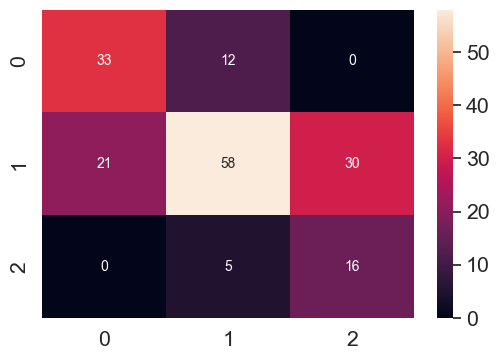

              precision    recall  f1-score   support

         1.0       0.61      0.73      0.67        45
         2.0       0.77      0.53      0.63       109
         3.0       0.35      0.76      0.48        21

    accuracy                           0.61       175
   macro avg       0.58      0.68      0.59       175
weighted avg       0.68      0.61      0.62       175



In [113]:
print("========================== SFFS  =================================")
b4_features = get_features_selected('results/SFFS_data4.csv')
print(f'Features selecionadas pelo SFFS: {b4_features}')
print("Matriz de confusão")
confusion_matrix4 = get_confusion_matrix(modelo4, X_train4_re.iloc[:, b4_features], y_train4_re, X_test4.iloc[:, b4_features], y_test4, labelEncoder)

### Sem Random Under-Sampling e com Normalização

#### Base 1

========================== SBFS  =================================
Features selecionadas pelo SBFS: [8, 22, 26, 42]
Matriz de confusão


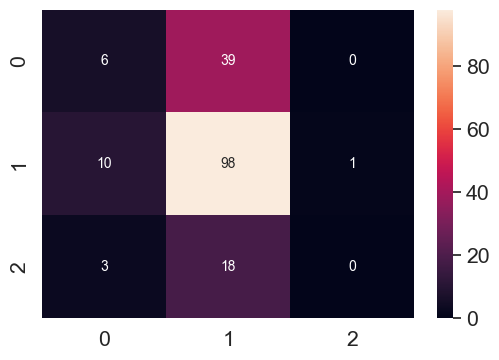

              precision    recall  f1-score   support

         1.0       0.32      0.13      0.19        45
         2.0       0.63      0.90      0.74       109
         3.0       0.00      0.00      0.00        21

    accuracy                           0.59       175
   macro avg       0.32      0.34      0.31       175
weighted avg       0.48      0.59      0.51       175



In [115]:
print("========================== SBFS  =================================")
b1_features = get_features_selected('results/SBFS_data1_norm.csv')
print(f'Features selecionadas pelo SBFS: {b1_features}')
print("Matriz de confusão")
confusion_matrix1 = get_confusion_matrix(modelo1_norm, X_train1_norm.iloc[:, b1_features], y_train1, X_test1_norm.iloc[:, b1_features], y_test1, labelEncoder)

========================== SFFS  =================================
Features selecionadas pelo SFFS: [8, 23, 26, 30, 33, 35, 38, 42, 43, 44, 46, 49]
Matriz de confusão


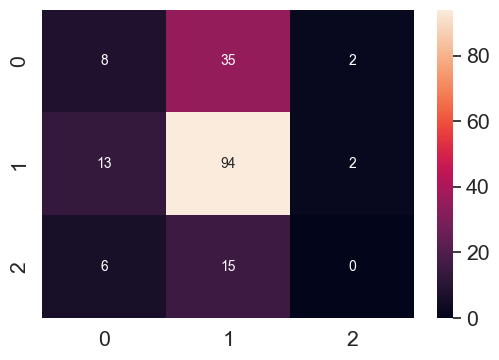

              precision    recall  f1-score   support

         1.0       0.30      0.18      0.22        45
         2.0       0.65      0.86      0.74       109
         3.0       0.00      0.00      0.00        21

    accuracy                           0.58       175
   macro avg       0.32      0.35      0.32       175
weighted avg       0.48      0.58      0.52       175



In [116]:
print("========================== SFFS  =================================")
b1_features = get_features_selected('results/SFFS_data1_norm.csv')
print(f'Features selecionadas pelo SFFS: {b1_features}')
print("Matriz de confusão")
confusion_matrix1 = get_confusion_matrix(modelo1_norm, X_train1_norm.iloc[:, b1_features], y_train1, X_test1_norm.iloc[:, b1_features], y_test1, labelEncoder)

#### Base 2

========================== SBFS  =================================
Features selecionadas pelo SBFS: [1, 4, 13, 20, 38, 42, 54]
Matriz de confusão


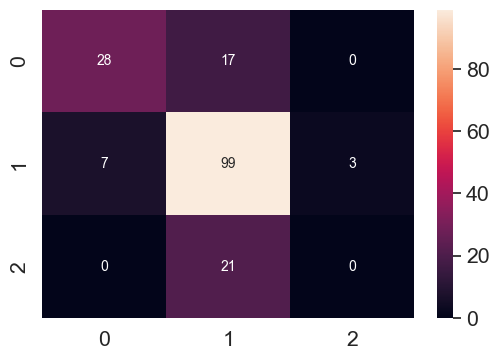

              precision    recall  f1-score   support

         1.0       0.80      0.62      0.70        45
         2.0       0.72      0.91      0.80       109
         3.0       0.00      0.00      0.00        21

    accuracy                           0.73       175
   macro avg       0.51      0.51      0.50       175
weighted avg       0.66      0.73      0.68       175



In [117]:
print("========================== SBFS  =================================")
b2_features = get_features_selected('results/SBFS_data2_norm.csv')
print(f'Features selecionadas pelo SBFS: {b2_features}')
print("Matriz de confusão")
confusion_matrix2 = get_confusion_matrix(modelo2_norm, X_train2_norm.iloc[:, b2_features], y_train2, X_test2_norm.iloc[:, b2_features], y_test2, labelEncoder)

========================== SFFS  =================================
Features selecionadas pelo SFFS: [35, 38, 52, 54]
Matriz de confusão


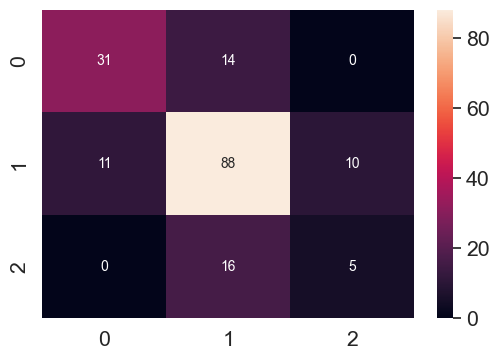

              precision    recall  f1-score   support

         1.0       0.74      0.69      0.71        45
         2.0       0.75      0.81      0.78       109
         3.0       0.33      0.24      0.28        21

    accuracy                           0.71       175
   macro avg       0.61      0.58      0.59       175
weighted avg       0.69      0.71      0.70       175



In [118]:
print("========================== SFFS  =================================")
b2_features = get_features_selected('results/SFFS_data2_norm.csv')
print(f'Features selecionadas pelo SFFS: {b2_features}')
print("Matriz de confusão")
confusion_matrix2 = get_confusion_matrix(modelo2_norm, X_train2_norm.iloc[:, b2_features], y_train2, X_test2_norm.iloc[:, b2_features], y_test2, labelEncoder)

#### Base 3

========================== SBFS  =================================
Features selecionadas pelo SBFS: [0, 14, 17, 27, 55, 56, 57]
Matriz de confusão


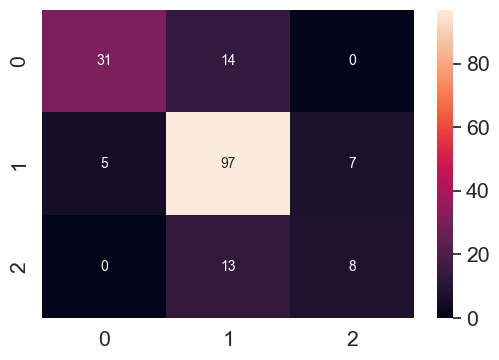

              precision    recall  f1-score   support

         1.0       0.86      0.69      0.77        45
         2.0       0.78      0.89      0.83       109
         3.0       0.53      0.38      0.44        21

    accuracy                           0.78       175
   macro avg       0.73      0.65      0.68       175
weighted avg       0.77      0.78      0.77       175



In [119]:
print("========================== SBFS  =================================")
b3_features = get_features_selected('results/SBFS_data3_norm.csv')
print(f'Features selecionadas pelo SBFS: {b3_features}')
print("Matriz de confusão")
confusion_matrix3 = get_confusion_matrix(modelo3_norm, X_train3_norm.iloc[:, b3_features], y_train3, X_test3_norm.iloc[:, b3_features], y_test3, labelEncoder)

========================== SFFS  =================================
Features selecionadas pelo SFFS: [0, 14, 17, 27, 55, 56, 57]
Matriz de confusão


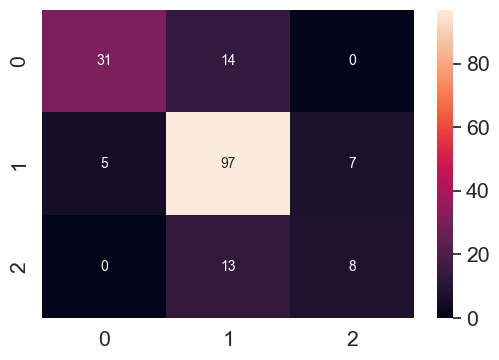

              precision    recall  f1-score   support

         1.0       0.86      0.69      0.77        45
         2.0       0.78      0.89      0.83       109
         3.0       0.53      0.38      0.44        21

    accuracy                           0.78       175
   macro avg       0.73      0.65      0.68       175
weighted avg       0.77      0.78      0.77       175



In [120]:
print("========================== SFFS  =================================")
b3_features = get_features_selected('results/SFFS_data3_norm.csv')
print(f'Features selecionadas pelo SFFS: {b3_features}')
print("Matriz de confusão")
confusion_matrix3 = get_confusion_matrix(modelo3_norm, X_train3_norm.iloc[:, b3_features], y_train3, X_test3_norm.iloc[:, b3_features], y_test3, labelEncoder)

#### Base 4

In [ ]:
print("========================== SBFS  =================================")
b4_features = get_features_selected('results/SBFS_data4_norm.csv')
print(f'Features selecionadas pelo SBFS: {b4_features}')
print("Matriz de confusão")
confusion_matrix4 = get_confusion_matrix(modelo4_norm, X_train4_norm.iloc[:, b4_features], y_train4, X_test4_norm.iloc[:, b4_features], y_test4, labelEncoder)

========================== SBFS  =================================


FileNotFoundError: [Errno 2] No such file or directory: 'results/SBFS_data4_norm.csv'

In [ ]:
print("========================== SFFS  =================================")
b4_features = get_features_selected('results/SFFS_data4_norm.csv')
print(f'Features selecionadas pelo SFFS: {b4_features}')
print("Matriz de confusão")
confusion_matrix4 = get_confusion_matrix(modelo4_norm, X_train4_norm.iloc[:, b4_features], y_train4, X_test4_norm.iloc[:, b4_features], y_test4, labelEncoder)

========================== SFFS  =================================


FileNotFoundError: [Errno 2] No such file or directory: 'results/SFFS_data4_norm.csv'

## Matriz de Confusão

In [ ]:


# Definindo as classes
classes = ["Baixo", "Médio", "Alto"]

# Sua matriz de confusão de três classes
conf_matrix = np.array([[20, 0, 2],
                        [0, 30, 1],
                        [12, 3, 27]])

# Calculando precisão, recall e f1 score para cada classe
precision = []
recall = []
f1 = []

for i in range(len(conf_matrix)):
    TP = conf_matrix[i][i]
    FP = sum(conf_matrix[r][i] for r in range(len(conf_matrix)) if r != i)
    FN = sum(conf_matrix[i][c] for c in range(len(conf_matrix)) if c != i)

    precision.append(TP / (TP + FP))
    recall.append(TP / (TP + FN))
    f1.append(2 * (precision[i] * recall[i]) / (precision[i] + recall[i]))

# Criando um DataFrame com os resultados
df = pd.DataFrame({'Classe': classes, 'Precisão': precision, 'Recall': recall, 'F1 Score': f1})

# Plotando a matriz de confusão
plt.figure(figsize=(8, 6), dpi=300)
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=classes, yticklabels=classes, annot_kws={"size": 14})
plt.xlabel('Classe Prevista', size=12, fontweight='bold')
plt.ylabel('Classe Real', size=12, fontweight='bold')
plt.title('Matriz de Confusão - SBFS - DATA 2', size=14, fontweight='bold')
plt.savefig('confusion_matrix_sbfs_data2.png', dpi=300, transparent=True)
plt.show()

# Exibindo a tabela com os resultados
print("Tabela de Resultados:")
df


